# 0.0. Imports

In [1]:
import pandas as pd
import numpy  as np

import seaborn as sns
import scikitplot as skplt

from matplotlib import pyplot as plt
from matplotlib              import gridspec

from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import ensemble as en
from sklearn import neighbors as nh
from scipy      import stats           as ss
import pickle
import random


## 0.1 Helper Function

In [2]:
#ajusta graficos
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 40
    
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

#Retirar notação cientifica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#cramer V Function
def cramer_v( x, y ):
    cm = np.asmatrix ( pd.crosstab( x, y ) )
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt( ( chi2corr / n ) / min( kcorr-1, rcorr-1 ) )


def percentage_pandas(df1, df_total ):
    percentage = df1.shape[0]/df_total.shape[0] *100
    return percentage



In [3]:
jupyter_settings()

## 0.1. Loading Dataset

In [4]:
df_raw = pd.read_csv( './dataset/train.csv' )

# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 
            'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
            
df1.columns = cols_new            

**Descrição das variáveis**  
1. **id** --> Unique ID for the customer  
2. **Gender** -->	Gender of the customer  
3. **Age** --> Age of the customer  
4. **Driving_License** --> 	0 : Customer does not have DL, 1 : Customer already has DL  
5. **Region_Code** --> Unique code for the region of the customer  
6. **Previously_Insured** --> 	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance  
7. **Vehicle_Age** --> Age of the Vehicle  
8. **Vehicle_Damage** --> 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.  
9. **Annual_Premium** --> 	The amount customer needs to pay as premium in the year  
10. **PolicySalesChannel** --> Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.  
11. **Vintage** --> Number of Days, Customer has been associated with the company  
12. **Response** --> 1 : Customer is interested, 0 : Customer is not interested  

## 1.2. Data Dimension

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Columns: 12


## 1.3. Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Data Descriptive

In [10]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1 Numerical Attributes

In [11]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00,381109.00,381108.00,190555.00,190555.00,110016.69,0.00,-1.20
1,age,20.00,85.00,65.00,38.82,36.00,15.51,0.67,-0.57
2,driving_license,0.00,1.00,1.00,1.00,1.00,0.05,-21.60,464.35
3,region_code,0.00,52.00,52.00,26.39,28.00,13.23,-0.12,-0.87
4,previously_insured,0.00,1.00,1.00,0.46,0.00,0.50,0.17,-1.97
5,annual_premium,2630.00,540165.00,537535.00,30564.39,31669.00,17213.13,1.77,34.00
6,policy_sales_channel,1.00,163.00,162.00,112.03,133.00,54.20,-0.90,-0.97
7,vintage,10.00,299.00,289.00,154.35,154.00,83.67,0.00,-1.20
8,response,0.00,1.00,1.00,0.12,0.00,0.33,2.30,3.30


# 2.0. Feature Engineering

In [12]:
df2 =  df1.copy()

## 2.1 Hypoteses Creation

### Hypotheses

**Response variable "Car Insurance"**  
1. Clientes do sexo masculino tem mais interesse em contratar o seguro veicular  
2. Clientes que já se envolveram em sinistros tem mais interesse em contratar o seguro veicular
3. Clientes que possuem habilitação tem mais interesse em contratar o seguro veicular 
4. Clientes acima de 40 anos tem mais interesse em contratar o seguro veicular  
5. Clientes que já possuem seguro veicular nao tem interesse em contratar seguros veicular  
6. Clientes de seguro saúde mais antigos tem mais interesse em contratar o seguro veicular  
  

### 2.2 Feature Engineering

In [13]:
# vehicle age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' ) 

# vehicle damage
df2['vehicle_damage'] =  df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# 3.0. Data Filtering

In [14]:
# No filtering

# 4.0. Exploratory Data Analysis - EDA

In [15]:
df4 = df2.copy()

## 4.1. Univariate Analysis

**Análise cada variável individualmente**

### 4.1.1 Response Variable 

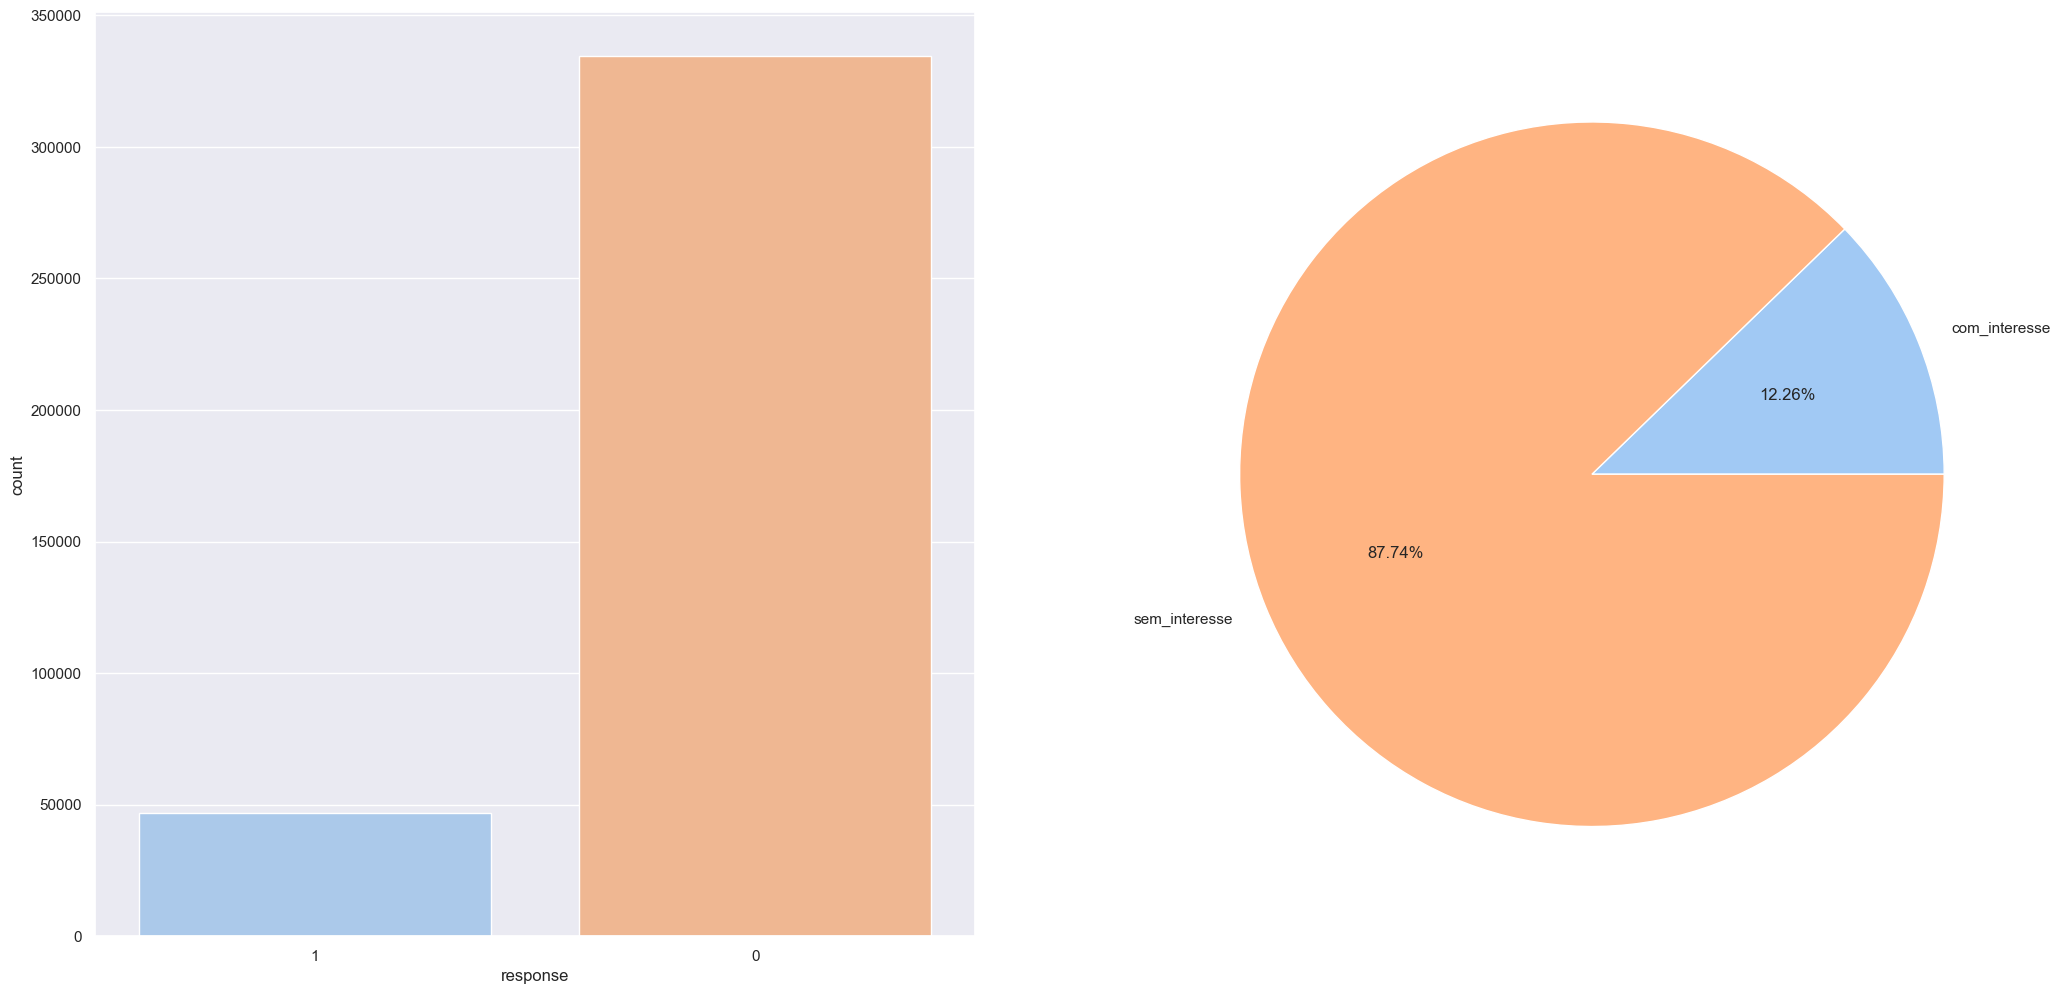

In [16]:
#response
plt.subplot(1,2,1)
sns.countplot(data=df4,x='response',order = [1, 0], palette = 'pastel');

#pie chart
aux1 = percentage_pandas(df4[ df4['response']==1 ], df4 )
aux2 = percentage_pandas(df4[ df4['response']==0 ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['com_interesse','sem_interesse']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

### 4.1.2 Numerical Variables

#### Age

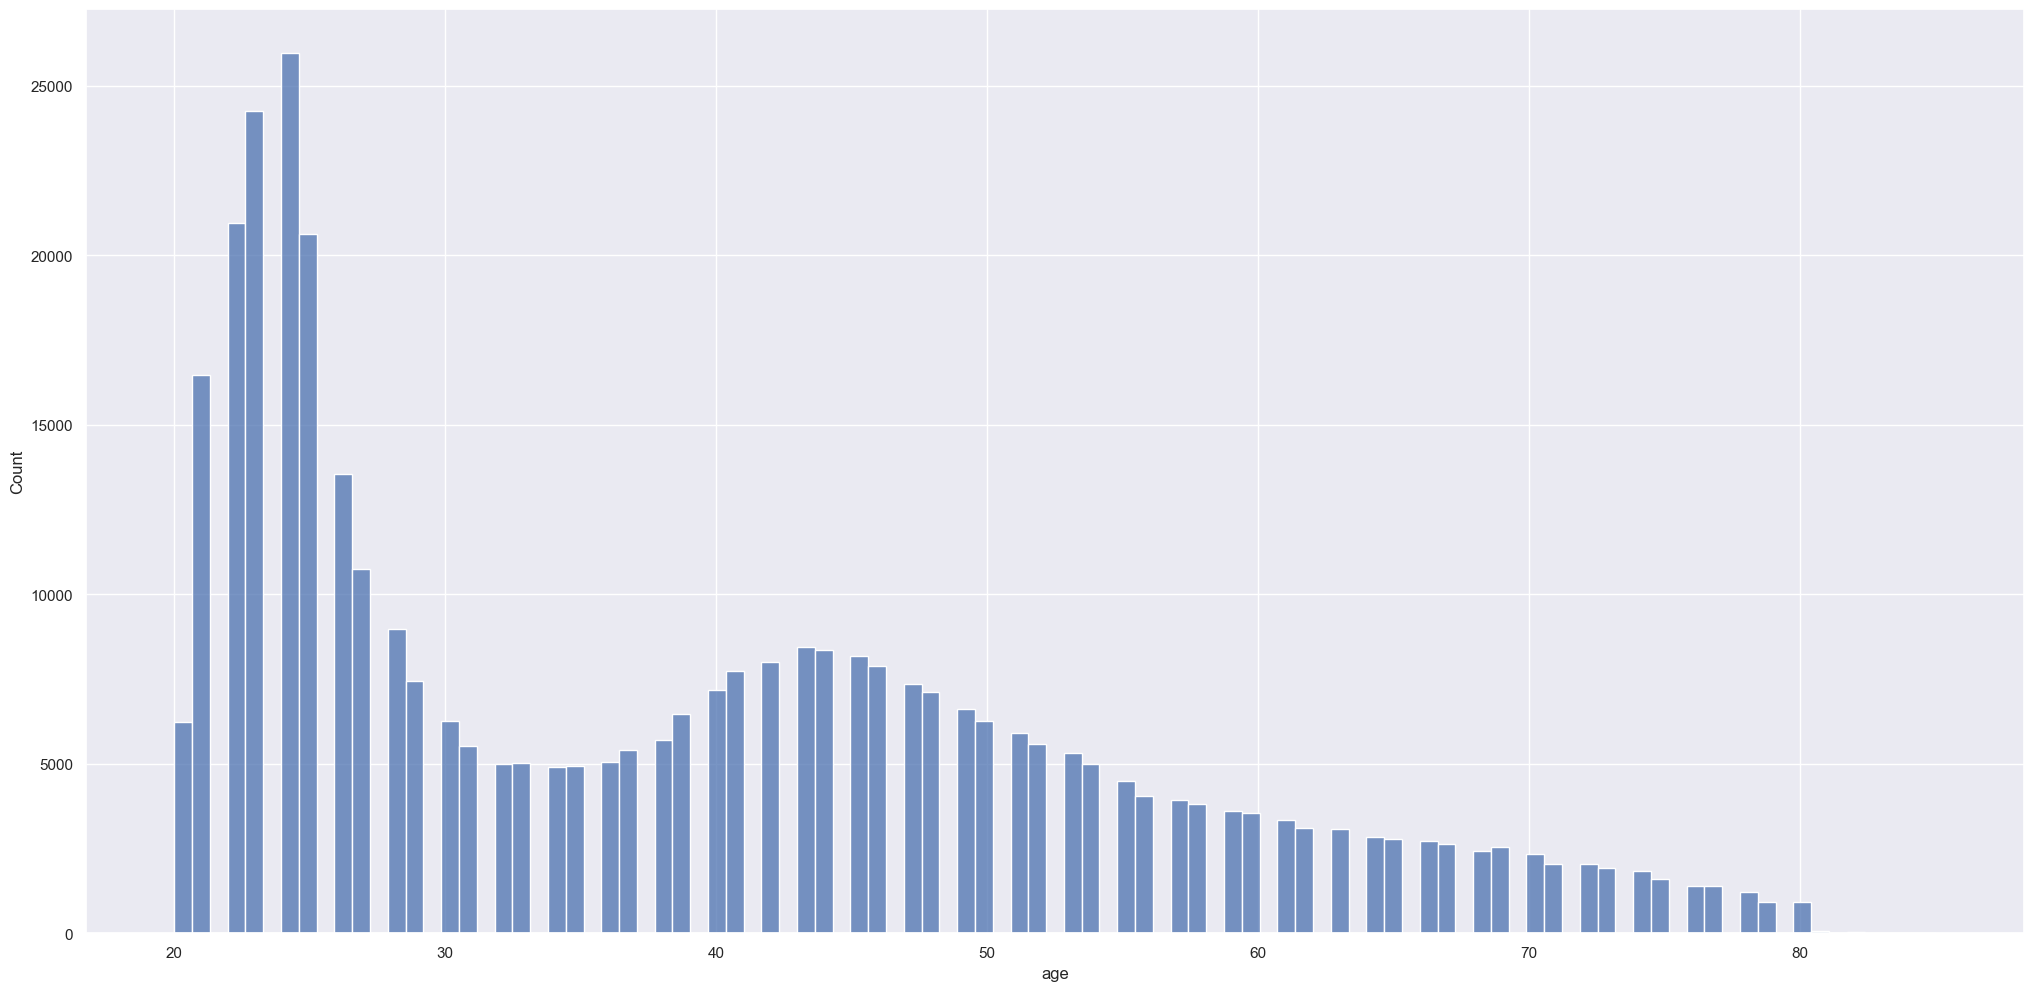

In [17]:
# Age distribution histogram
sns.histplot(data = df4, x = 'age');

In [18]:
df4['age'].describe()

count   381109.00
mean        38.82
std         15.51
min         20.00
25%         25.00
50%         36.00
75%         49.00
max         85.00
Name: age, dtype: float64

#### annual_premium

In [19]:
df4['annual_premium'].describe()

count   381109.00
mean     30564.39
std      17213.16
min       2630.00
25%      24405.00
50%      31669.00
75%      39400.00
max     540165.00
Name: annual_premium, dtype: float64

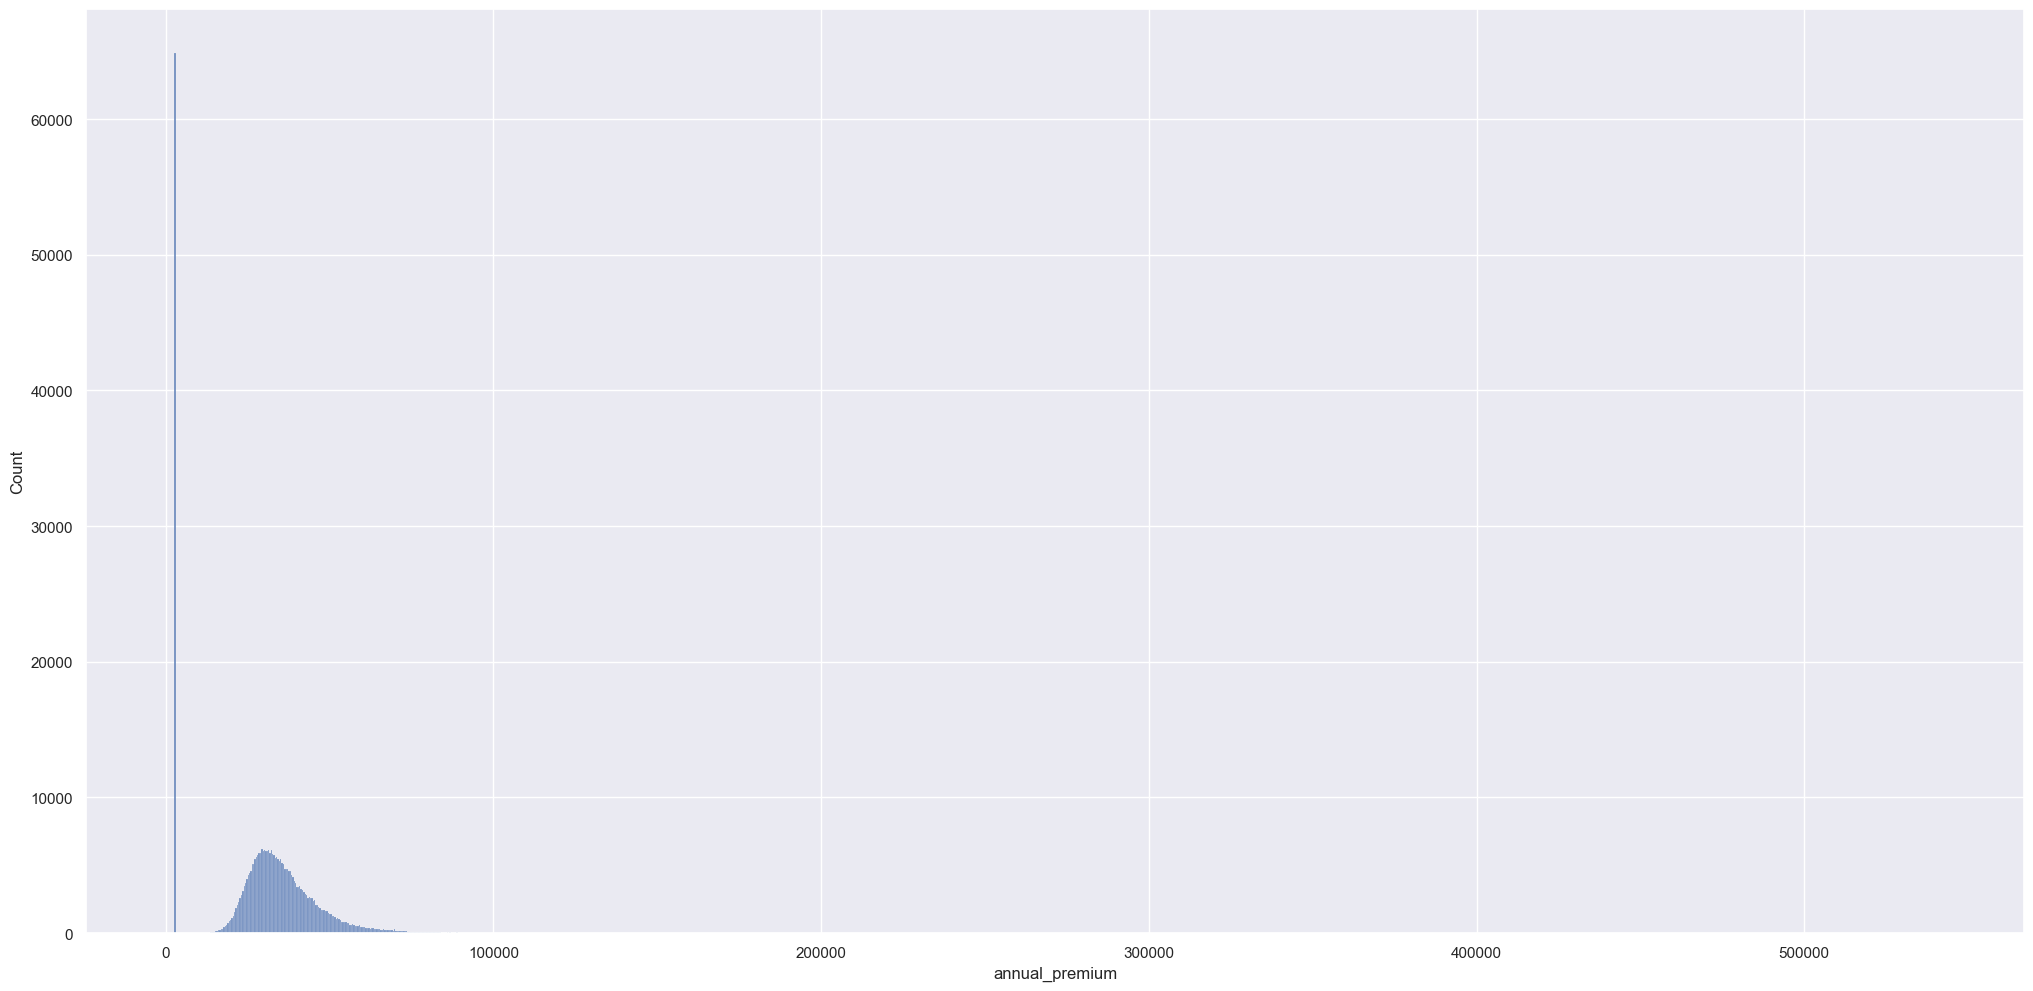

In [20]:
sns.histplot(data = df4, x ='annual_premium' );

**Concentração de clientes em um valor e demais observações há comportamento de distribuição**

Number of rows "annual_premium" equal 2630 : 64877
Percentage of rows "annual_premium" equal 2630 : 17.023213831213642 %


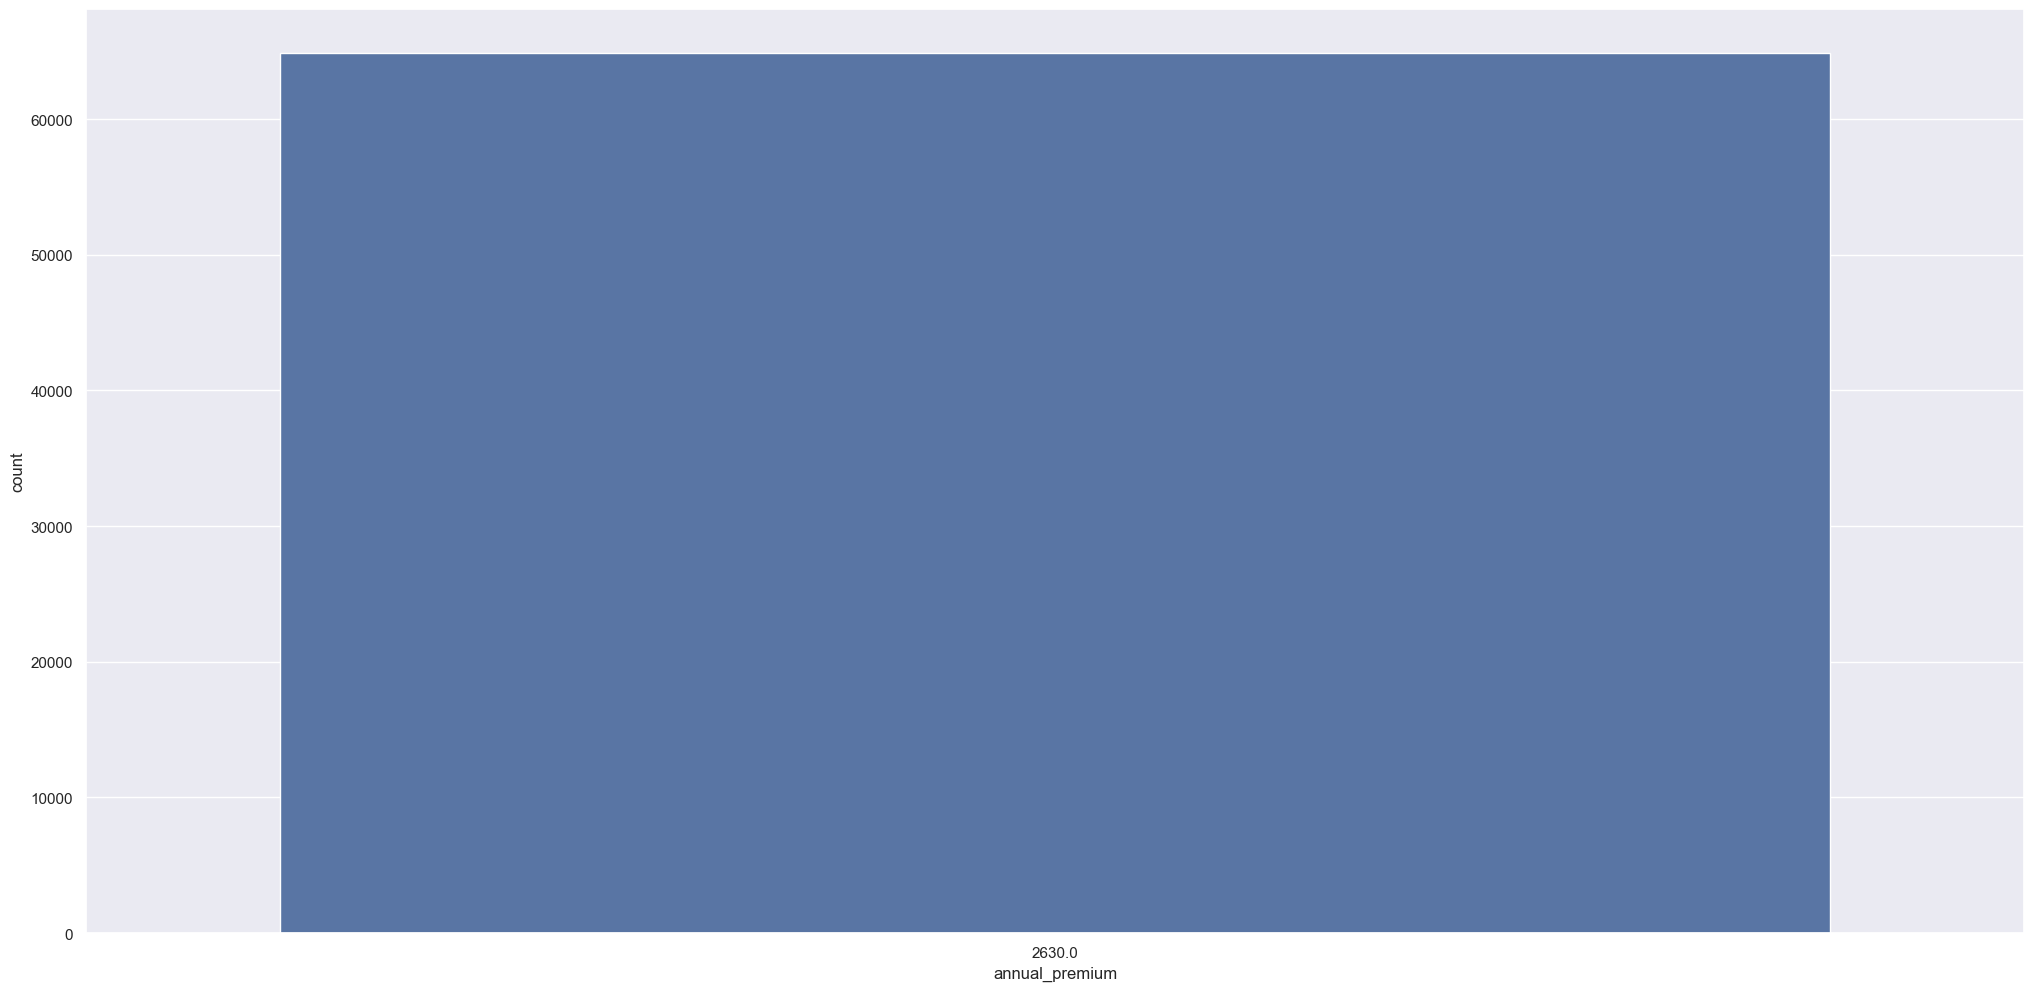

In [21]:
aux1  = df4.loc[df4['annual_premium'] == 2630 ]
print ( 'Number of rows "annual_premium" equal 2630 : {}'.format(aux1.shape[0]) )
print ('Percentage of rows "annual_premium" equal 2630 : {} %'.format(percentage_pandas(aux1, df4) ) )
sns.countplot(data = aux1, x ='annual_premium' );

Number of rows "annual_premium" > 2630 : 316232
Percentage of rows "annual_premium" > 2630 : 82.97678616878635 %


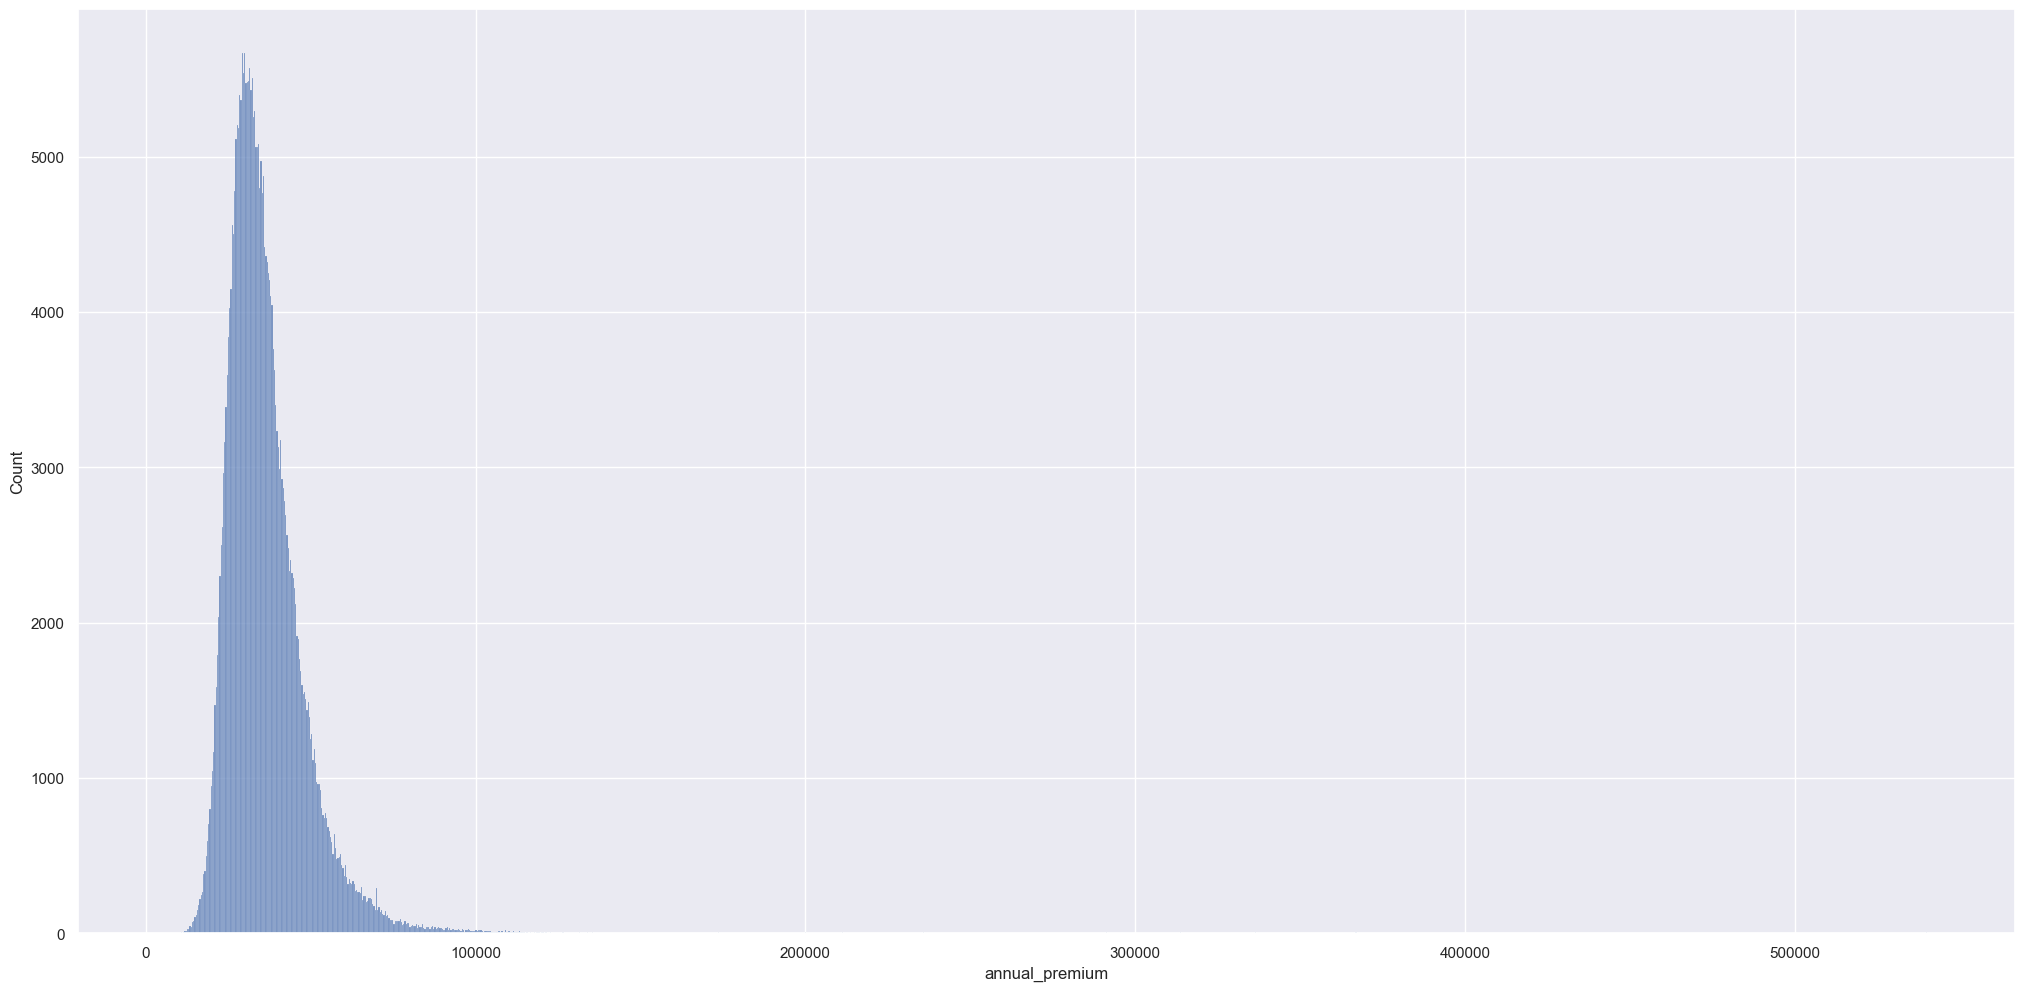

In [22]:
aux1  = df4.loc[df4['annual_premium'] > 2630 ]
print ( 'Number of rows "annual_premium" > 2630 : {}'.format(aux1.shape[0]) )
print ('Percentage of rows "annual_premium" > 2630 : {} %'.format(percentage_pandas(aux1, df4) ) )
sns.histplot(data = aux1, x ='annual_premium' );

#### Vintage

In [23]:
# Number of days since customer contrated health insurance
df4['vintage'].describe()

count   381109.00
mean       154.35
std         83.67
min         10.00
25%         82.00
50%        154.00
75%        227.00
max        299.00
Name: vintage, dtype: float64

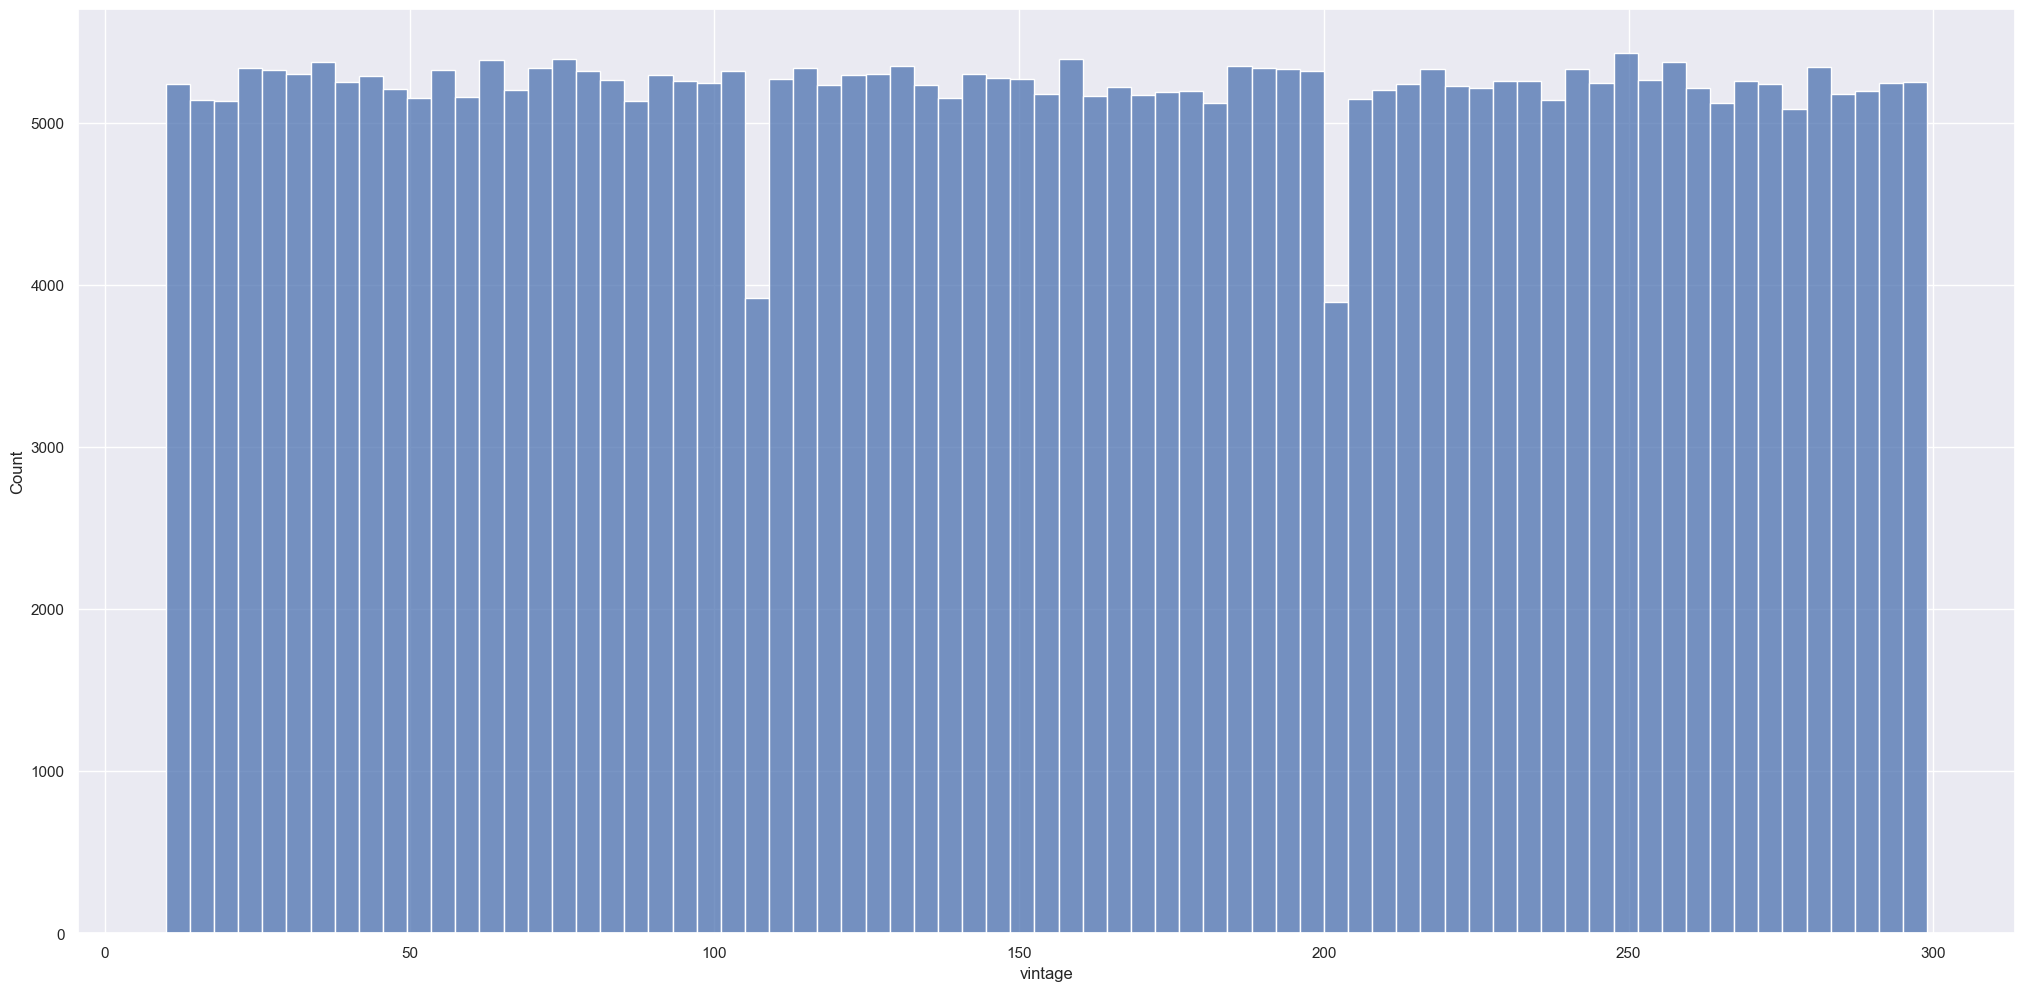

In [24]:
sns.histplot(data = df4, x = 'vintage');

### 4.1.3 Categorical Variables

#### driving_license

**0 : Customer does not have DL, 1 : Customer already has DL**

In [25]:
df4['driving_license'].value_counts()

1    380297
0       812
Name: driving_license, dtype: int64

* 812 dos clientes 0.21% não possuem carteira de habilitação.
* 380297 clientes 99.79 % possuem carteira de habilitação

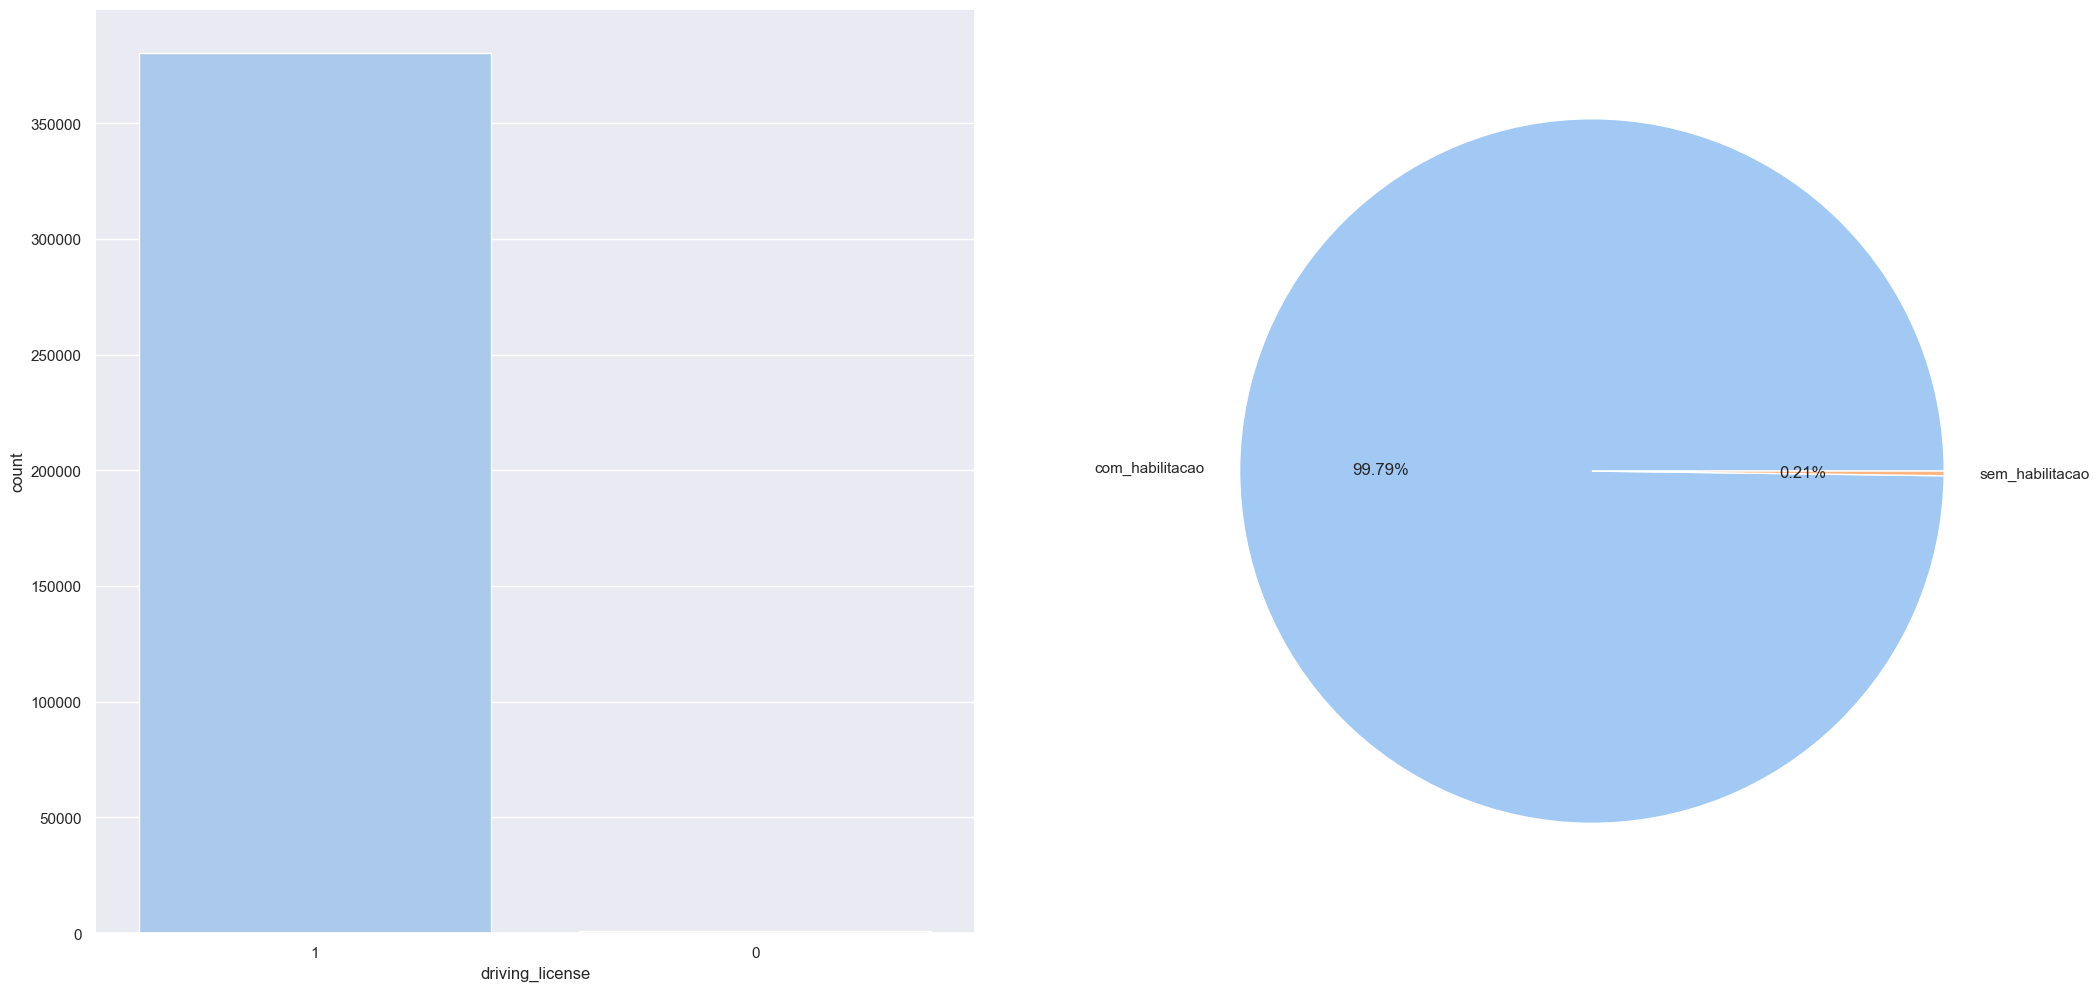

In [26]:
# driving_license
plt.subplot(1,2,1)
sns.countplot(data=df4,x='driving_license',order = [1, 0], palette = 'pastel');

#pie chart
aux1 = percentage_pandas(df4[ df4['driving_license']==1 ], df4 )
aux2 = percentage_pandas(df4[ df4['driving_license']==0 ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['com_habilitacao','sem_habilitacao']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

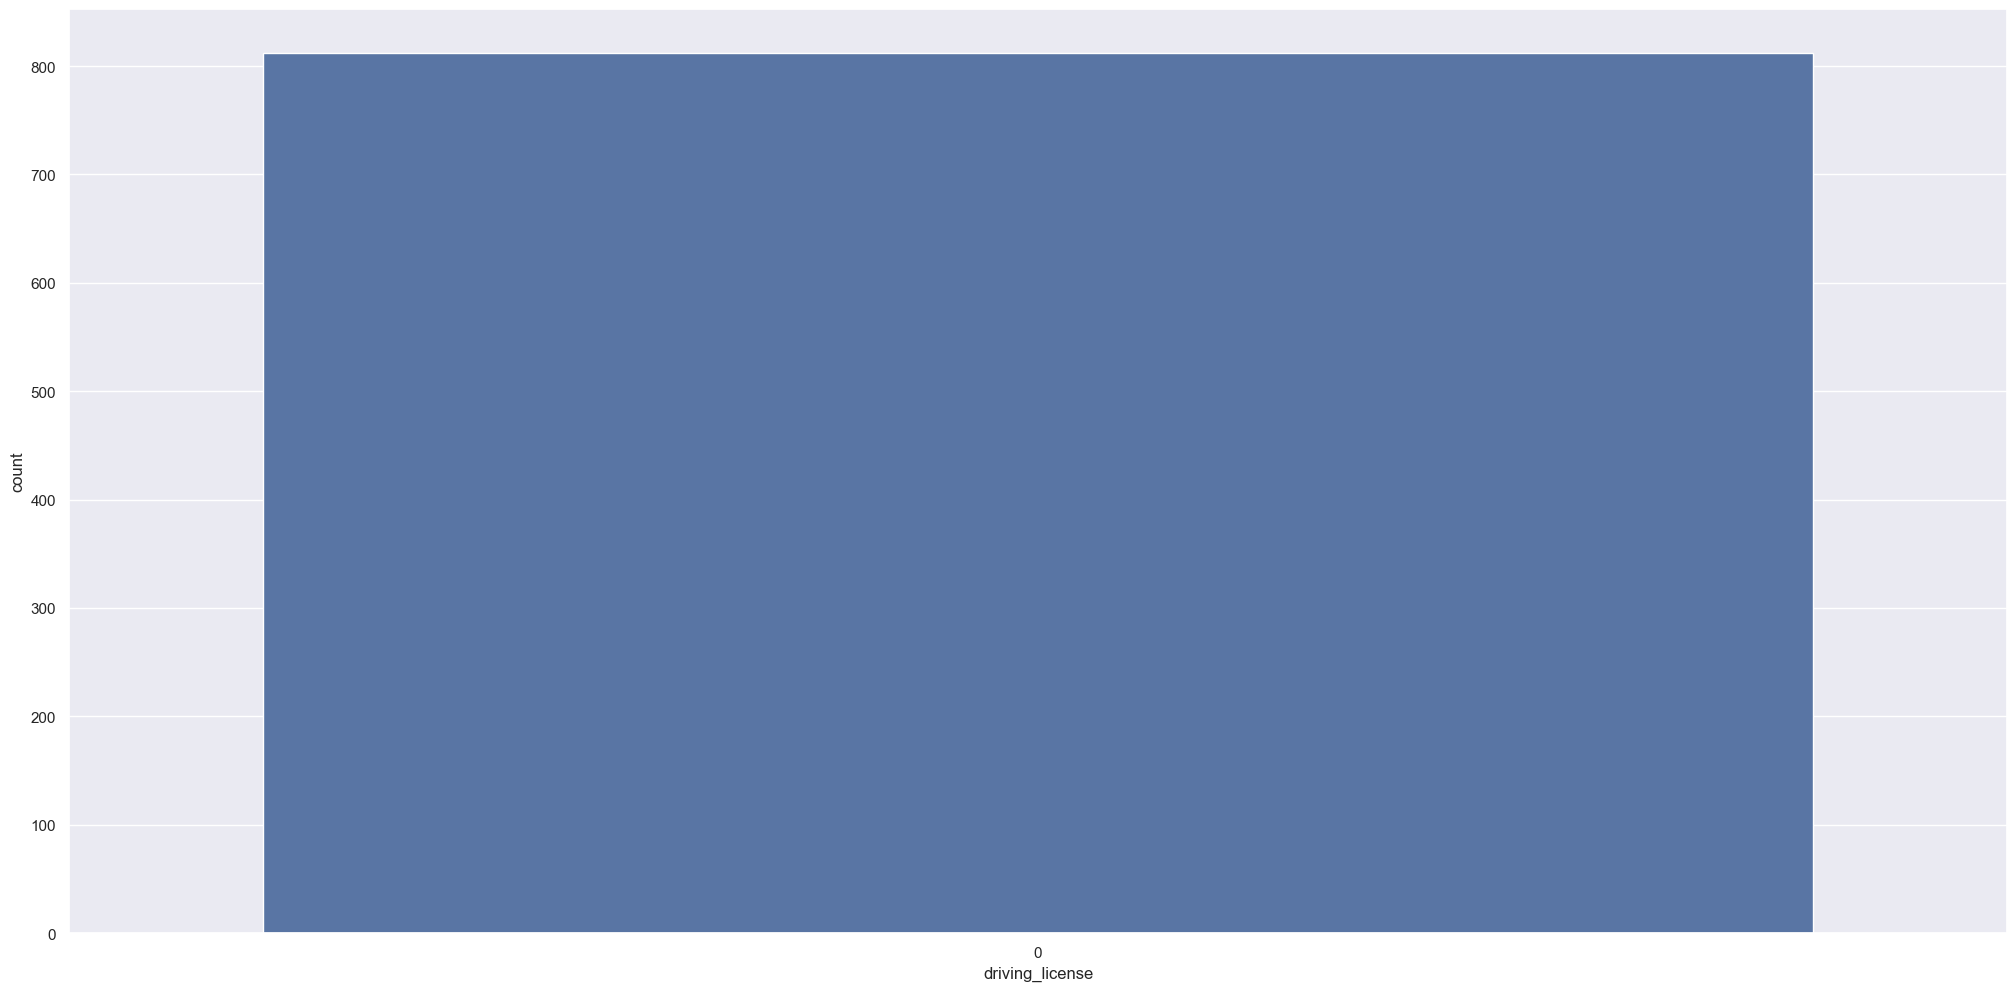

In [27]:
# customer without driving license
aux1 = df4.loc[df4['driving_license'] == 0 ]
sns.countplot(data=aux1,x='driving_license');

#### region_code

**Unique code for the region of the customer**

In [28]:
aux1 = df4['region_code'].value_counts(normalize = True)

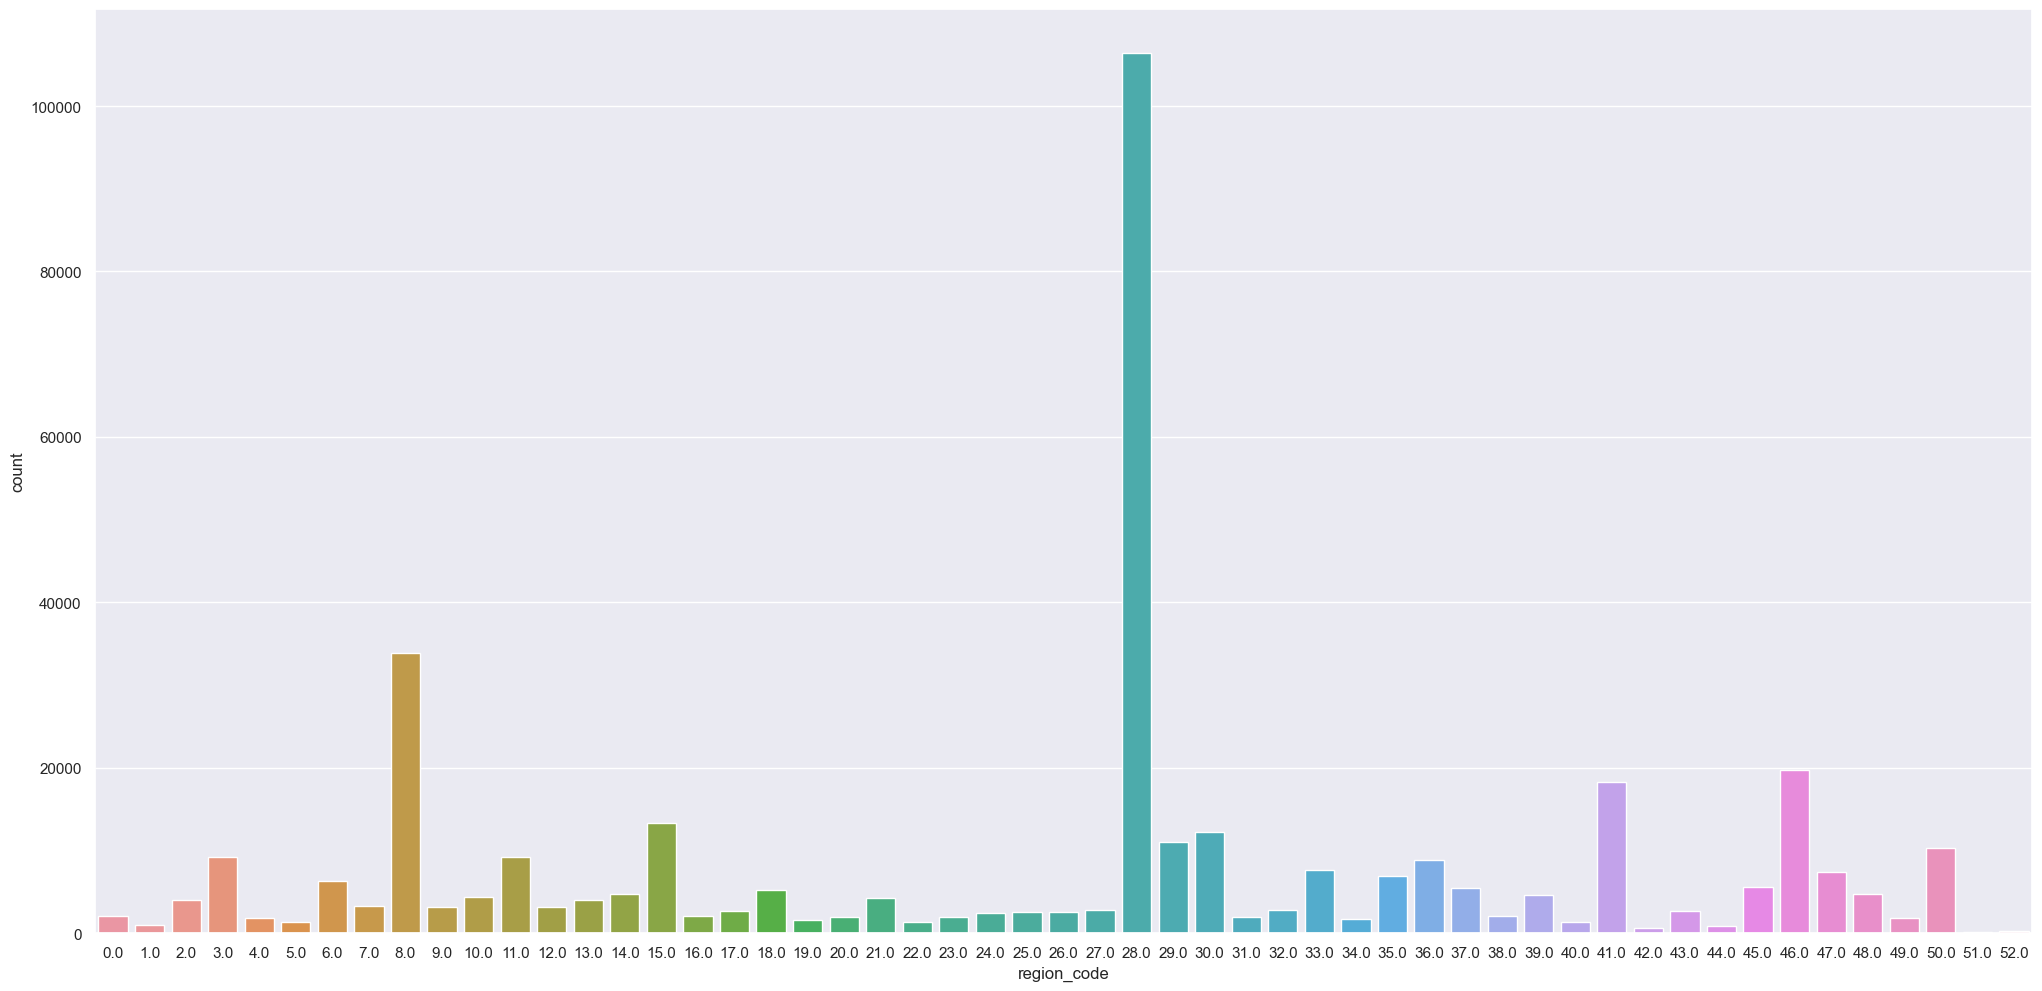

In [29]:
sns.countplot(data = df4, x = 'region_code');

* **A maioria dos clientes são das regiões 26, 8, 46 e 41**

#### gender

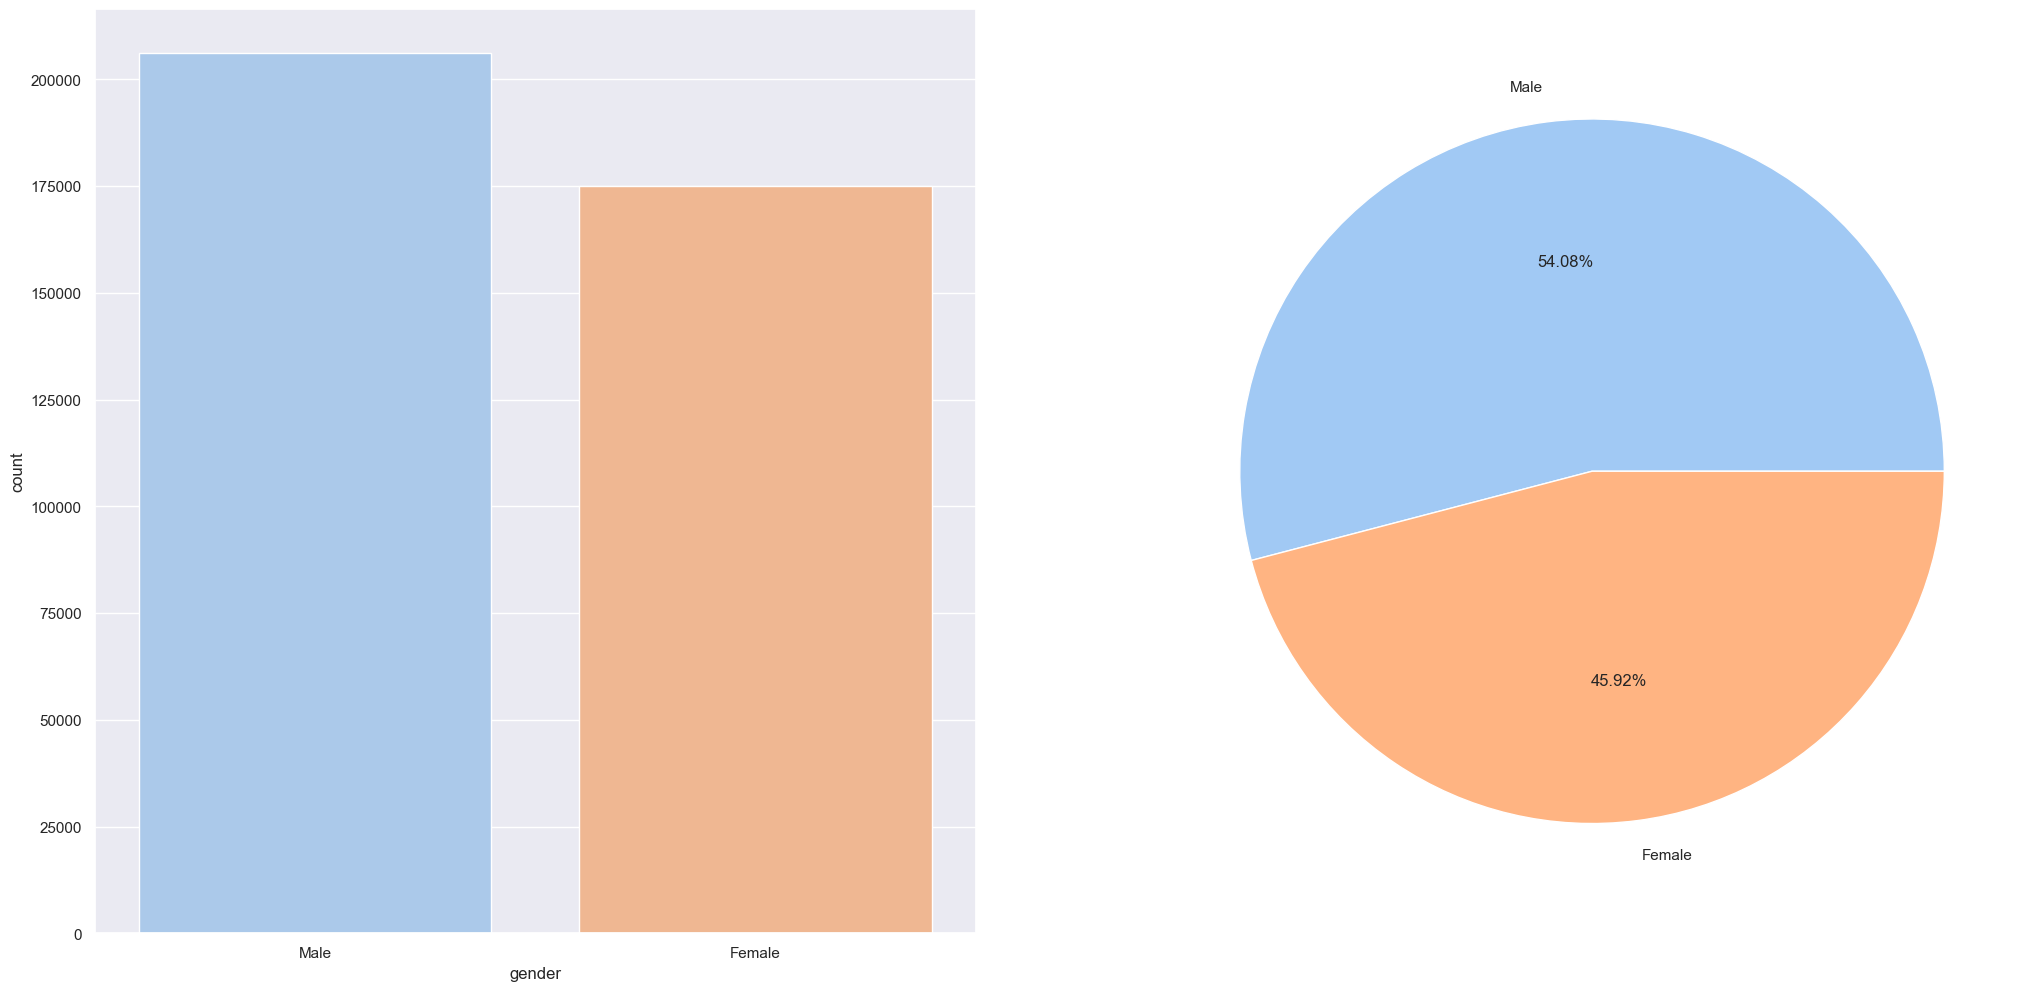

In [30]:
# gender
plt.subplot(1,2,1)
sns.countplot(data=df4,x='gender',order = ['Male', 'Female'], palette = 'pastel');

#pie chart
aux1 = percentage_pandas(df4[ df4['gender']=='Male' ], df4 )
aux2 = percentage_pandas(df4[ df4['gender']=='Female' ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['Male','Female']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

#### previously_insured

* **1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance**

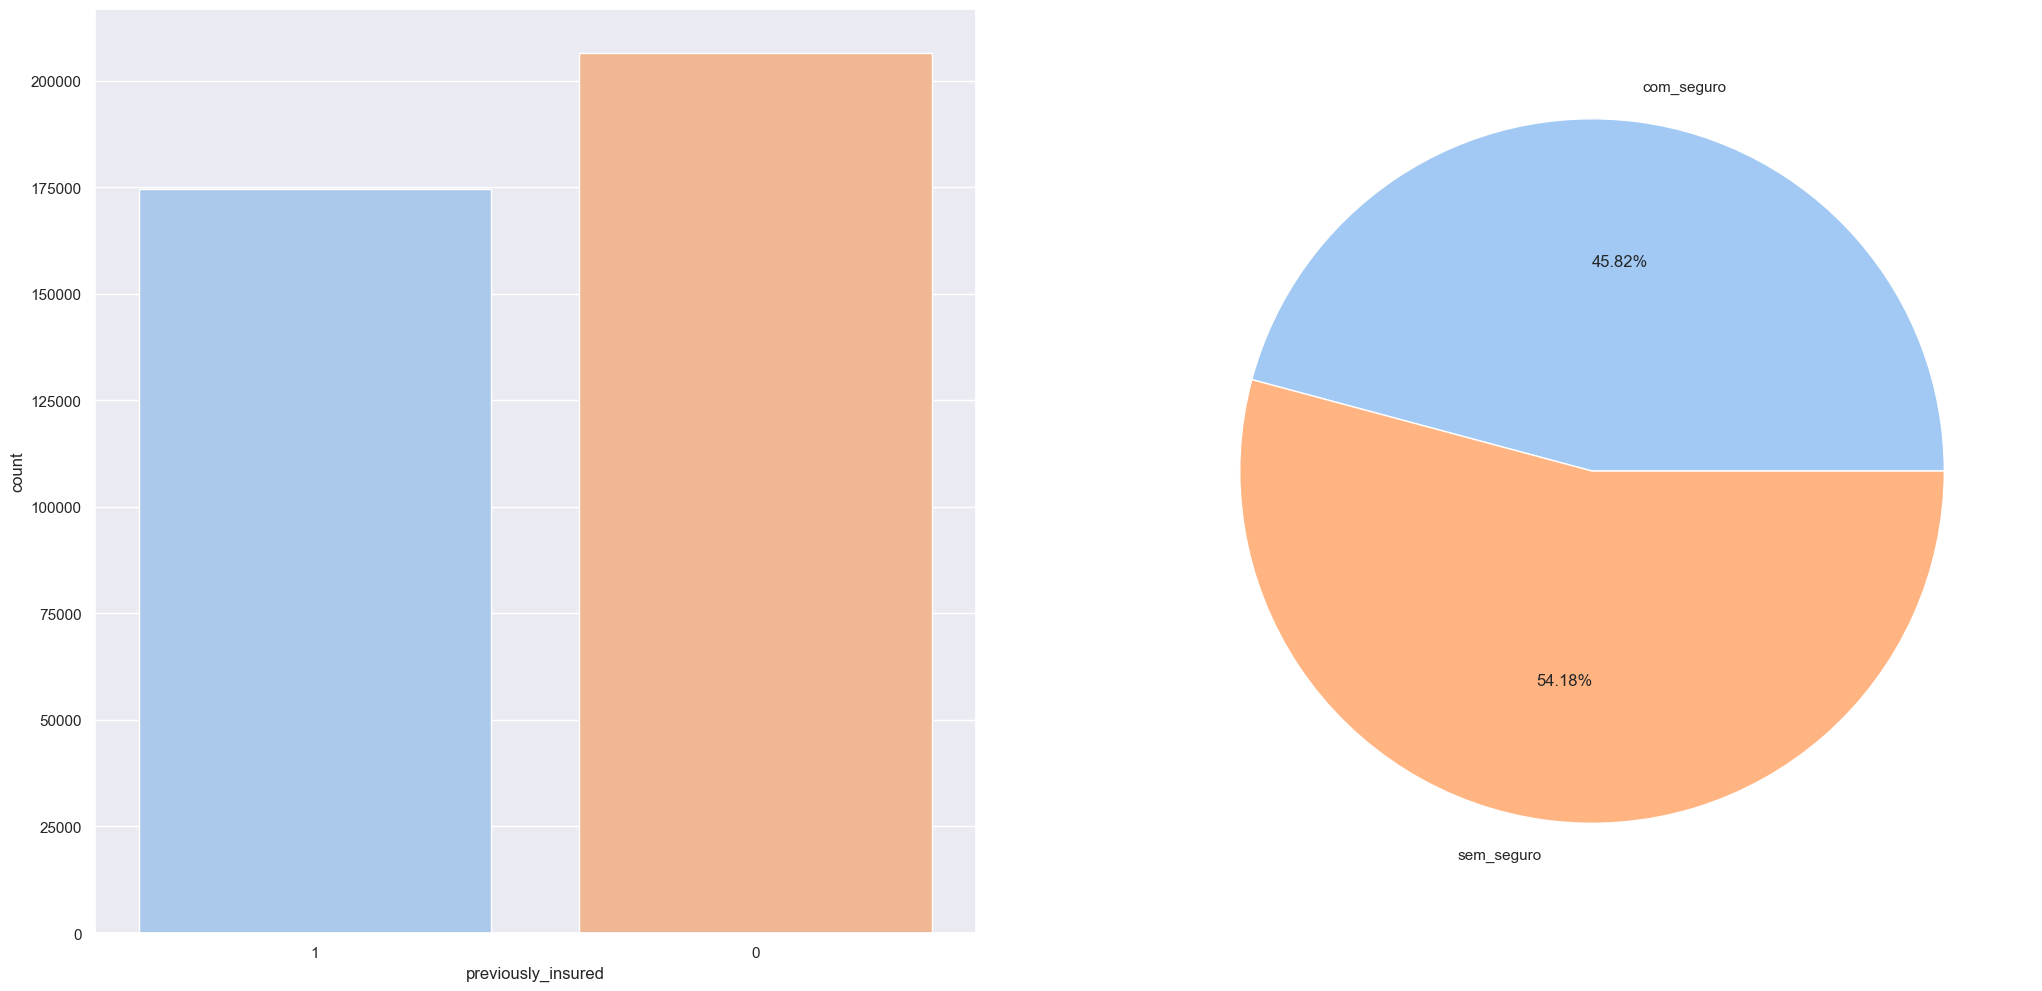

In [31]:
# previously_insured
plt.subplot(1,2,1)
sns.countplot(data=df4,x='previously_insured',order = [1, 0], palette = 'pastel');

#pie chart
aux1 = percentage_pandas(df4[ df4['previously_insured']==1 ], df4 )
aux2 = percentage_pandas(df4[ df4['previously_insured']==0 ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['com_seguro','sem_seguro']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

#### vehicle_age

In [32]:
df4['vehicle_age'].value_counts()

between_1_2_year    200316
below_1_year        164786
over_2_years         16007
Name: vehicle_age, dtype: int64

In [33]:
df4['vehicle_age'].value_counts(normalize = True)

between_1_2_year   0.53
below_1_year       0.43
over_2_years       0.04
Name: vehicle_age, dtype: float64

* **200316 veículos (53%) com idade entre 1 e 2 anos**
* **164786 veículos (43%) com idade abaixo de 1 ano**
* **16007  veículos (4%) com idade acima de 2 anos**

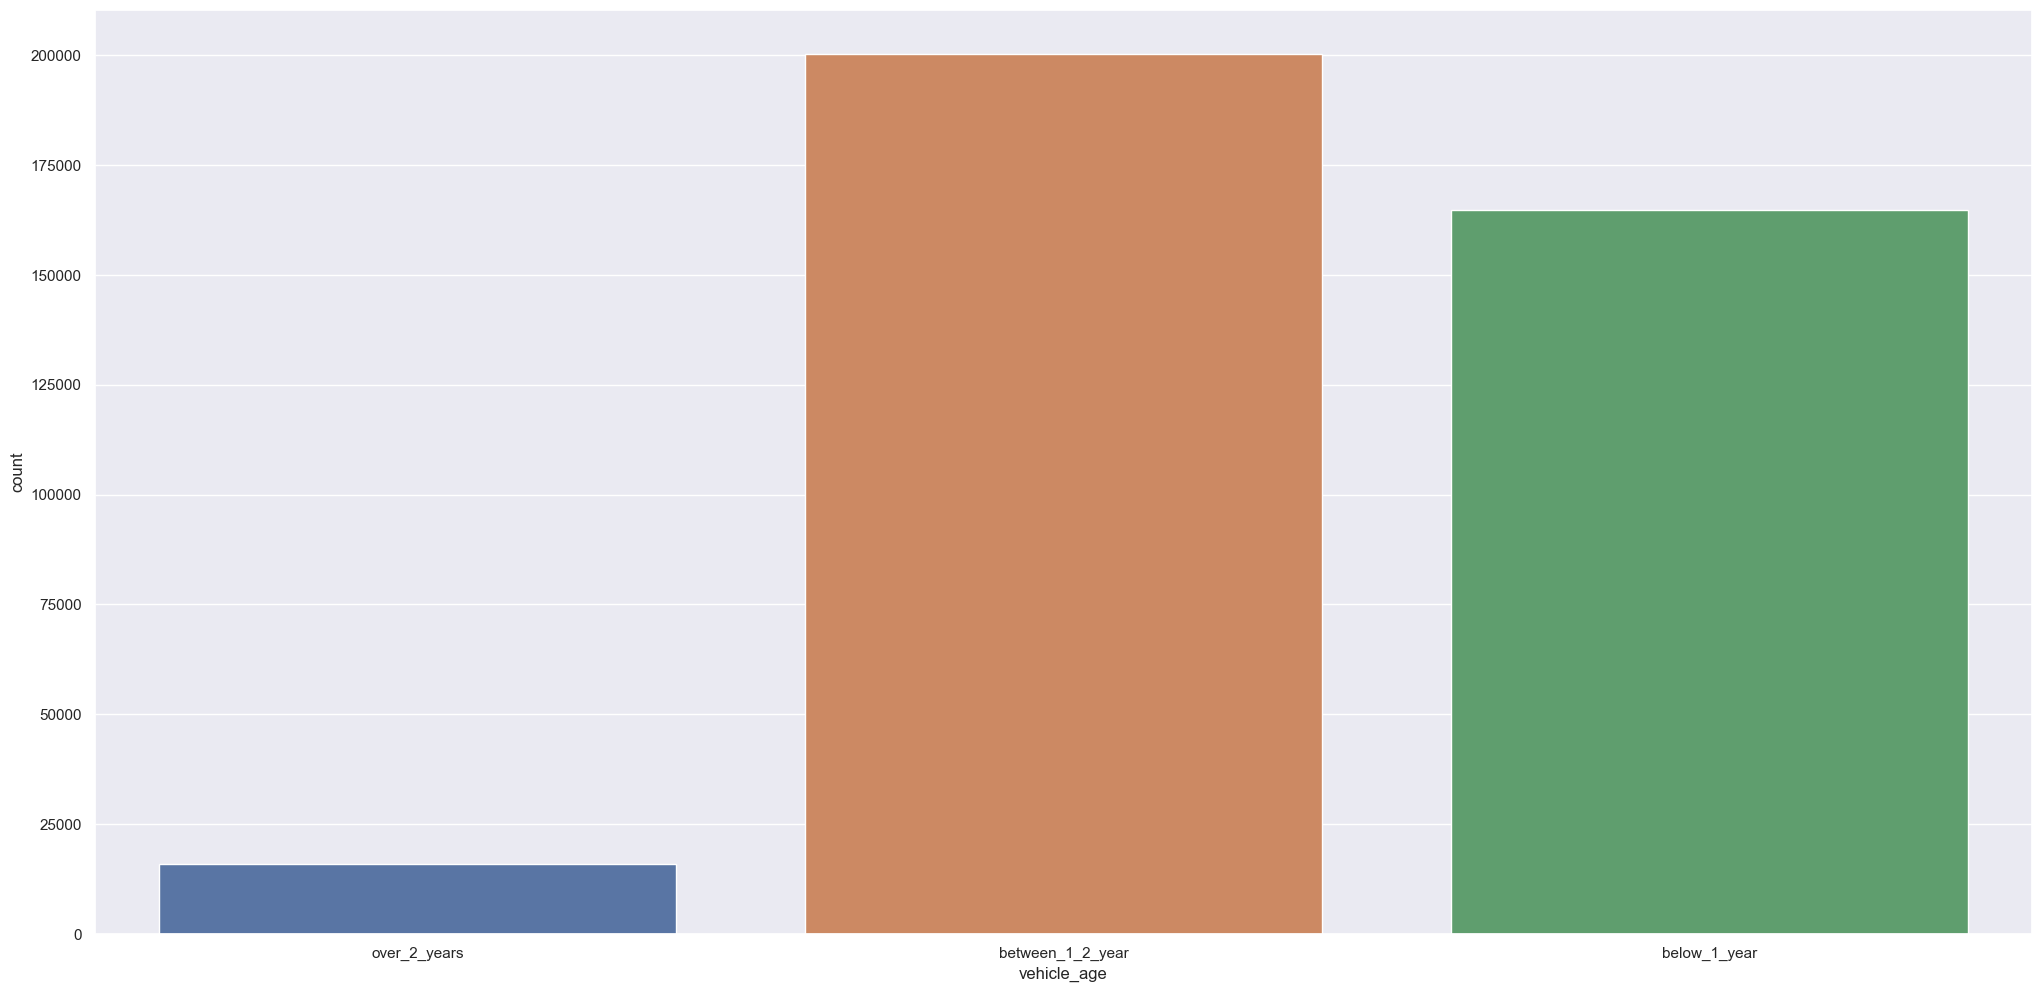

In [34]:
sns.countplot(data = df4, x = 'vehicle_age');

#### policy_sales_channel

* **Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.**

In [35]:
# quantity of customers by channels
aux1 = df4[['policy_sales_channel','id']].groupby('policy_sales_channel').count().reset_index()
aux1

,policy_sales_channel,id
0,1.00,1074
1,2.00,4
2,3.00,523
3,4.00,509
4,6.00,3
5,7.00,1598
6,8.00,1515
7,9.00,169
8,10.00,264
9,11.00,1203


In [36]:
print('Quantidade de canais de comunicação com o cliente: {}'.format( aux1.shape[0]))

Quantidade de canais de comunicação com o cliente: 155


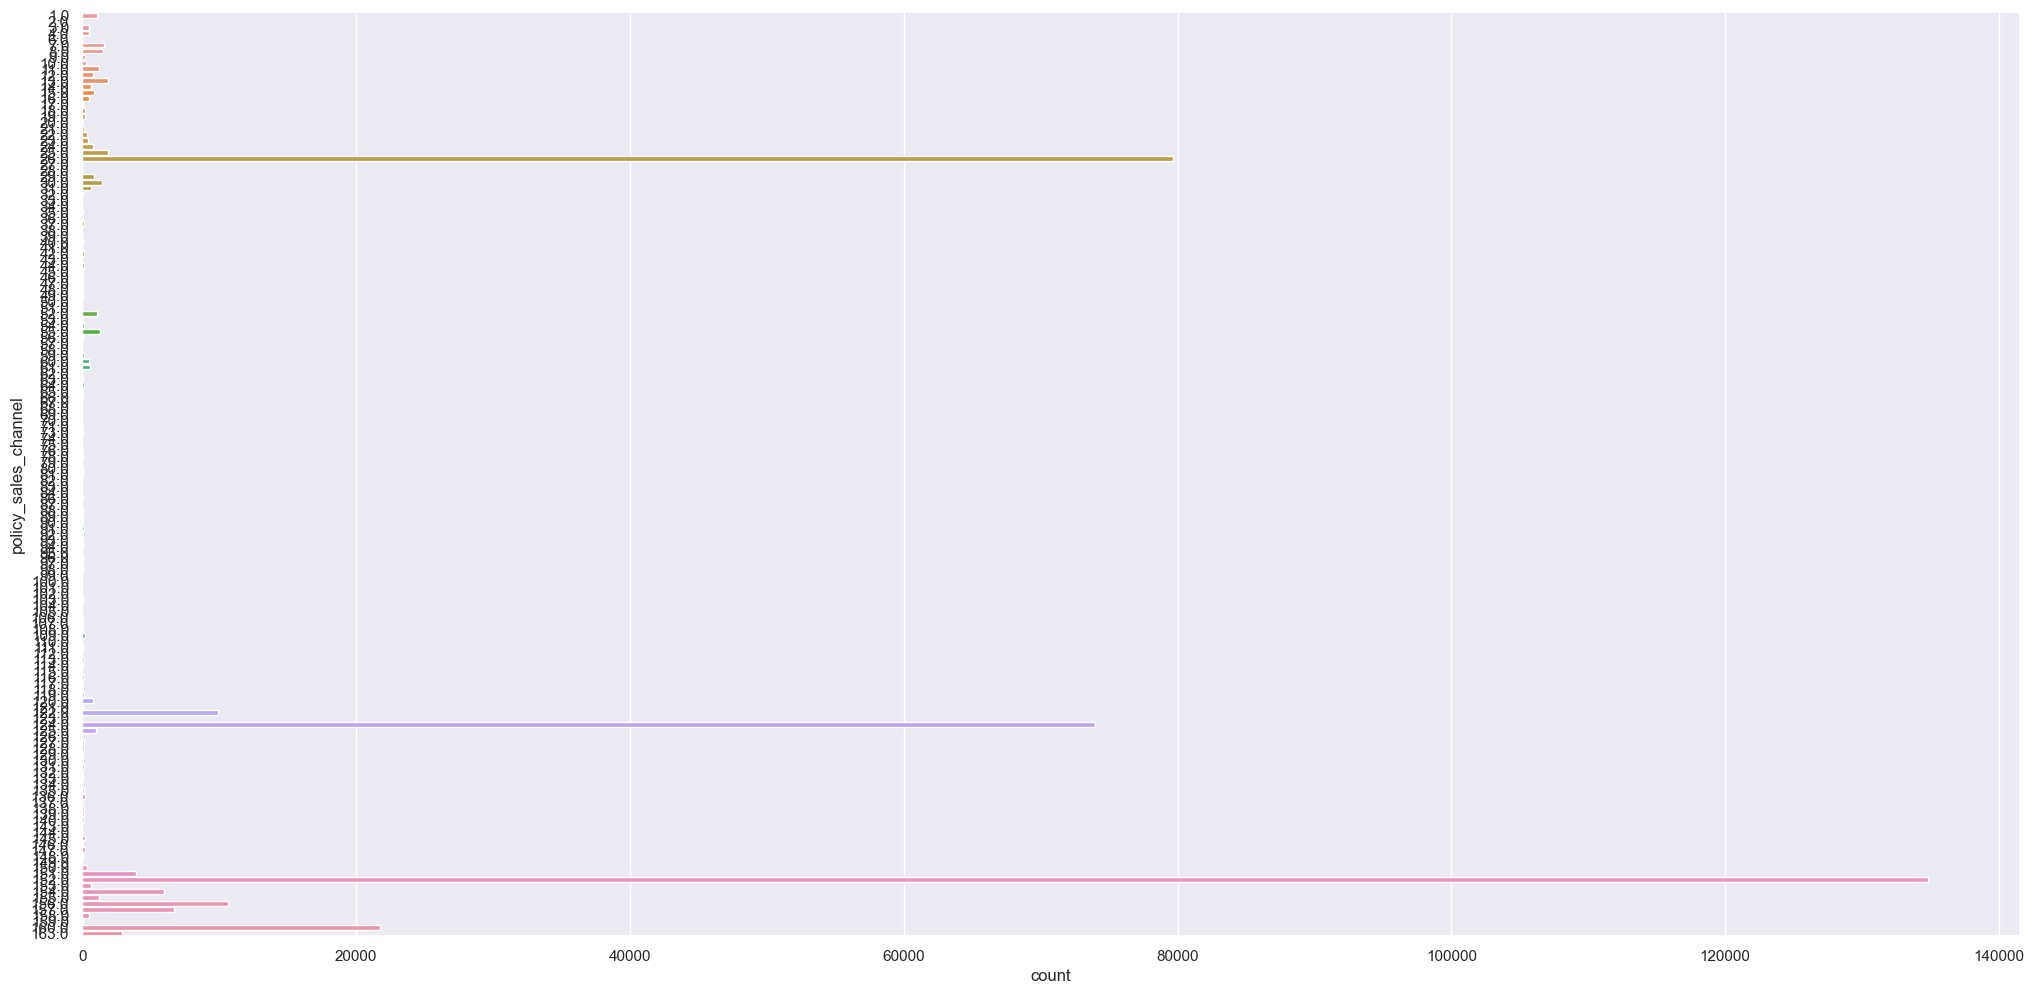

In [37]:
# plot - quantity of customers by channels
sns.countplot(data=df4,y='policy_sales_channel');

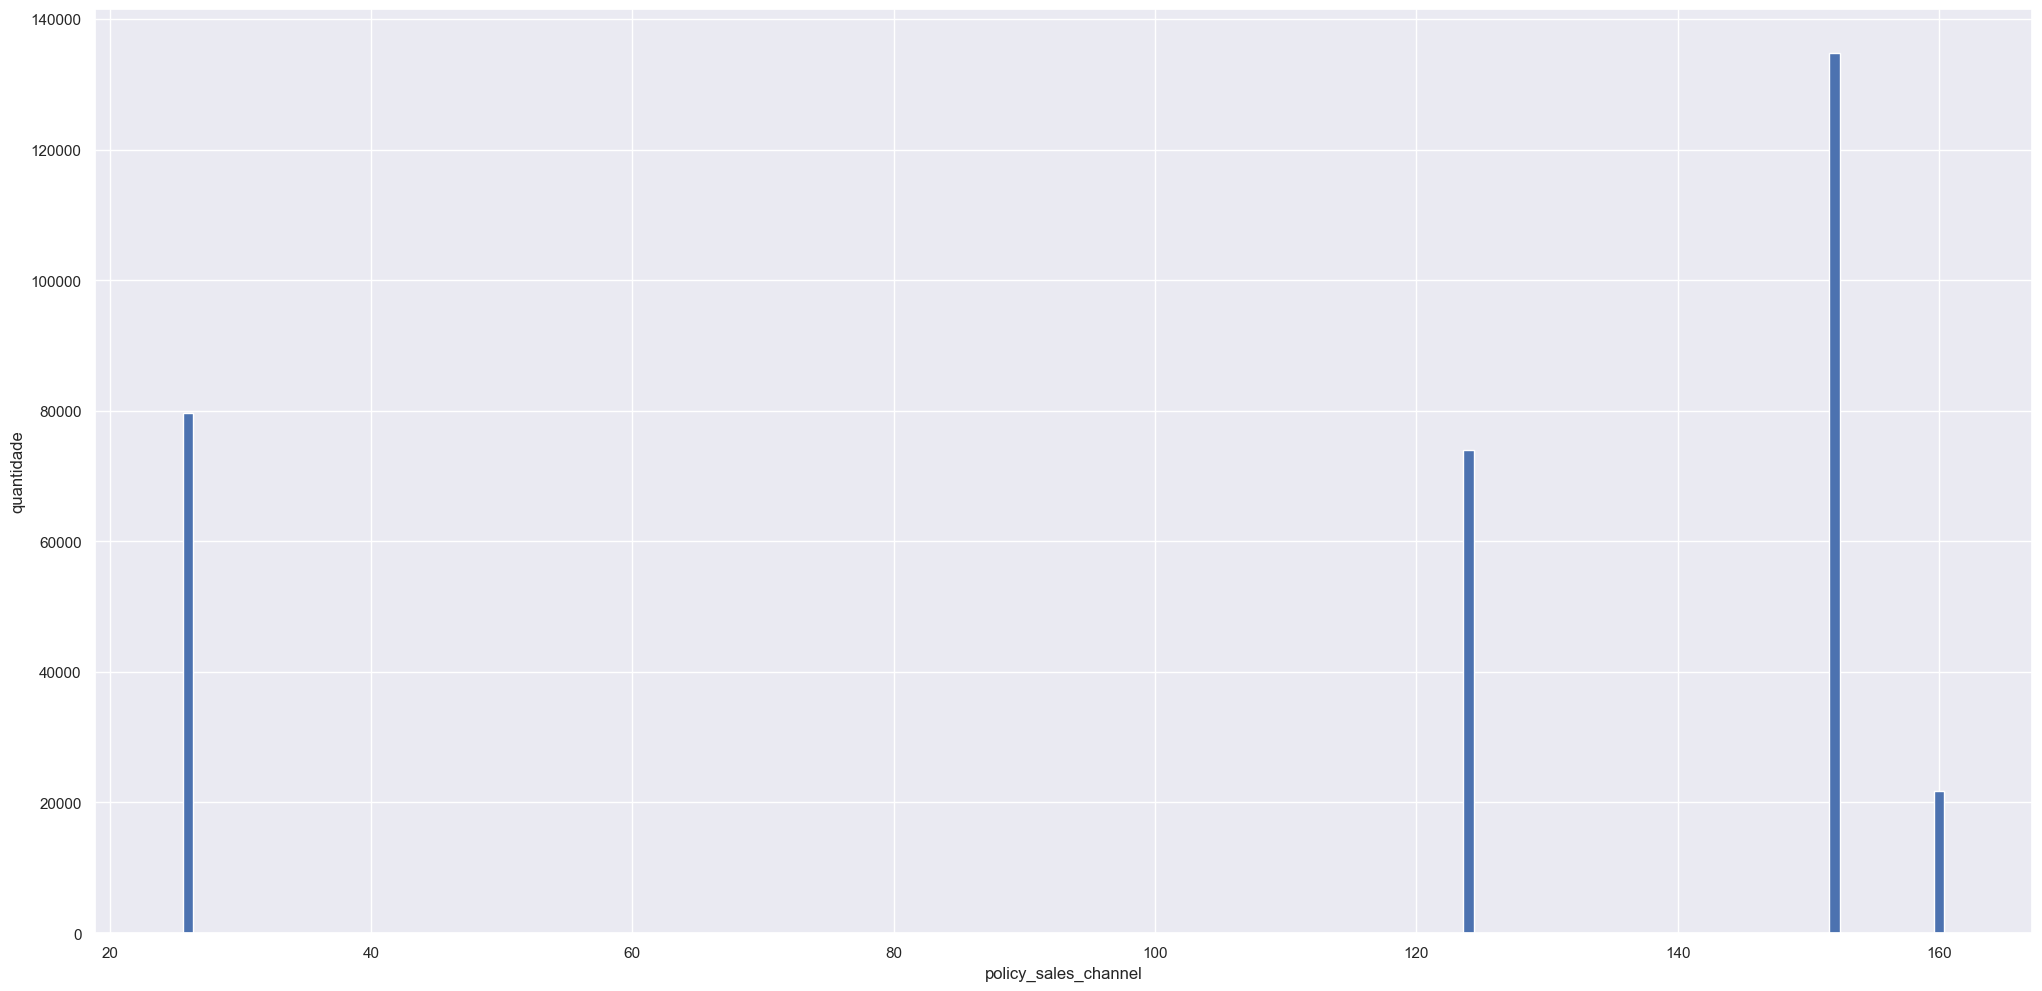

In [38]:
# Canais de comunicação com mais de 20 mil clientes
aux2 = aux1.loc[aux1['id']>=20000]
aux2
plt.bar(aux2['policy_sales_channel'], aux2['id']);
plt.xlabel('policy_sales_channel');
plt.ylabel('quantidade');
plt.show()

In [39]:
print('Quantidade de canais de comunicação com mais de 20 mil clientes: {}'.format(aux2.shape[0]) )

Quantidade de canais de comunicação com mais de 20 mil clientes: 4


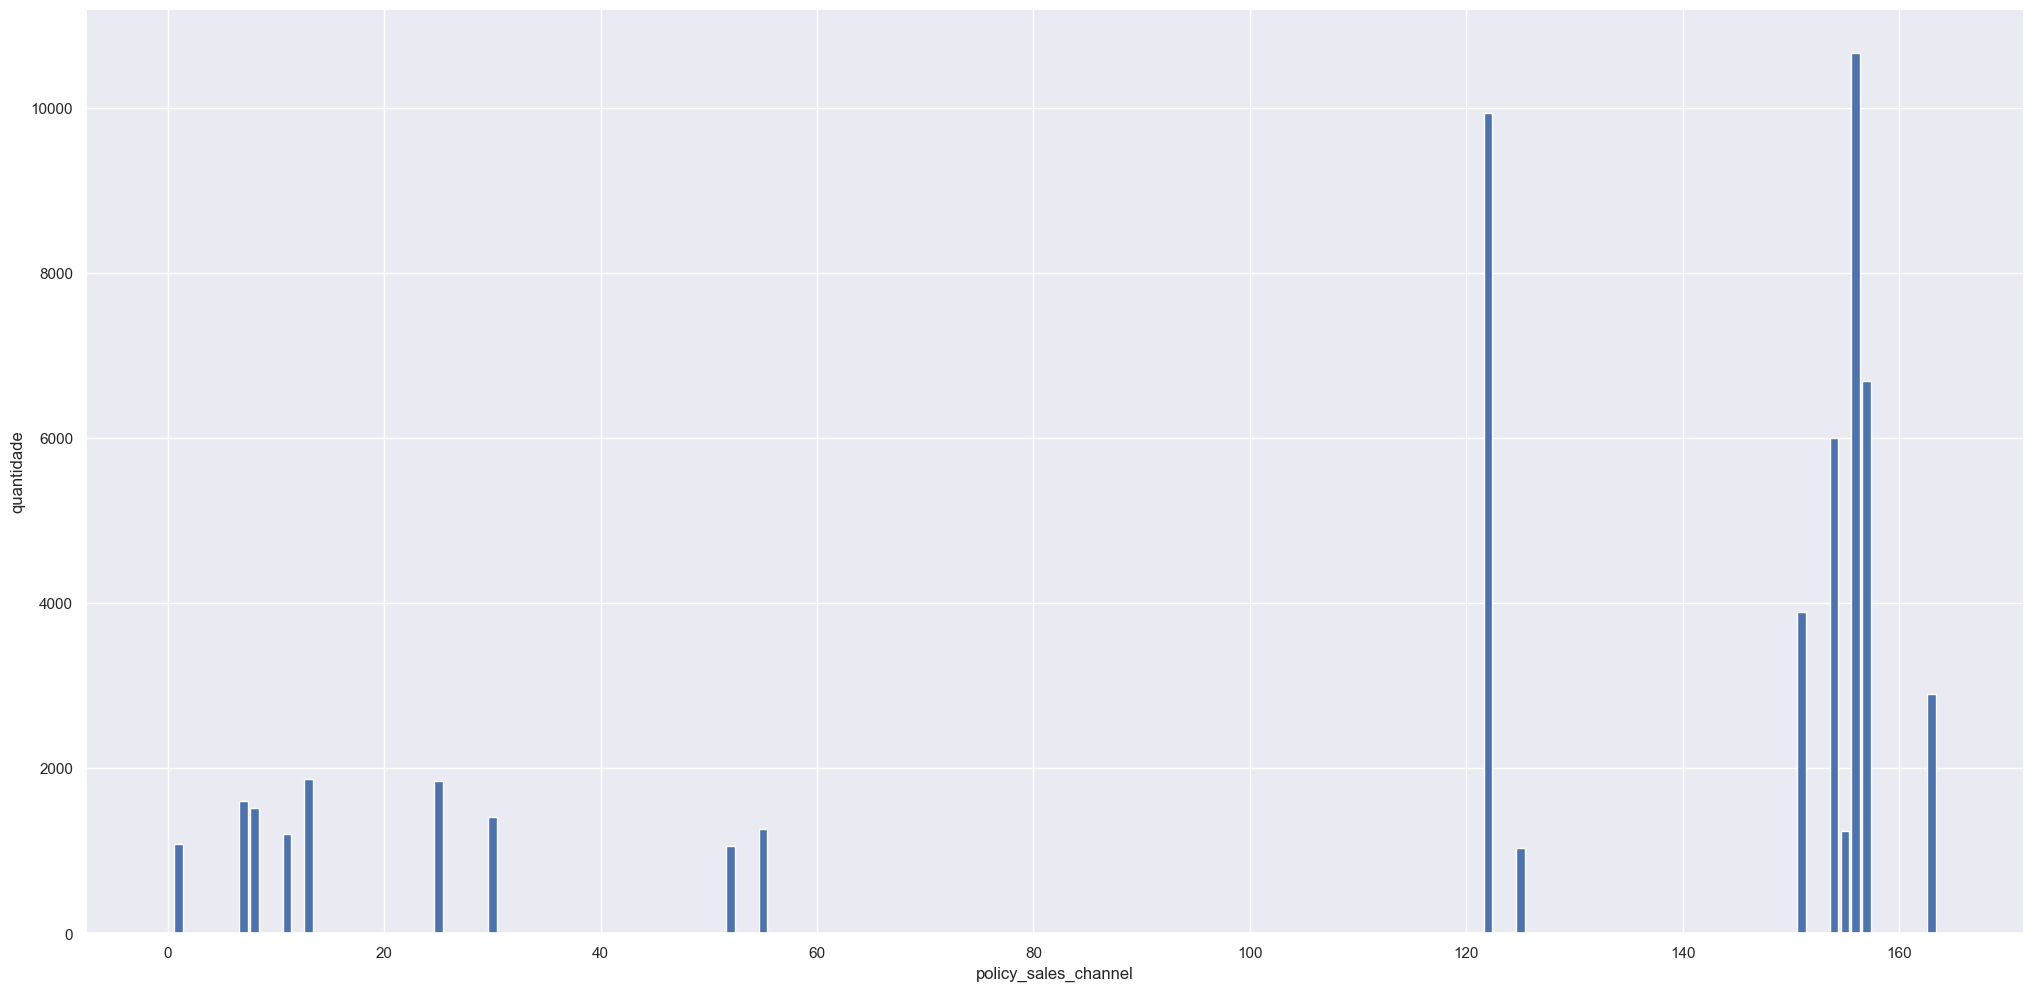

In [40]:
# Entre 1 mil e 20 mil clientes
aux2 = aux1.loc[(aux1['id']<20000)&(aux1['id']>=1000)]
aux2
plt.bar(aux2['policy_sales_channel'], aux2['id']);
plt.xlabel('policy_sales_channel');
plt.ylabel('quantidade');
plt.show()

In [41]:
print('Quantidade de canais de comunicação com 1 mil até 20 mil clientes: {}'.format(aux2.shape[0]) )

Quantidade de canais de comunicação com 1 mil até 20 mil clientes: 17


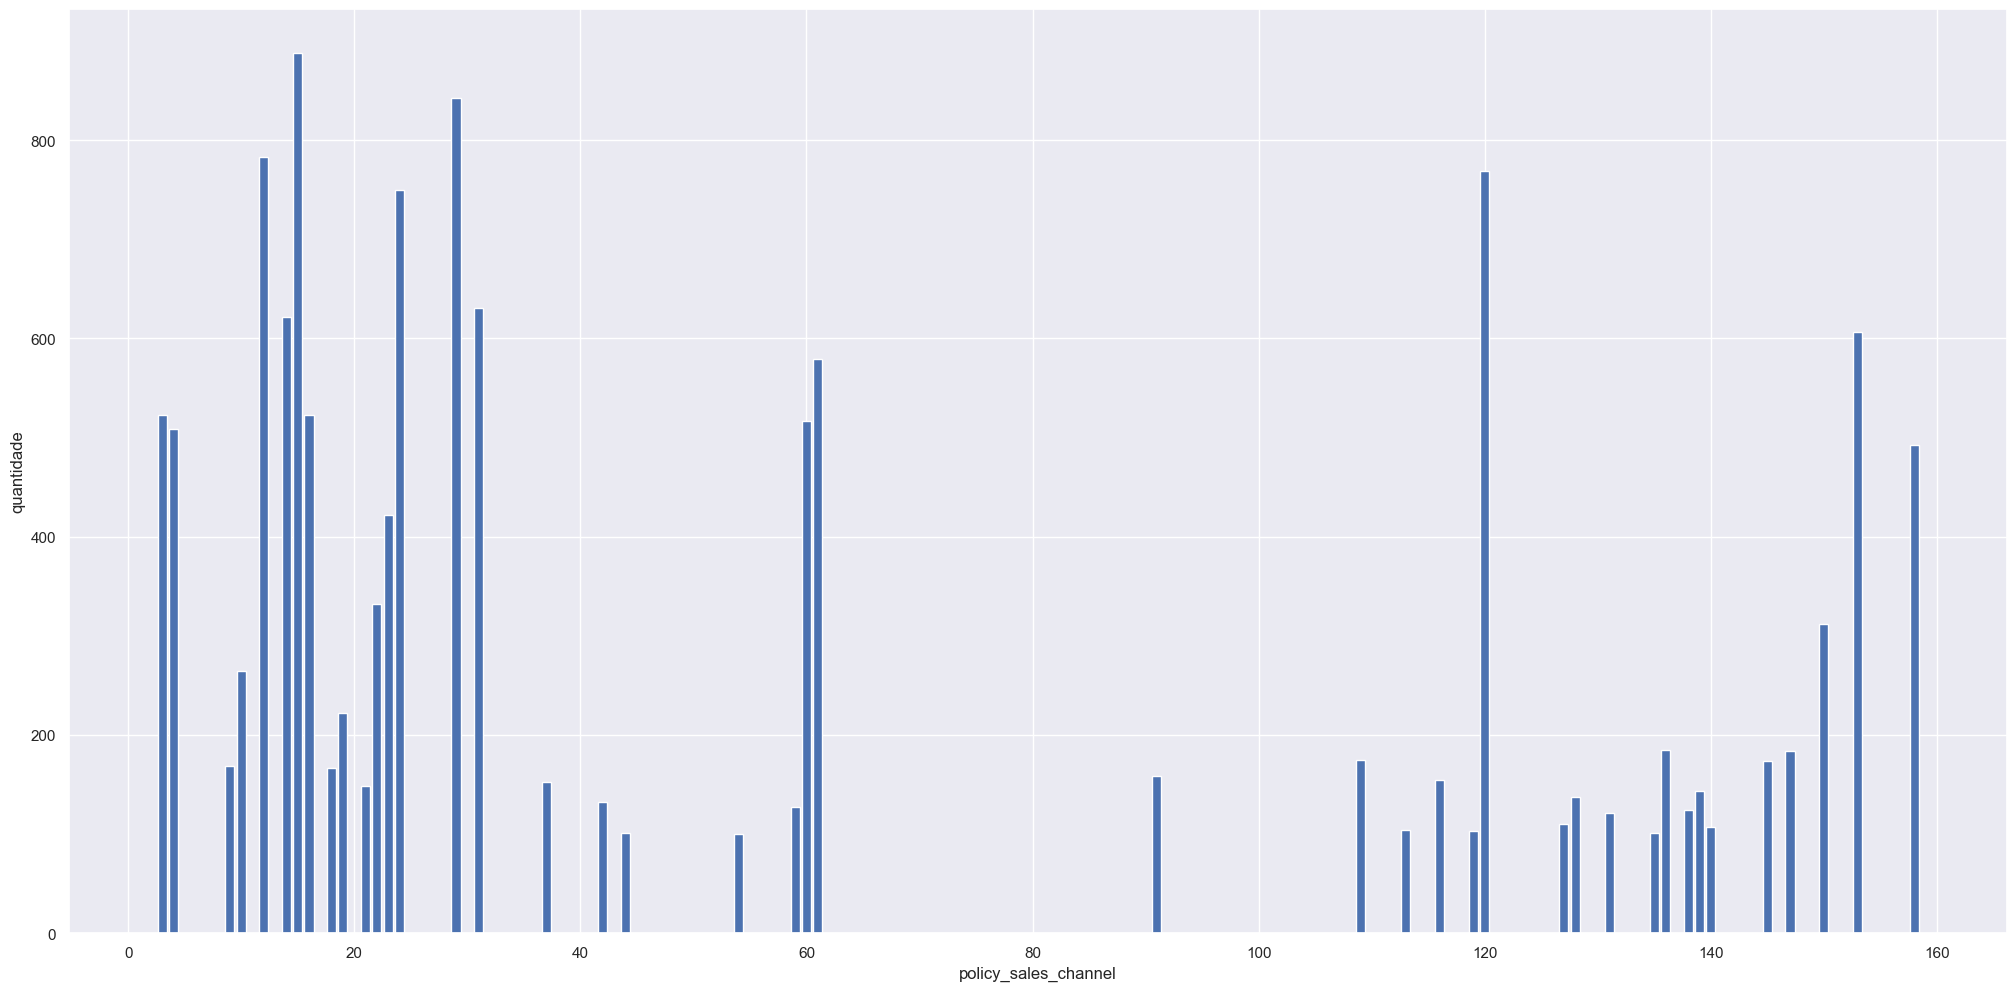

In [42]:
# Entre 100 e 1000 mil clientes
aux2 = aux1.loc[(aux1['id']<1000)&(aux1['id']>=100)]
aux2
plt.bar(aux2['policy_sales_channel'], aux2['id']);
plt.xlabel('policy_sales_channel');
plt.ylabel('quantidade');
plt.show()

In [43]:
print('Quantidade de canais de comunicação com 100 até 1 mil clientes: {}'.format(aux2.shape[0]) )

Quantidade de canais de comunicação com 100 até 1 mil clientes: 42


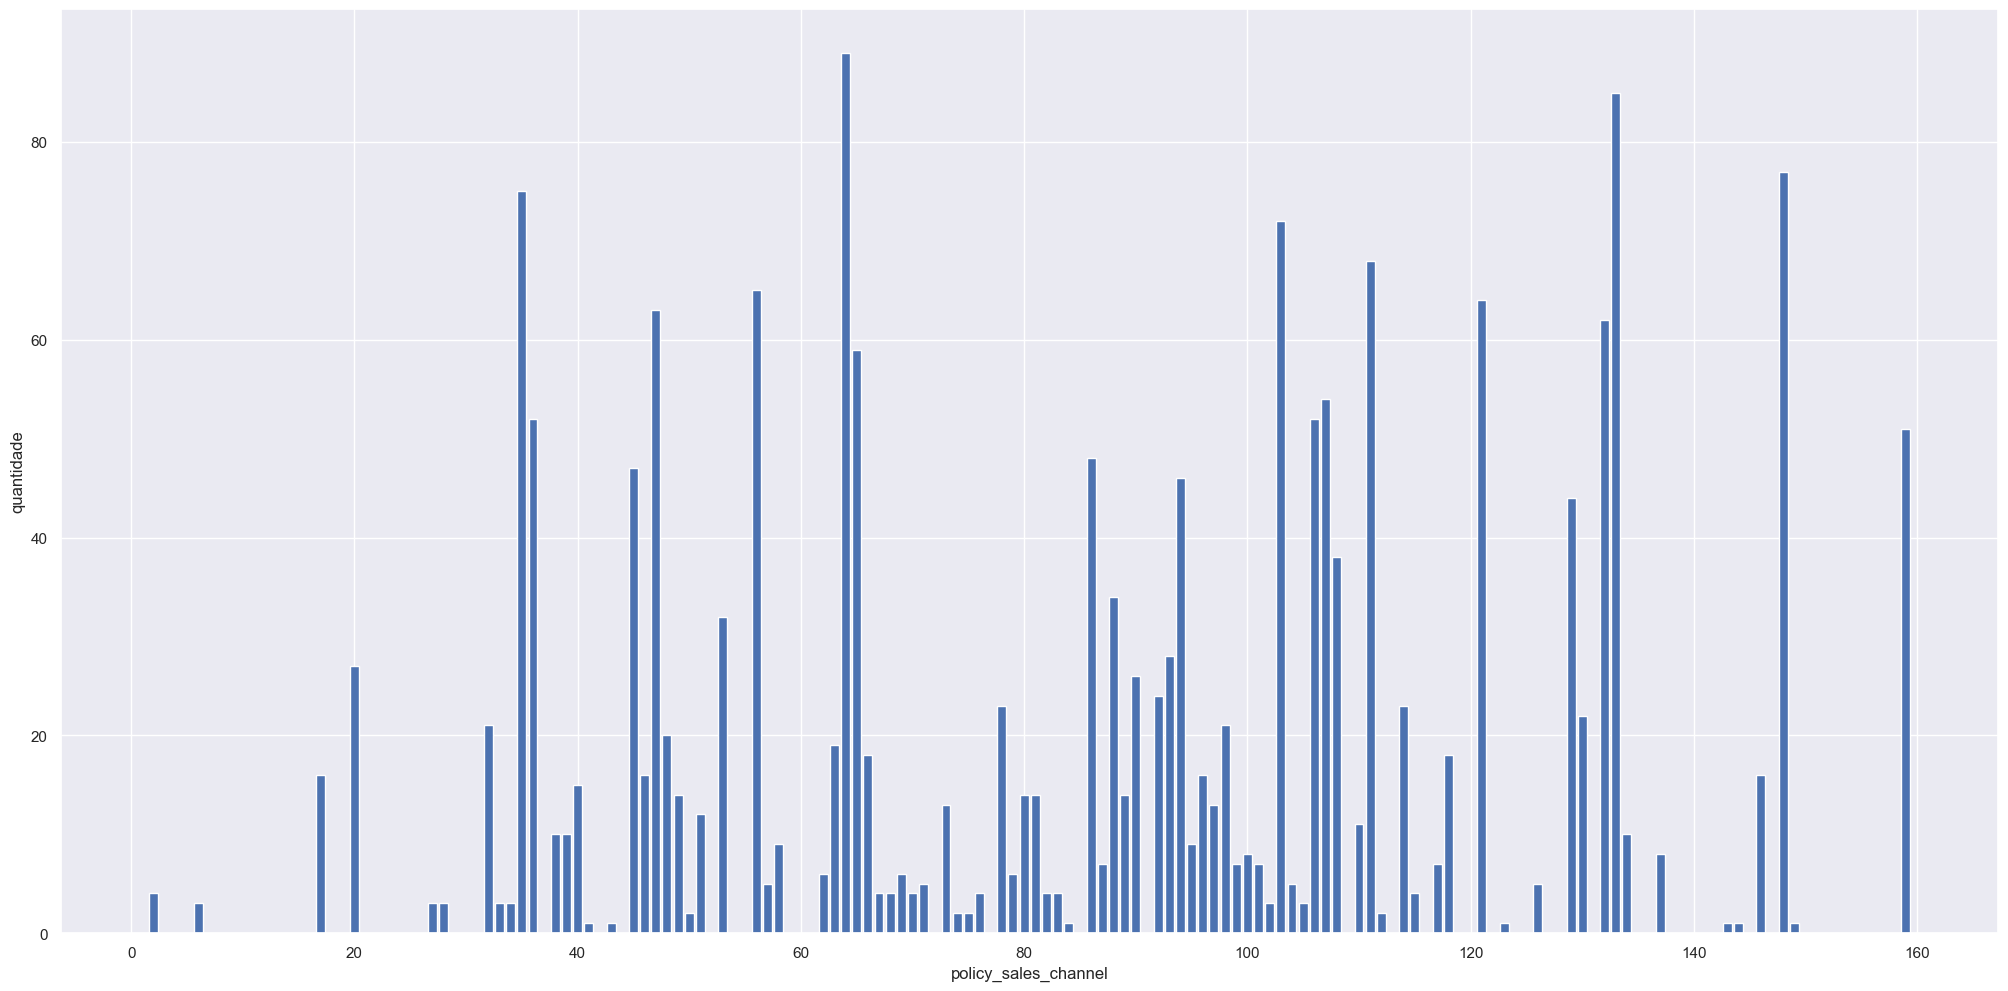

In [44]:
# Abaixo de 100 clientes
aux2 = aux1.loc[aux1['id']<100]
aux2
plt.bar(aux2['policy_sales_channel'], aux2['id']);
plt.xlabel('policy_sales_channel');
plt.ylabel('quantidade');
plt.show()

In [45]:
print('Quantidade de canais de comunicação com menos de 100 clientes: {}'.format(aux2.shape[0]) )

Quantidade de canais de comunicação com menos de 100 clientes: 92


**Quantidade de canais de comunicação e agrupamento de clientes**
Quantidade de canais de comunicação com mais de 20 mil clientes: 4
Quantidade de canais de comunicação com mais 1 mil até 20 mil clientes: 17
Quantidade de canais de comunicação com mais 100 até 1 mil clientes: 42
Quantidade de canais de comunicação com menos de 100 clientes: 92

#### Vehicle Damage

 * **1: Customer got his/her vehicle damaged in the past.**
 * **0 : Customer didn't get his/her vehicle damaged in the past**

In [46]:
df4['vehicle_damage'].value_counts()

1    192413
0    188696
Name: vehicle_damage, dtype: int64

In [47]:
df4['vehicle_damage'].value_counts(normalize = True)

1   0.50
0   0.50
Name: vehicle_damage, dtype: float64

* **192413 clientes (50.49%) que sofreram danos nos seus veículos no passado.**
* **188696 clientes (49.51%) que não sofreram danos nos seus veículos no passado.**

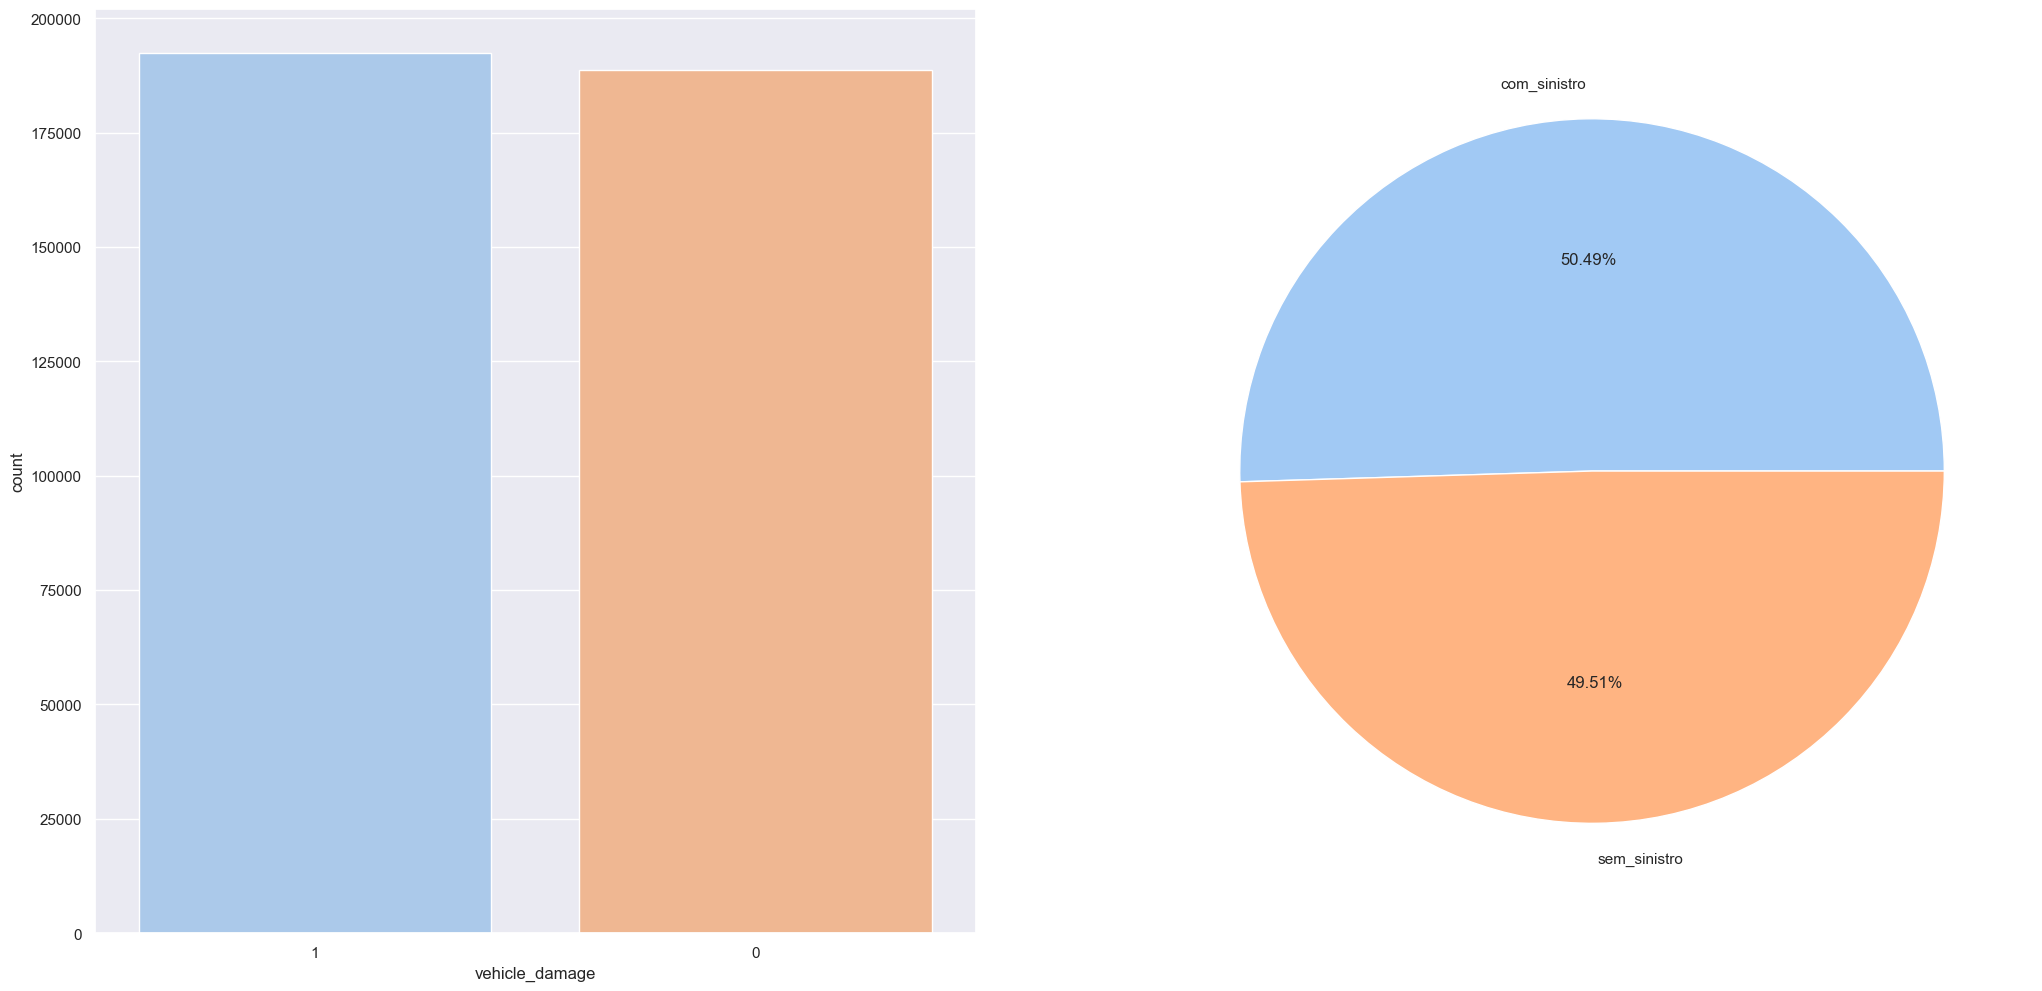

In [48]:
# vehicle_damage
plt.subplot(1,2,1)
sns.countplot(data=df4,x='vehicle_damage',order = [1,0], palette = 'pastel');

#pie chart
aux1 = percentage_pandas(df4[ df4['vehicle_damage']==1 ], df4 )
aux2 = percentage_pandas(df4[ df4['vehicle_damage']==0 ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['com_sinistro','sem_sinistro']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

## 4.2 Bivariate Analysis

**Análise de cada variável e a sua relação com a variável resposta do problema**

### gender

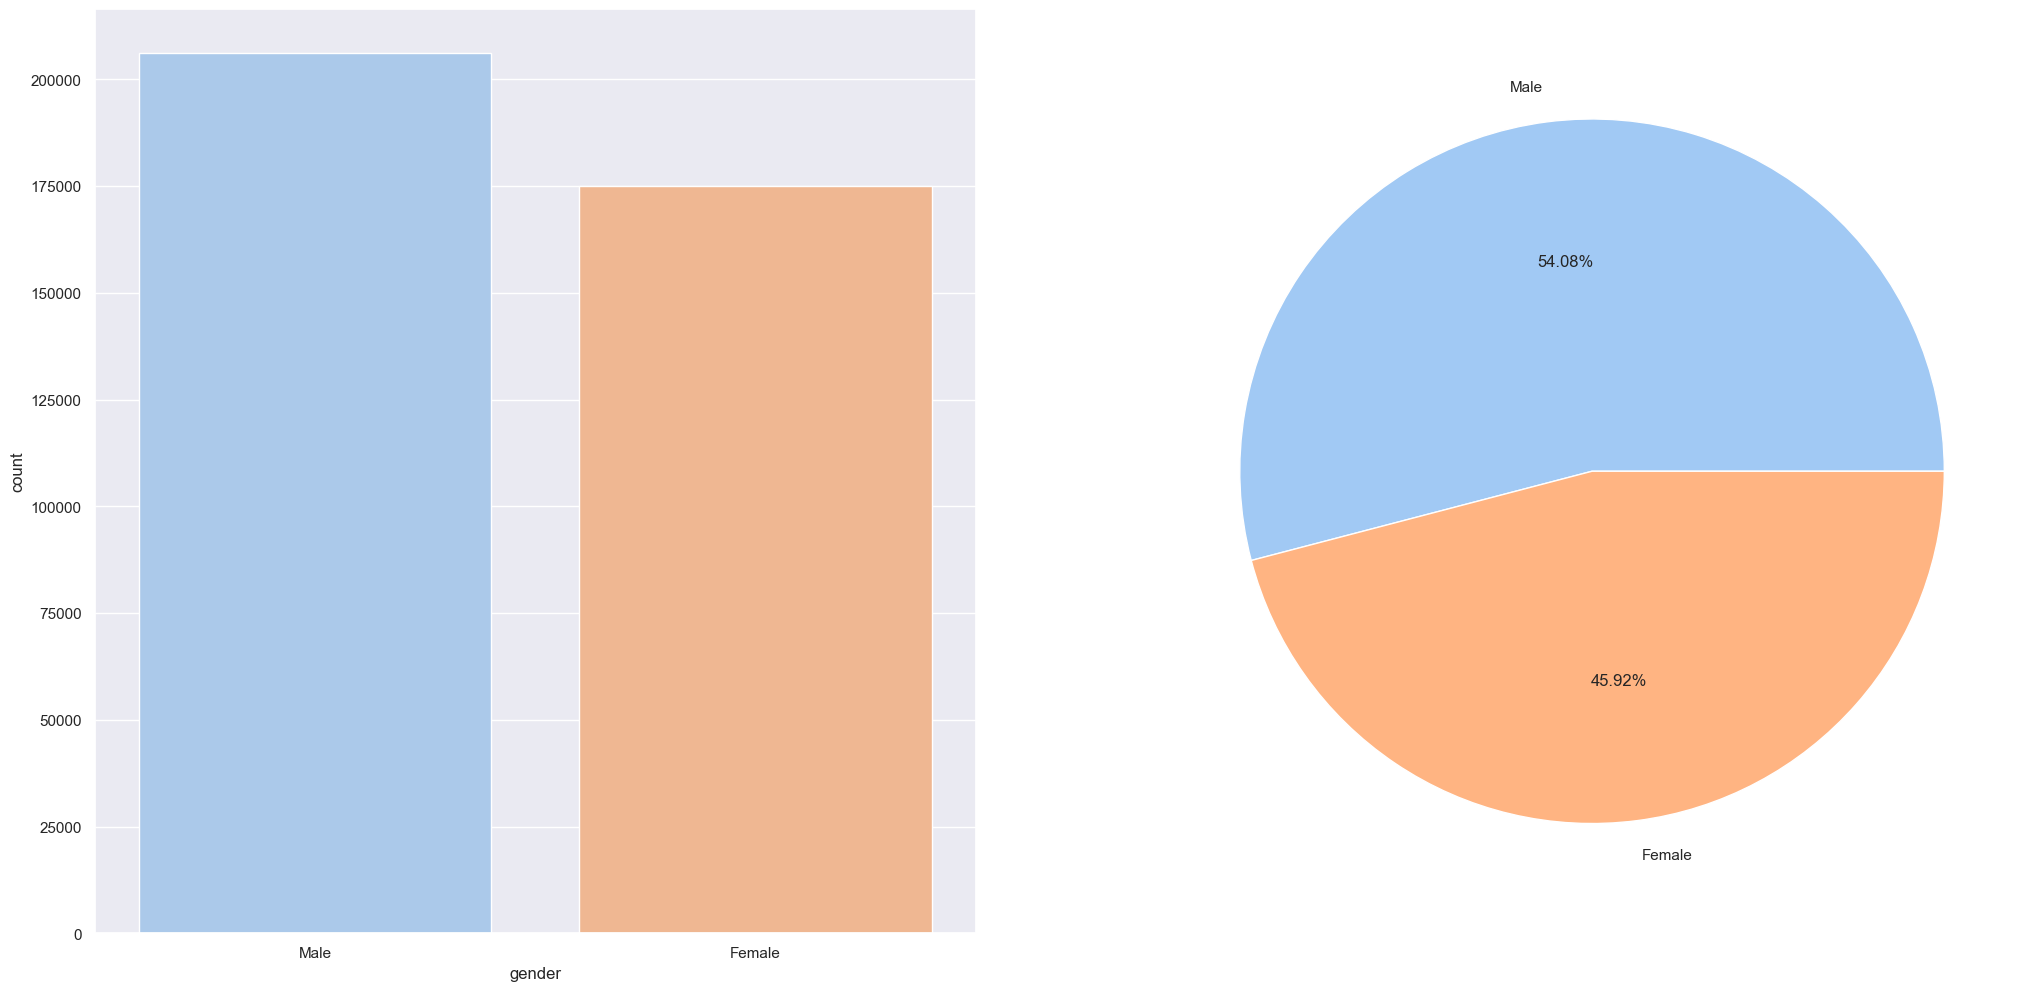

In [49]:
# Gender
plt.subplot(1,2,1)
sns.countplot(data=df4,x='gender',order = ['Male','Female'], palette = 'pastel');

#pie chart
aux1 = percentage_pandas(df4[ df4['gender']=='Male' ], df4 )
aux2 = percentage_pandas(df4[ df4['gender']=='Female' ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['Male','Female']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

### Hypothes 1. Clientes do sexo masculino tem mais interesse em contratar o seguro veicular  
Hypothes 1. True

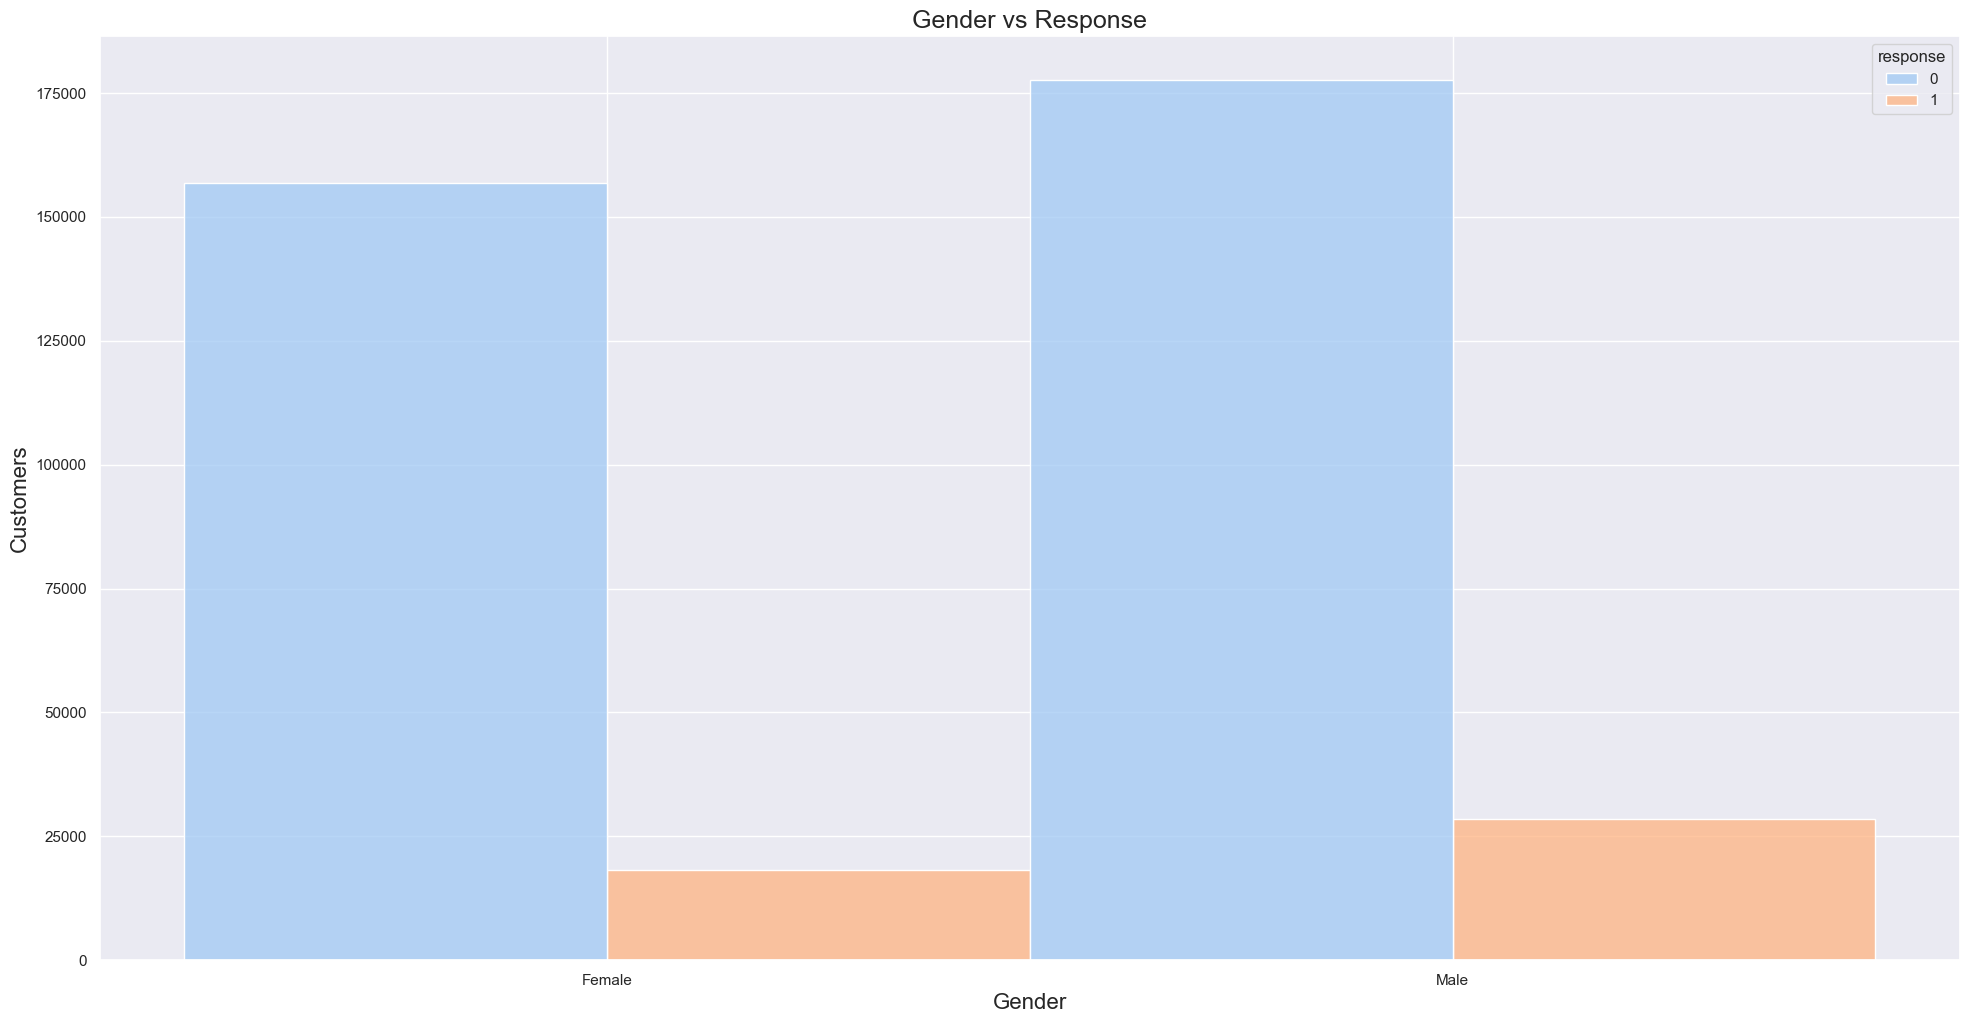

In [50]:
aux1 = df4[['gender','response']].loc[ df4['gender']=='Male'].copy()
aux2 = df4[['gender','response']].loc[ df4['gender']=='Female'].copy()

fig = plt.figure( figsize = (24,12) )
specs = gridspec.GridSpec( ncols = 1, nrows = 1, figure = fig )

ax1 = fig.add_subplot( specs[ 0,0] )
ax1.set_xlabel('Gender',fontsize=16)
ax1.set_ylabel("Customers",fontsize=16)
ax1.set_title("Gender vs Response", size = 18)

sns.histplot( x='gender', hue = 'response', data=aux2 ,multiple='dodge',ax = ax1, palette = 'pastel'  );
sns.histplot( x='gender', hue = 'response', data=aux1 ,multiple='dodge',ax = ax1, palette = 'pastel'  );

/home/deivison/Documentos/projetos/pa_04/venv_pa_04/lib/python3.10/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


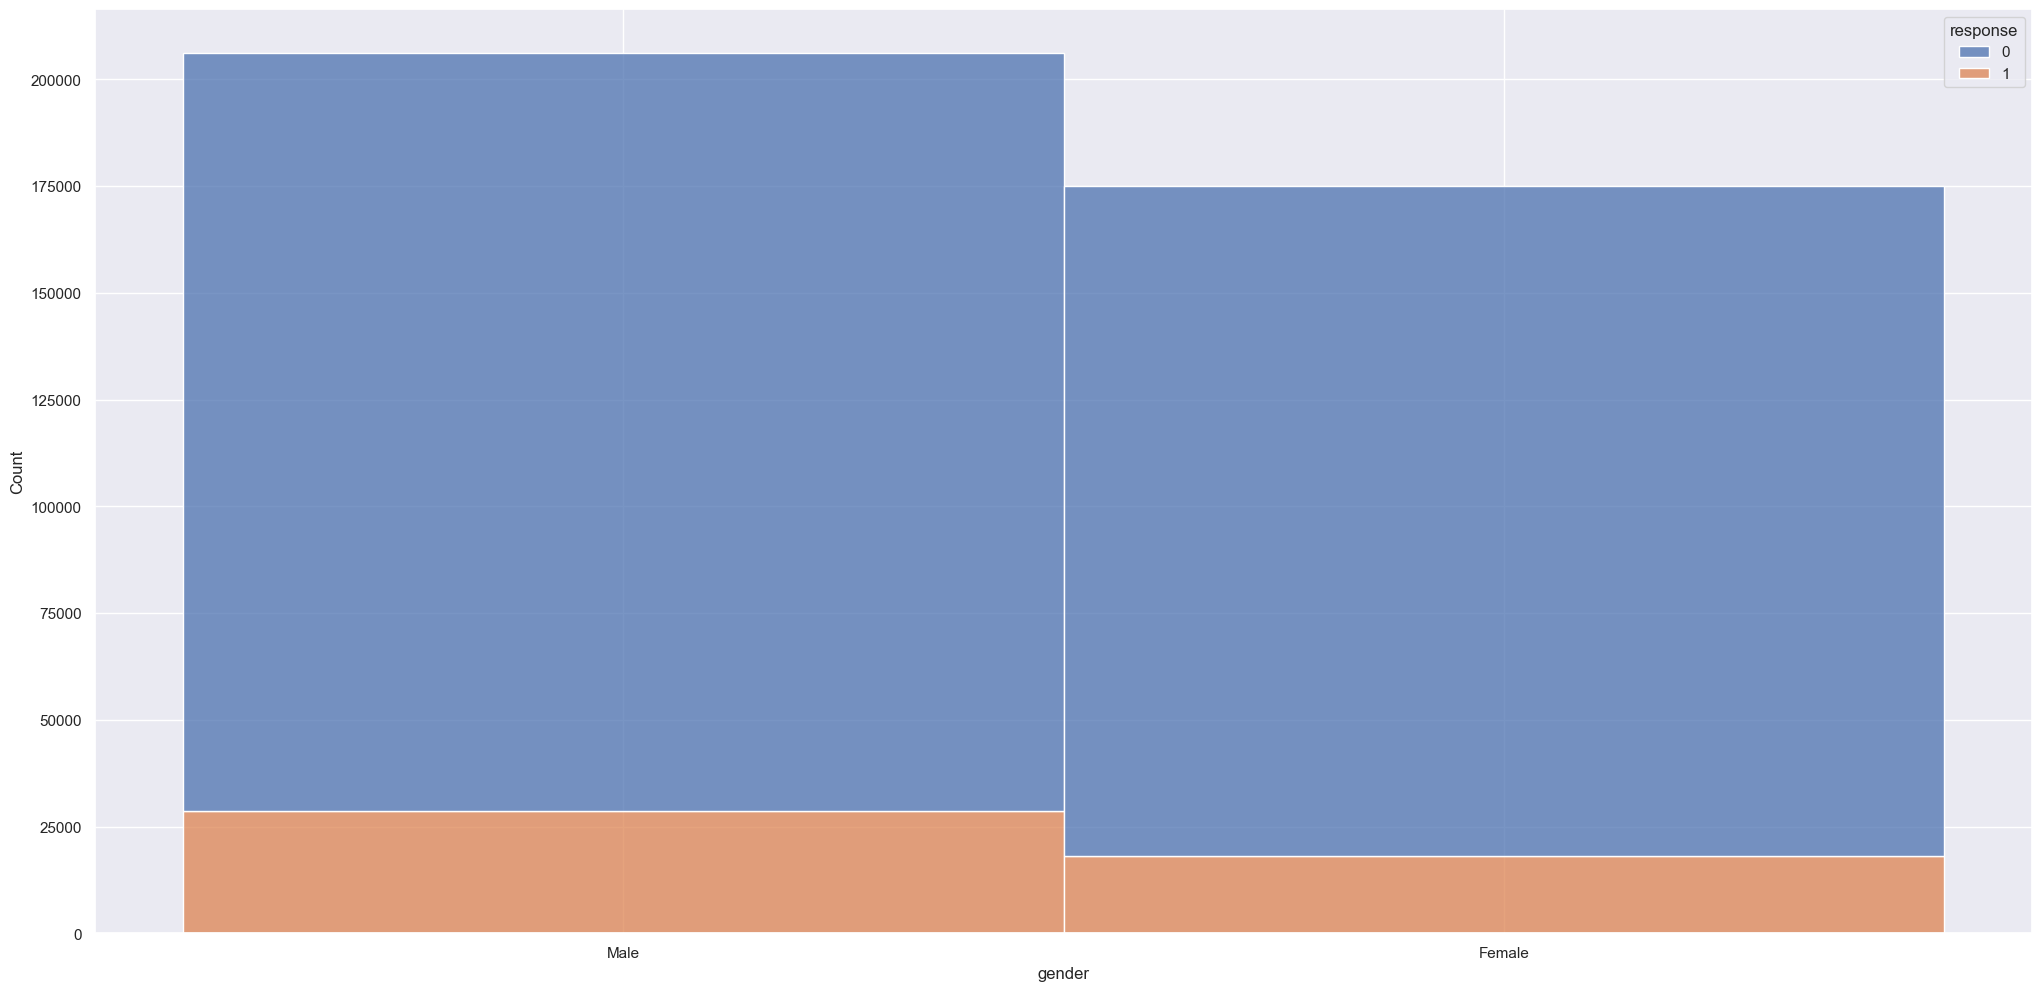

In [51]:
sns.histplot( x='gender', hue = 'response',multiple='stack', data=df4 );

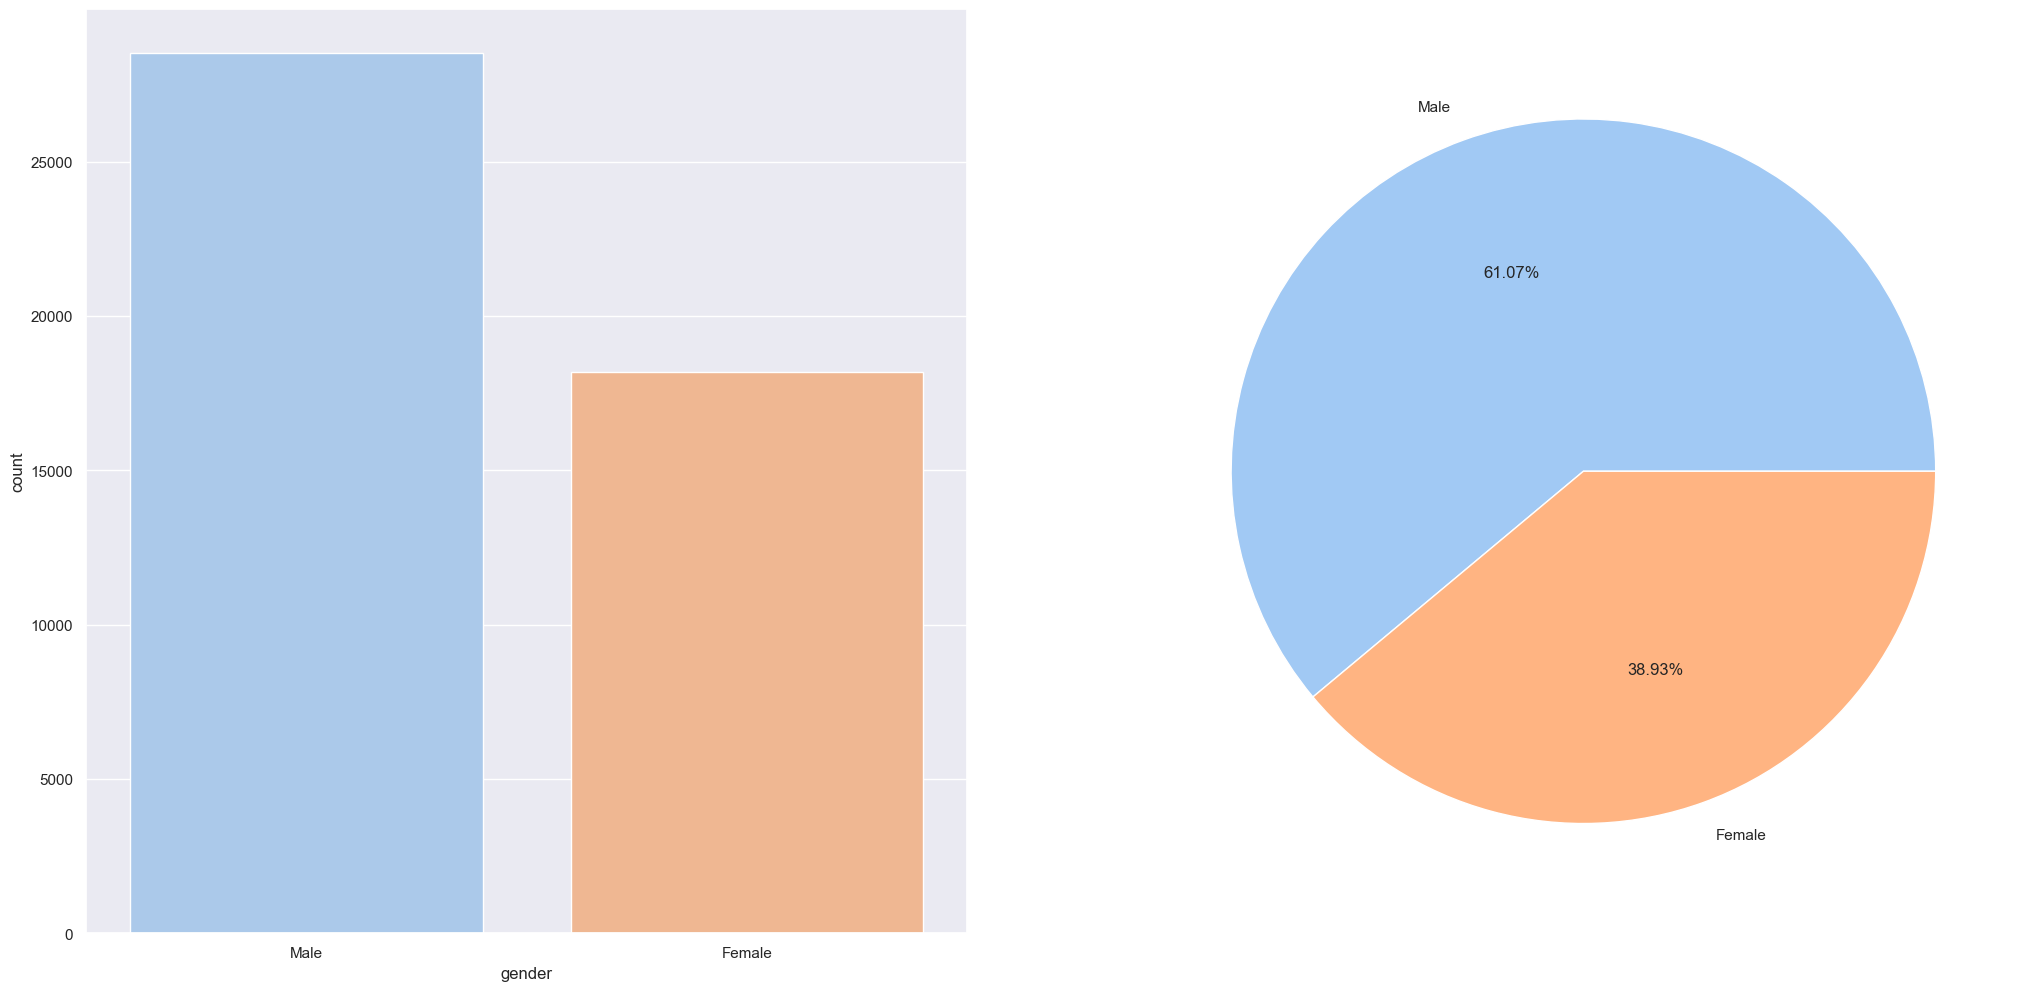

In [52]:
# Interested Customers by gender
plt.subplot(1,2,1)
aux5 = df4.loc[df4['response']==1]
sns.countplot(data = aux5, x='gender',order = ['Male','Female'], palette = 'pastel');

#pie chart
aux1 = percentage_pandas(aux5[ aux5['gender']=='Male' ],   aux5 )
aux2 = percentage_pandas(aux5[ aux5['gender']=='Female' ], aux5 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['Male','Female']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

* **61% dos clientes que responderam sim na pesquisa de interesse eram do sexo masculino.**

### Vehicle_damage

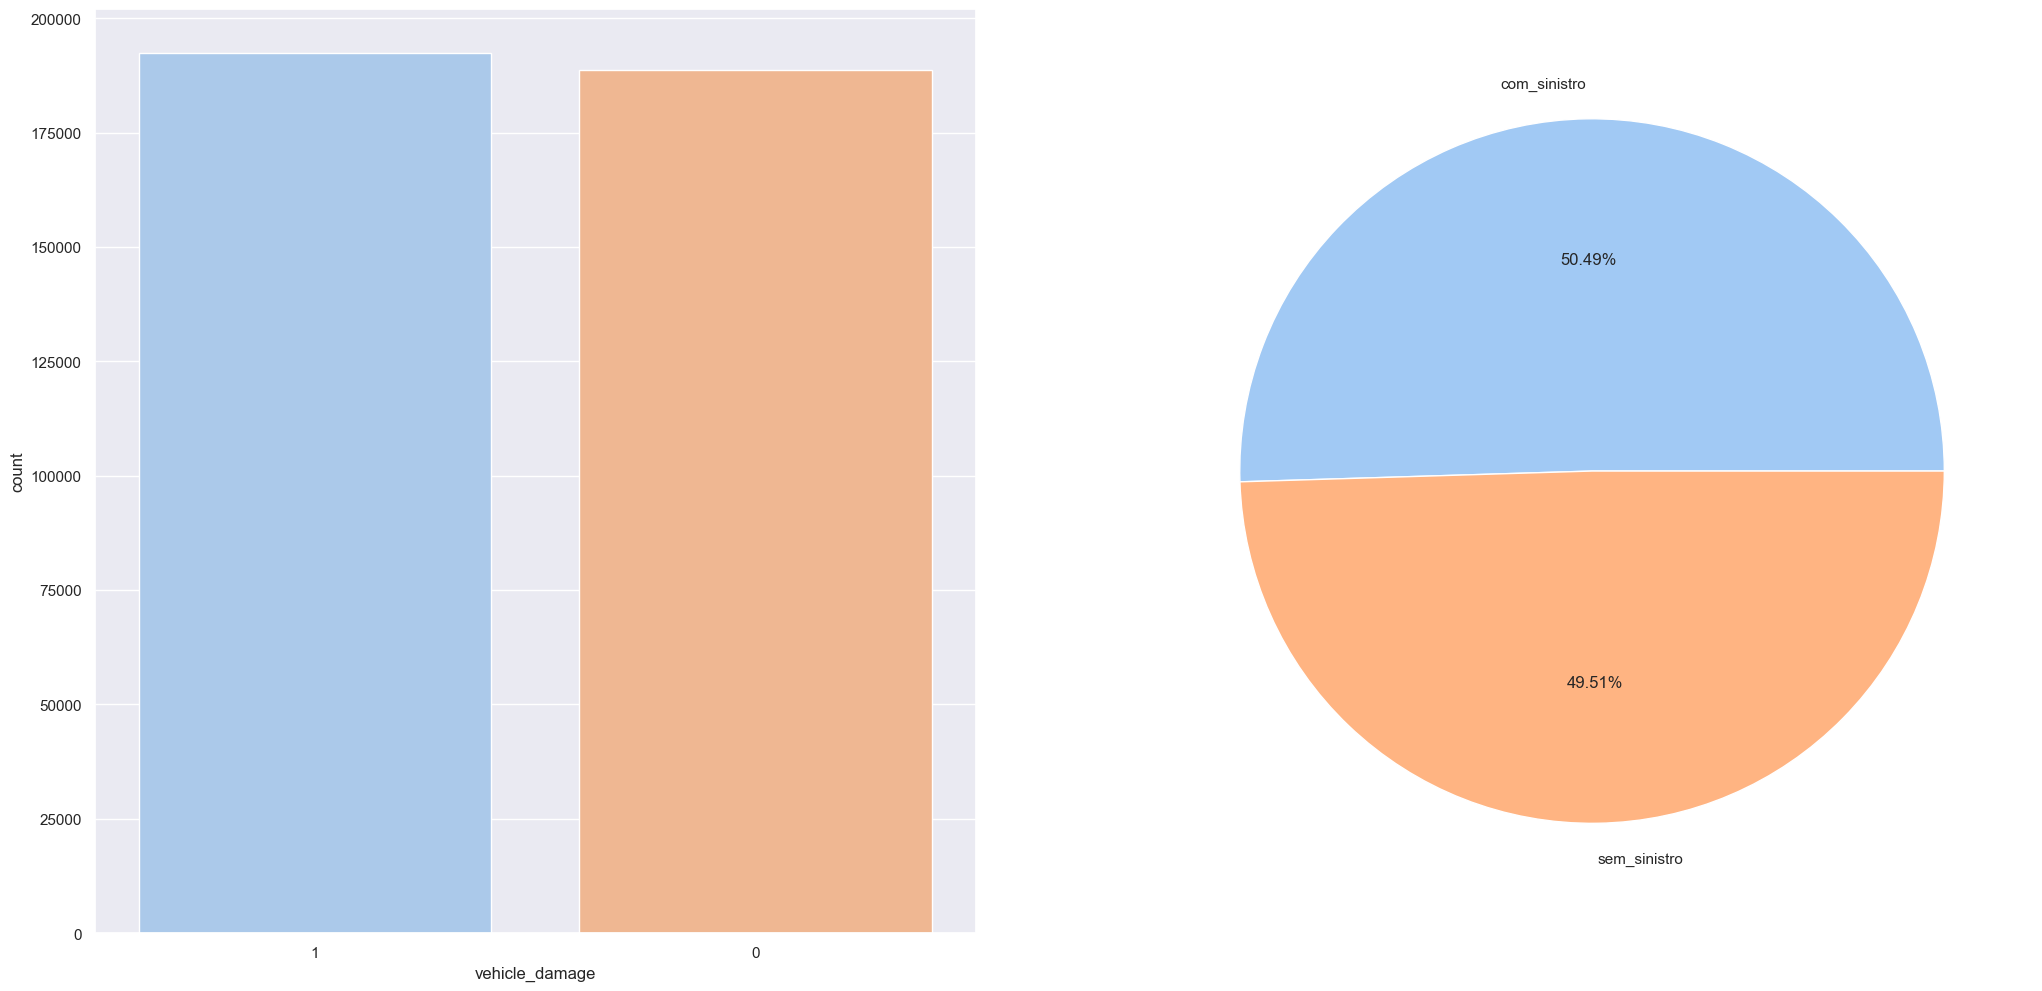

In [53]:
# vehicle_damage
plt.subplot(1,2,1)
sns.countplot(data=df4,x='vehicle_damage',order = [1,0], palette = 'pastel');

#pie chart
aux1 = percentage_pandas(df4[ df4['vehicle_damage']==1 ], df4 )
aux2 = percentage_pandas(df4[ df4['vehicle_damage']==0 ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['com_sinistro','sem_sinistro']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

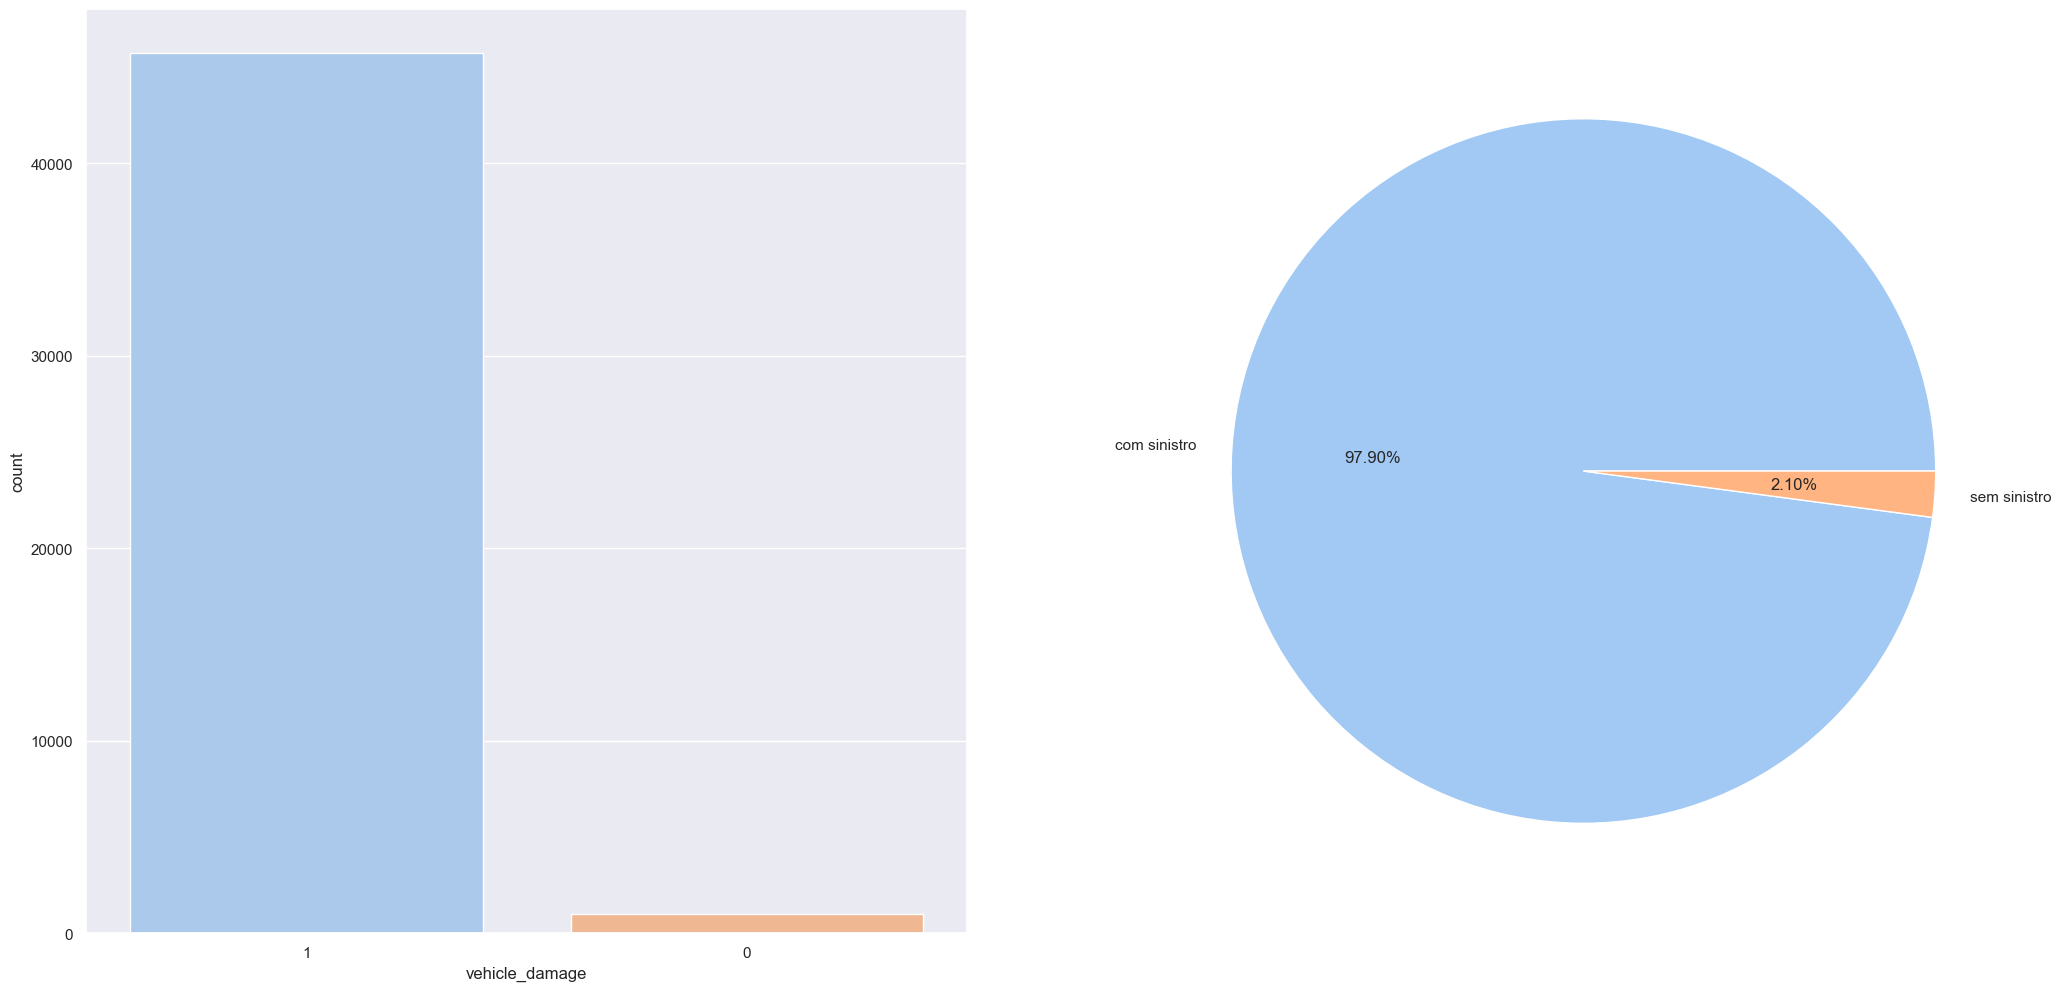

In [54]:
# All Interested Customers - how many vehicle damage

plt.subplot(1,2,1)

# only response = 1
aux5 = df4.loc[df4['response']==1]
sns.countplot(data = aux5, x='vehicle_damage',order = [1,0], palette = 'pastel');

#pie chart
aux1 = percentage_pandas(aux5[ aux5['vehicle_damage']==1 ],   aux5 )
aux2 = percentage_pandas(aux5[ aux5['vehicle_damage']==0 ], aux5 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['com sinistro','sem sinistro']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

* **97.90% de todos clientes que respoderam sim na pesquisa de interesse sofreram danos nos seus veículos no passado**
* **2.10%  de todos clientes que respoderam sim na pesquisa de interesse não sofreram danos nos seus veículos no passado**

### Hypothese 2. Clientes que já se envolveram em sinistros tem mais interesse em contratar o seguro veicular
Hypothese 2. True

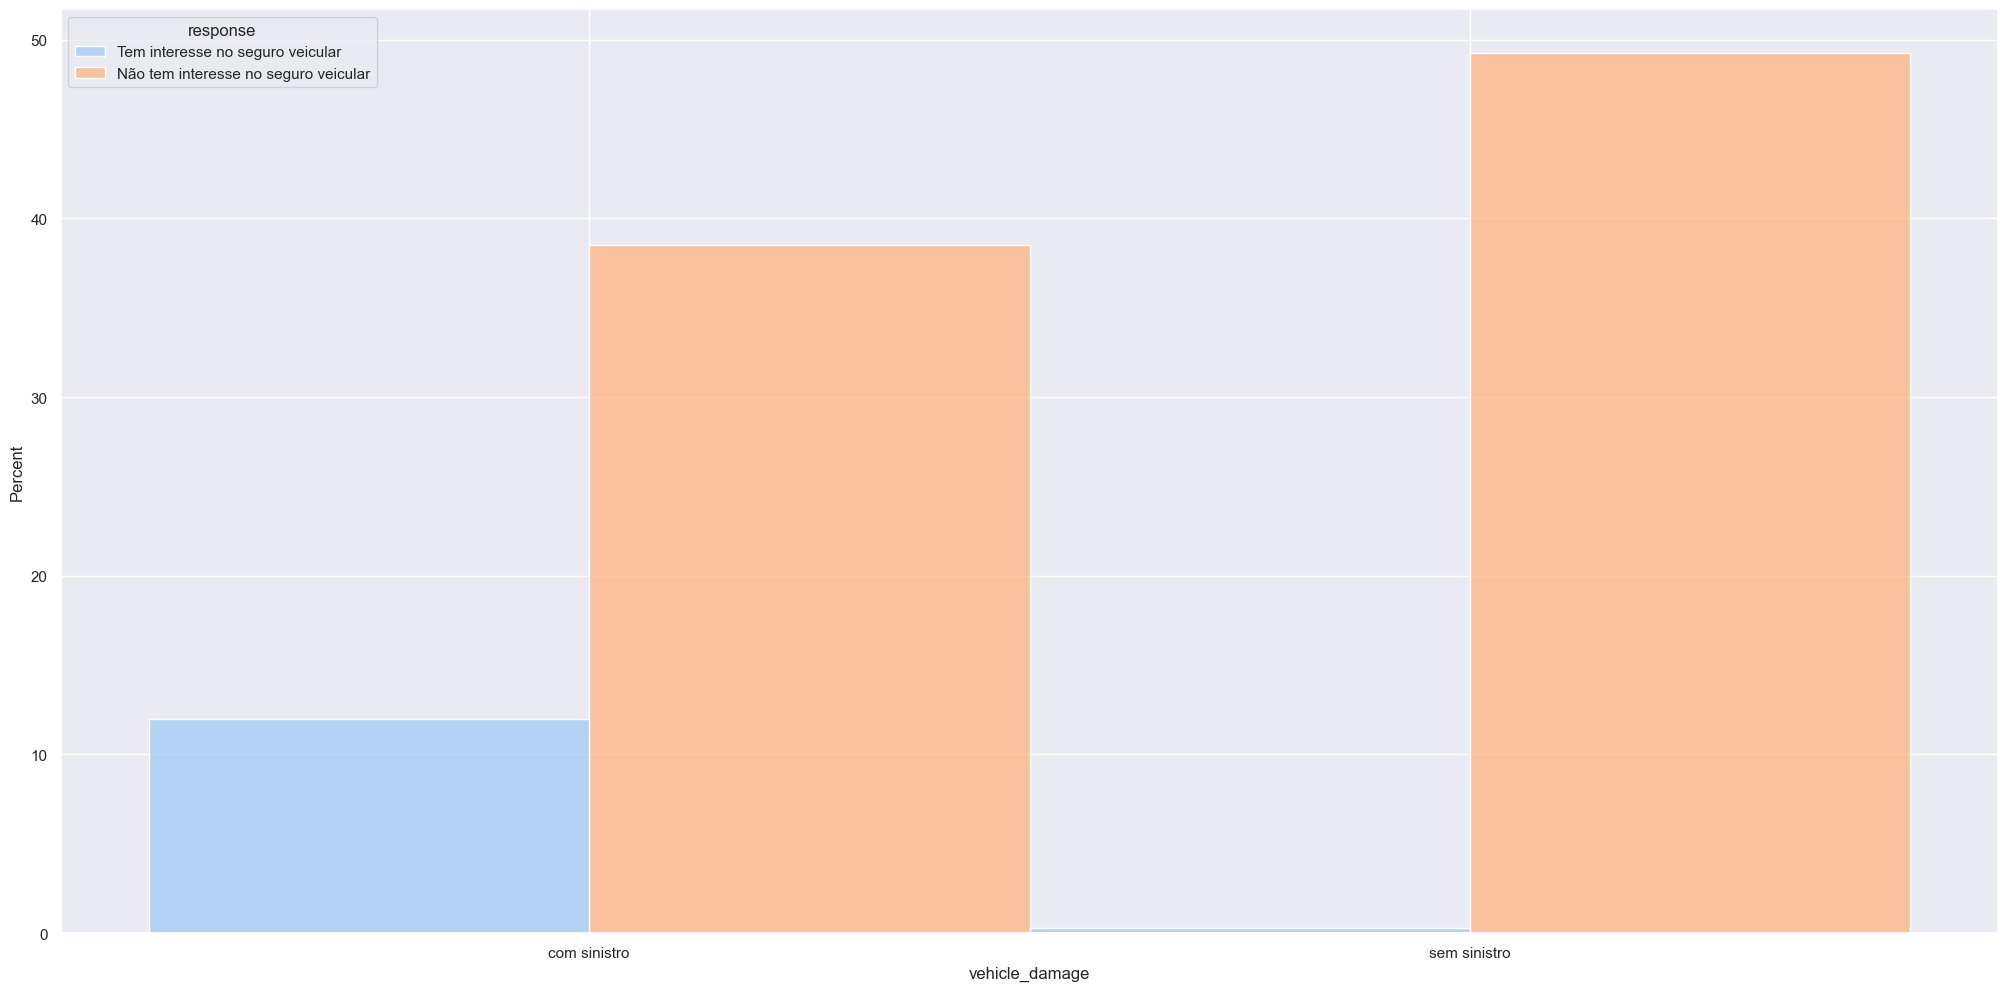

In [55]:
# percentual
aux1 = df4[['vehicle_damage','response']].copy()
aux1['vehicle_damage'] = aux1['vehicle_damage'].apply( lambda x: 'com sinistro' if x == 1 else 'sem sinistro')
aux1['response'] = aux1['response'].apply( lambda x: 'Tem interesse no seguro veicular' if x == 1 else 'Não tem interesse no seguro veicular')
sns.histplot( x='vehicle_damage', hue = 'response', data=aux1 ,multiple='dodge', palette = 'pastel', stat = 'percent' );

In [56]:
# vehicle_damage vs response - count
pd.crosstab(aux1['vehicle_damage'], aux1['response'] )

response,Não tem interesse no seguro veicular,Tem interesse no seguro veicular
vehicle_damage,,
com sinistro,146685,45728
sem sinistro,187714,982


In [57]:
# vehicle_damage vs response - percentual
pd.crosstab( aux1['vehicle_damage'], aux1['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,Não tem interesse no seguro veicular,Tem interesse no seguro veicular
vehicle_damage,,
com sinistro,0.76,0.24
sem sinistro,0.99,0.01


* **1% dos clientes que não sofreram danos nos seus veículos no passado responderam que tem interesse na contratação do seguro veícular.**
* **24% dos clientes que sofreram danos nos seus veículos no passado responderam que tem interesse na contratação do seguro veícular.**

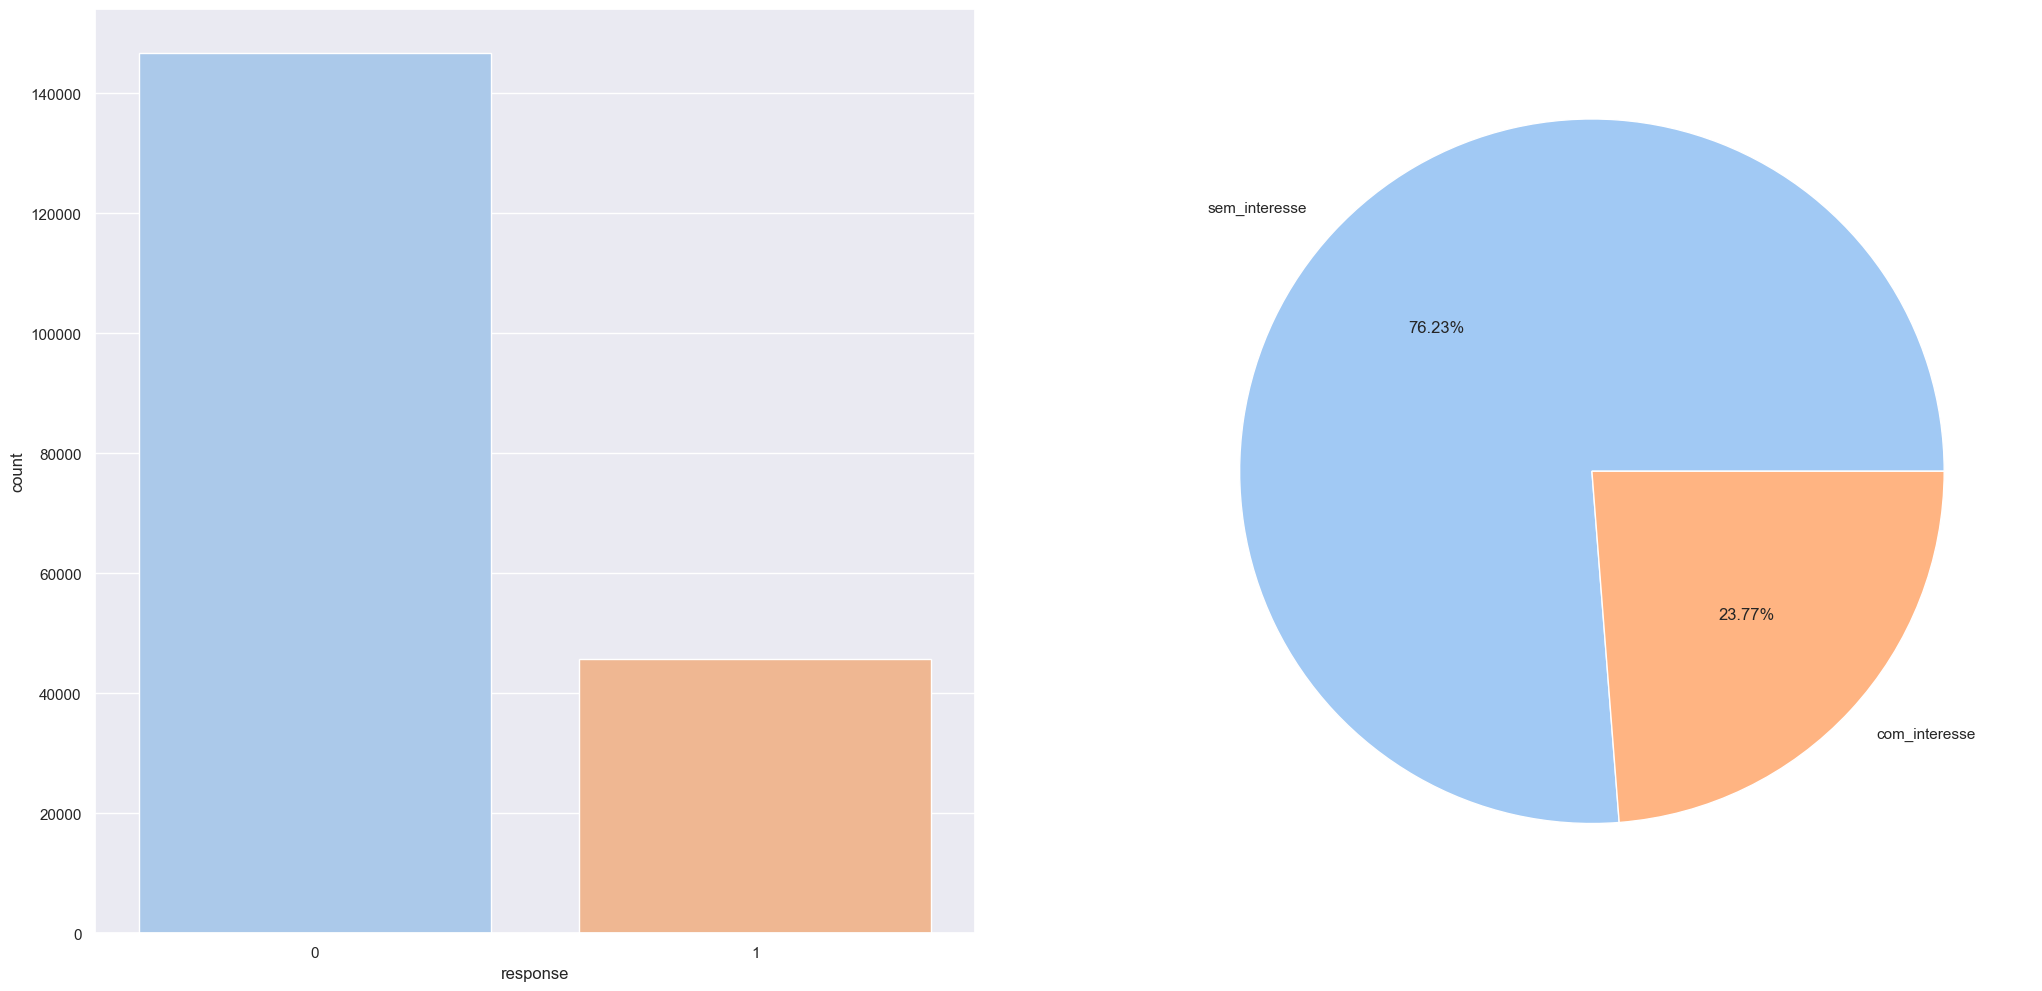

In [58]:
#  vehicle damage x customers interested
plt.subplot(1,2,1)

# all vehicle_damage = 1
aux5 = df4.loc[df4['vehicle_damage']==1]
sns.countplot(data = aux5, x='response',order = [0,1], palette = 'pastel');

#pie chart
aux1 = percentage_pandas(aux5[ aux5['response']==0 ],   aux5 )
aux2 = percentage_pandas(aux5[ aux5['response']==1 ], aux5 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['sem_interesse','com_interesse']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

* **76% dos clientes que sofreram danos nos seus veículos no passado responderam que não tem interesse na contratação do seguro veícular.**
* **24% dos clientes que sofreram danos nos seus veículos no passado responderam que tem interesse na contratação do seguro veícular.**

### Driving Licence

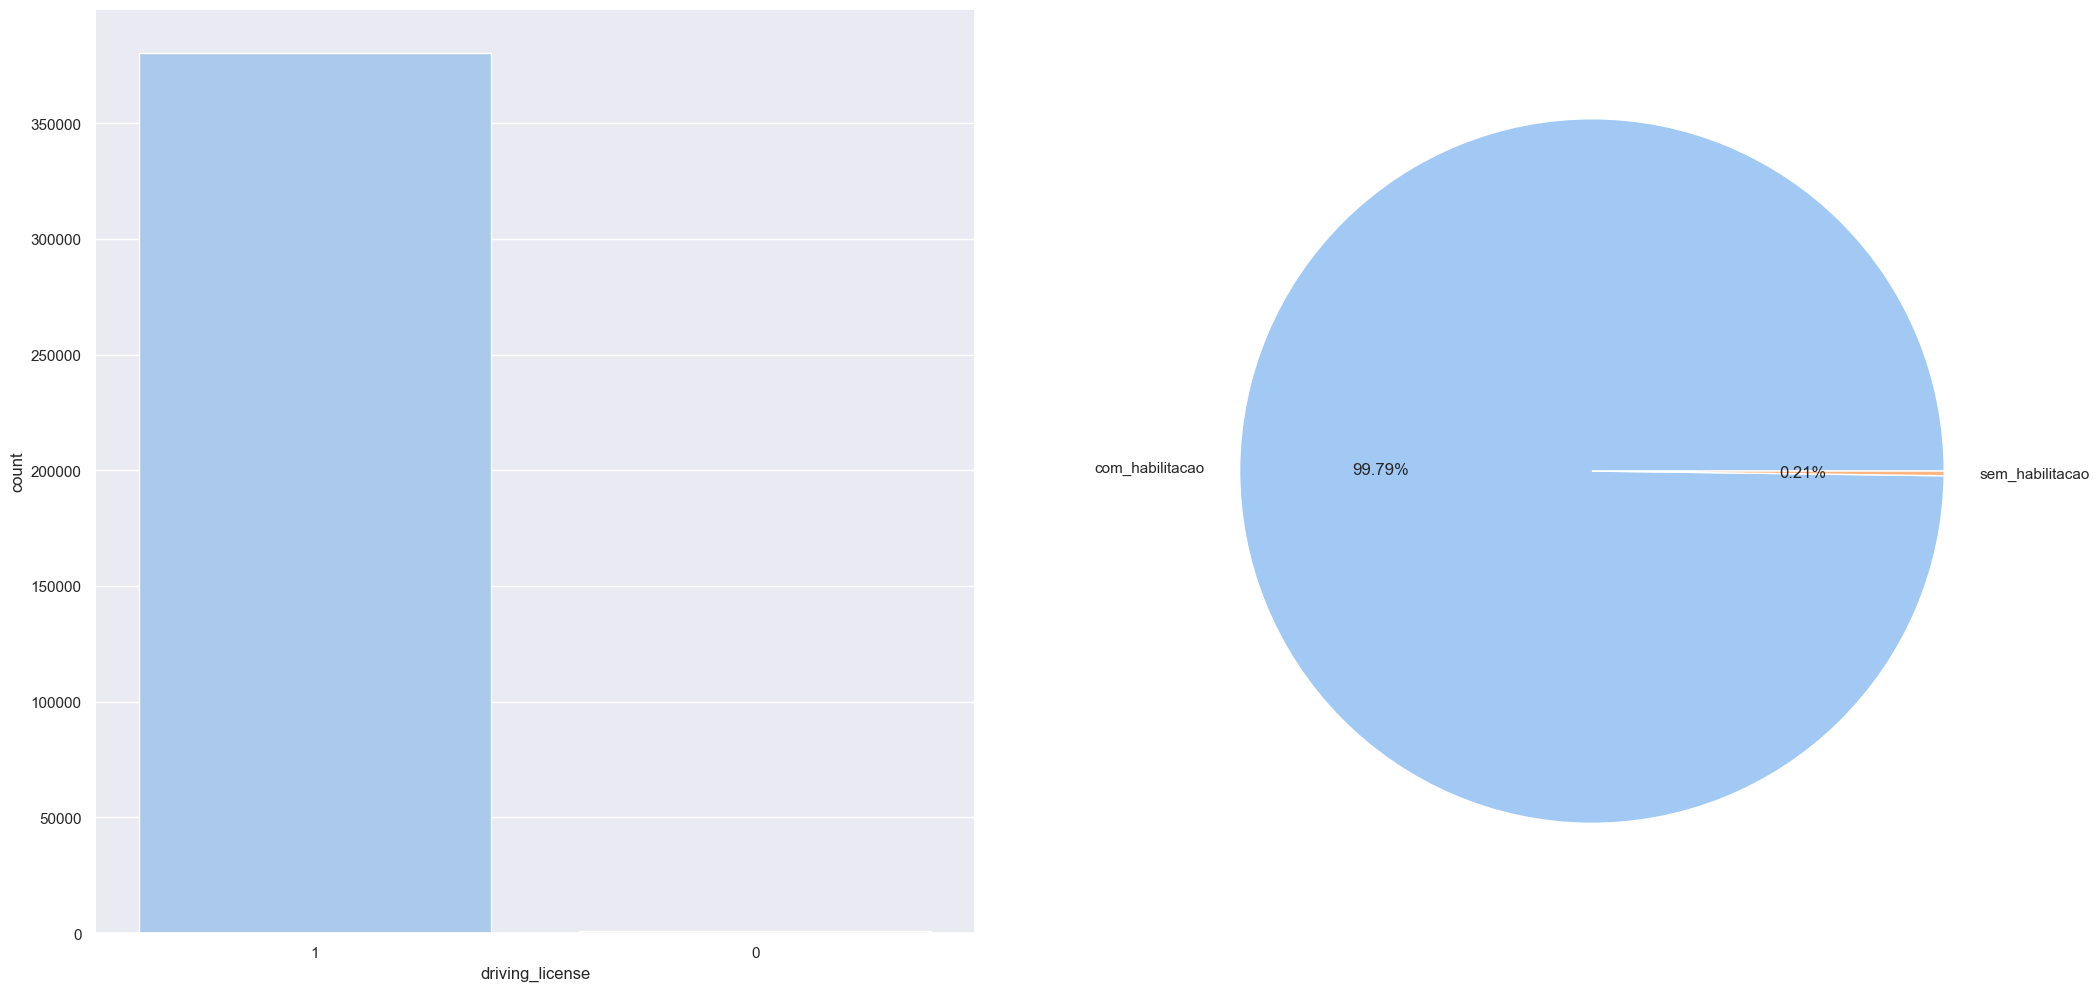

In [59]:
# driving_license
plt.subplot(1,2,1)
sns.countplot(data=df4,x='driving_license',order = [1, 0], palette = 'pastel');

#pie chart
aux1 = percentage_pandas(df4[ df4['driving_license']==1 ], df4 )
aux2 = percentage_pandas(df4[ df4['driving_license']==0 ], df4 )
colors = sns.color_palette('pastel')[0:5]
data = [ aux1, aux2]
labels = ['com_habilitacao','sem_habilitacao']
plt.subplot(1,2,2)
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

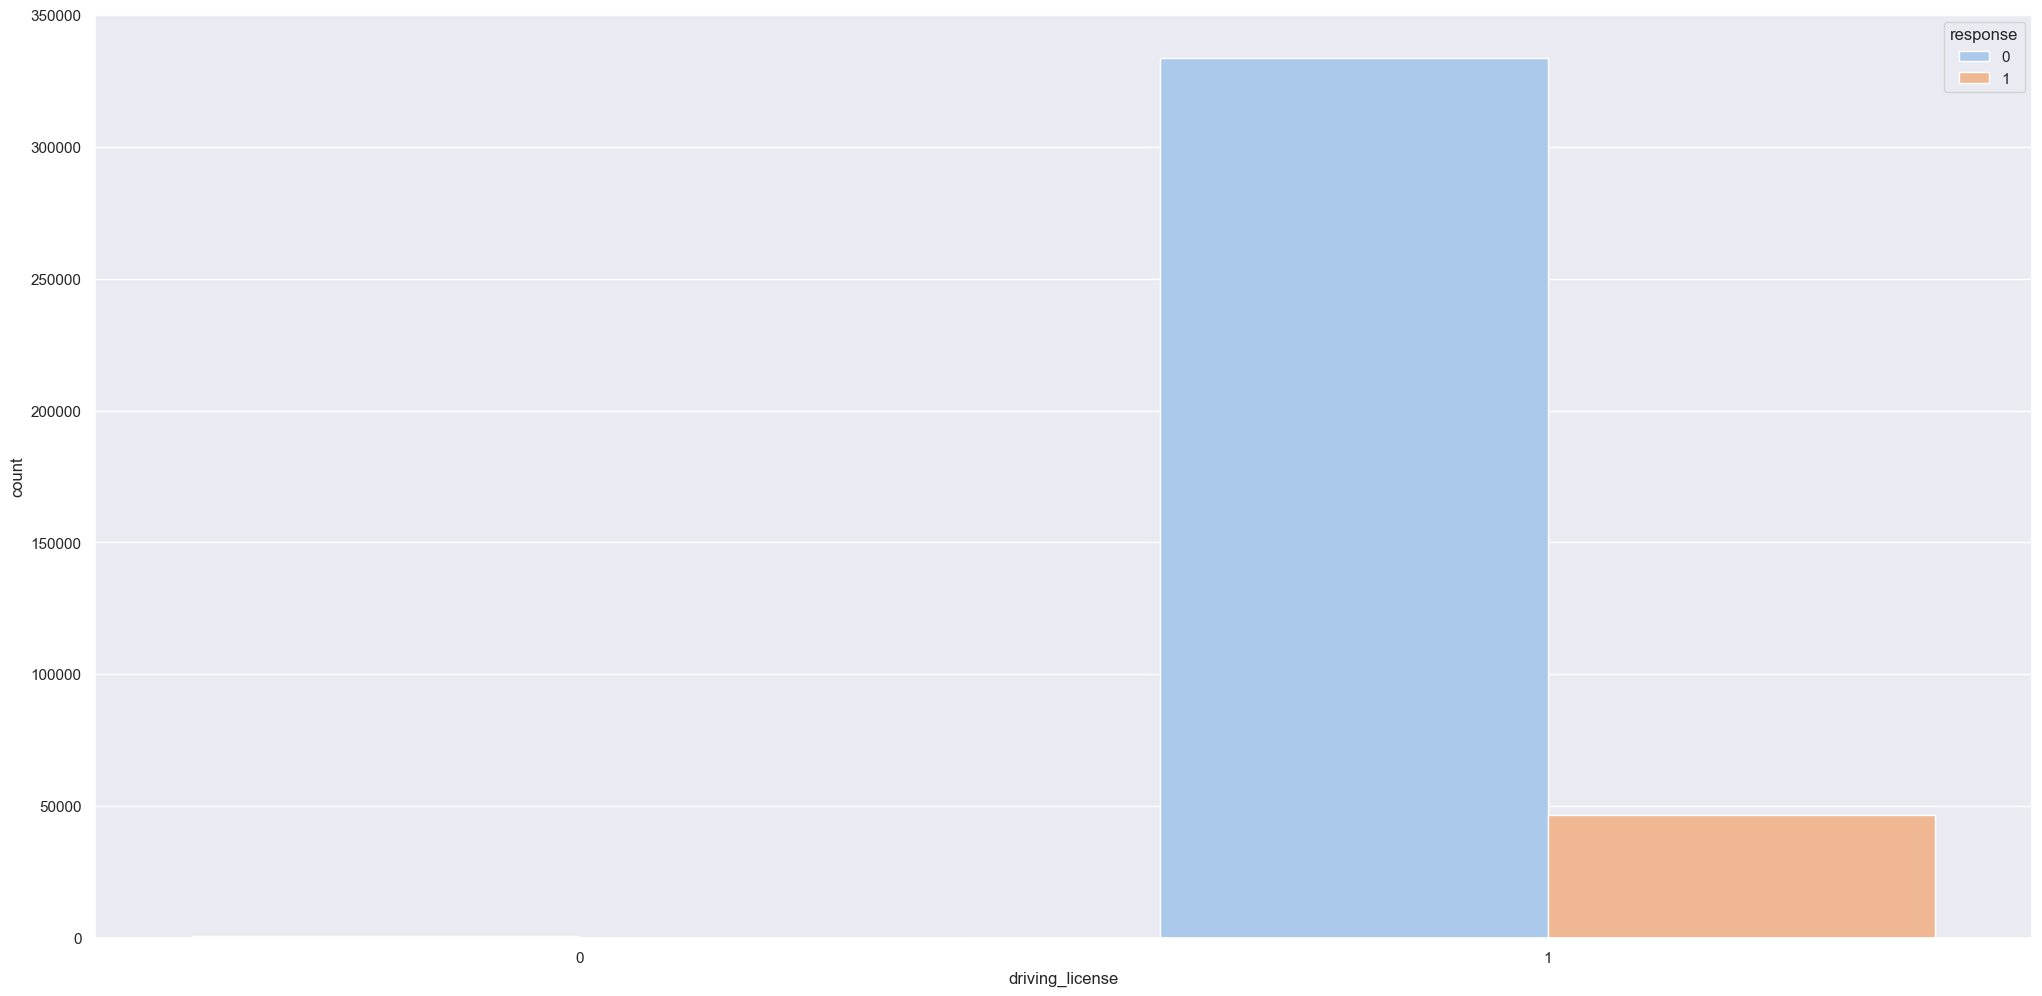

In [60]:
# all customers 
sns.countplot(data = df4, x = 'driving_license', hue = 'response',palette = 'pastel');

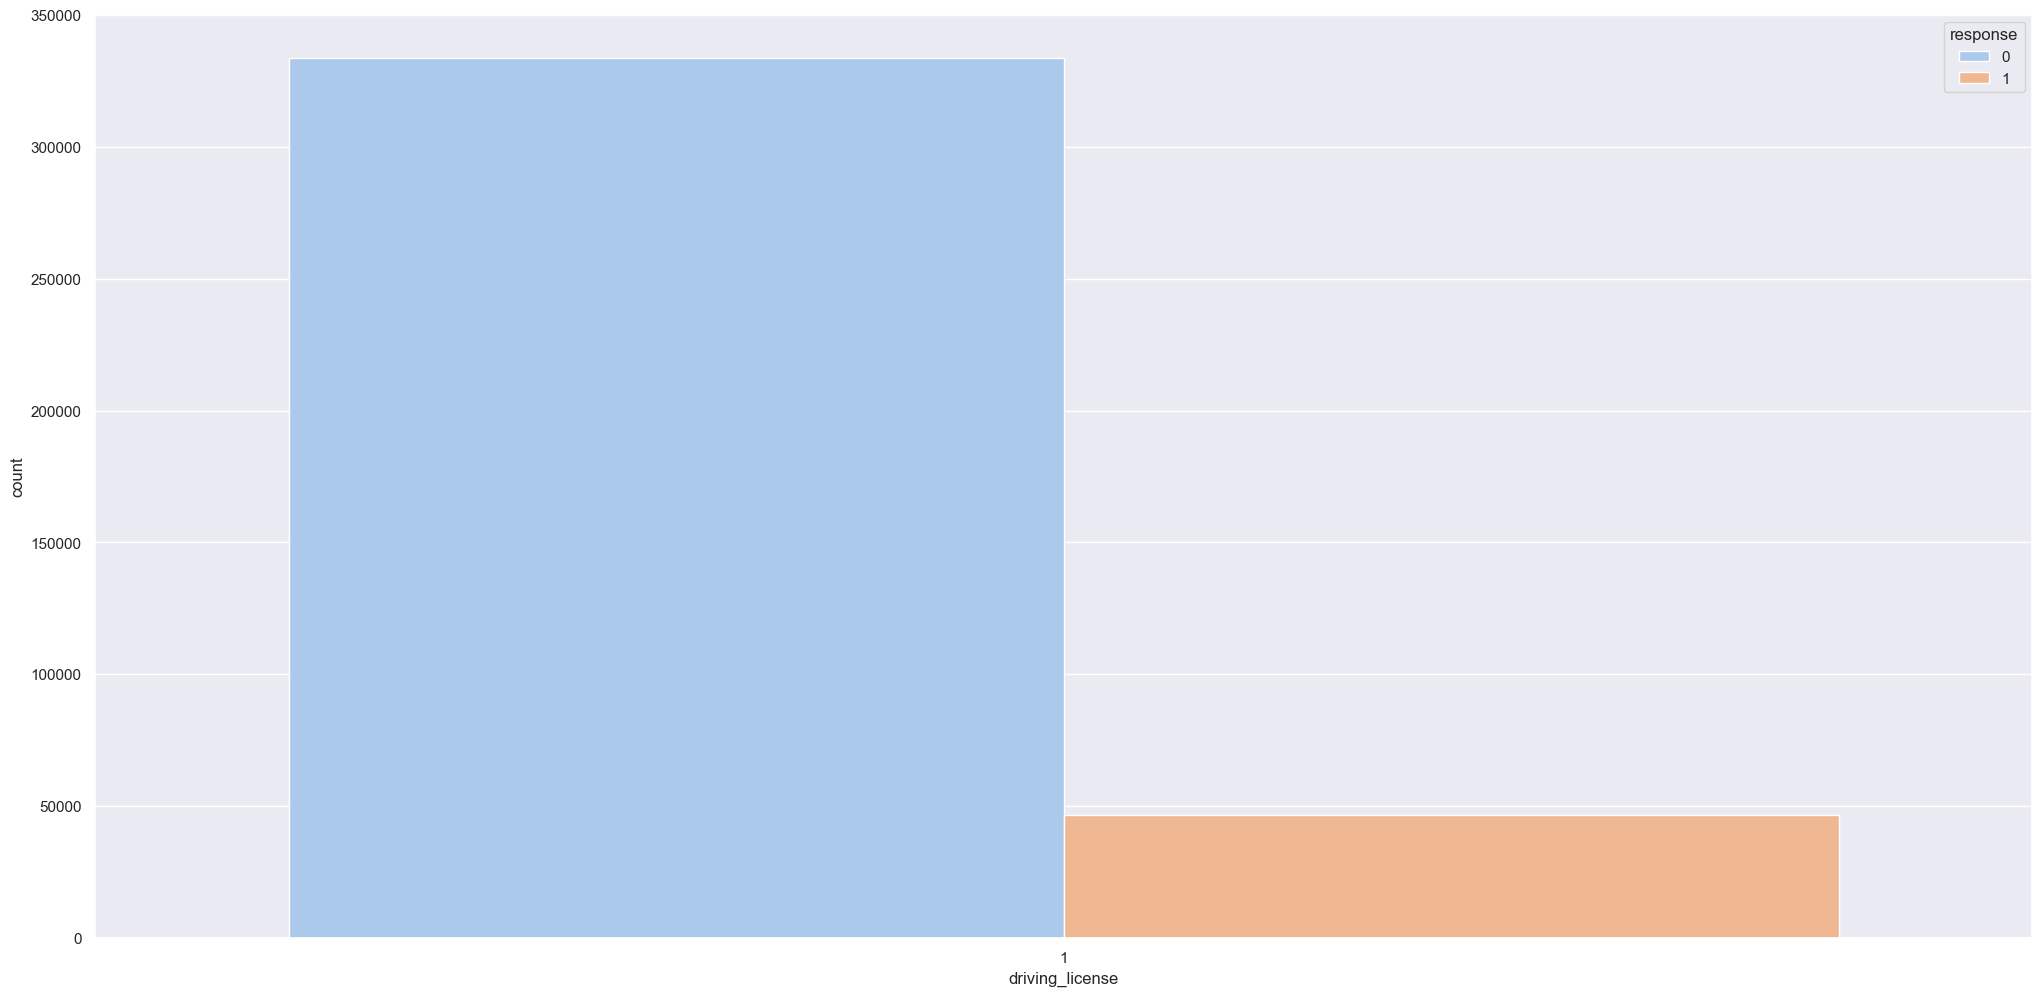

In [61]:
# All Customers with driver's license
aux1 = df4.loc[df4['driving_license']==1]
sns.countplot(data = aux1, x = 'driving_license', hue = 'response',palette = 'pastel');

In [62]:
aux1 = df4.loc[(df4['driving_license']==1) & (df4['response']==1)]
aux2 = df4.loc[df4['driving_license']==1]
print('percentual de clientes com licença e com interesse: {} %'.format(percentage_pandas(aux1,aux2 ) ) )

percentual de clientes com licença e com interesse: 12.271724467981604 %


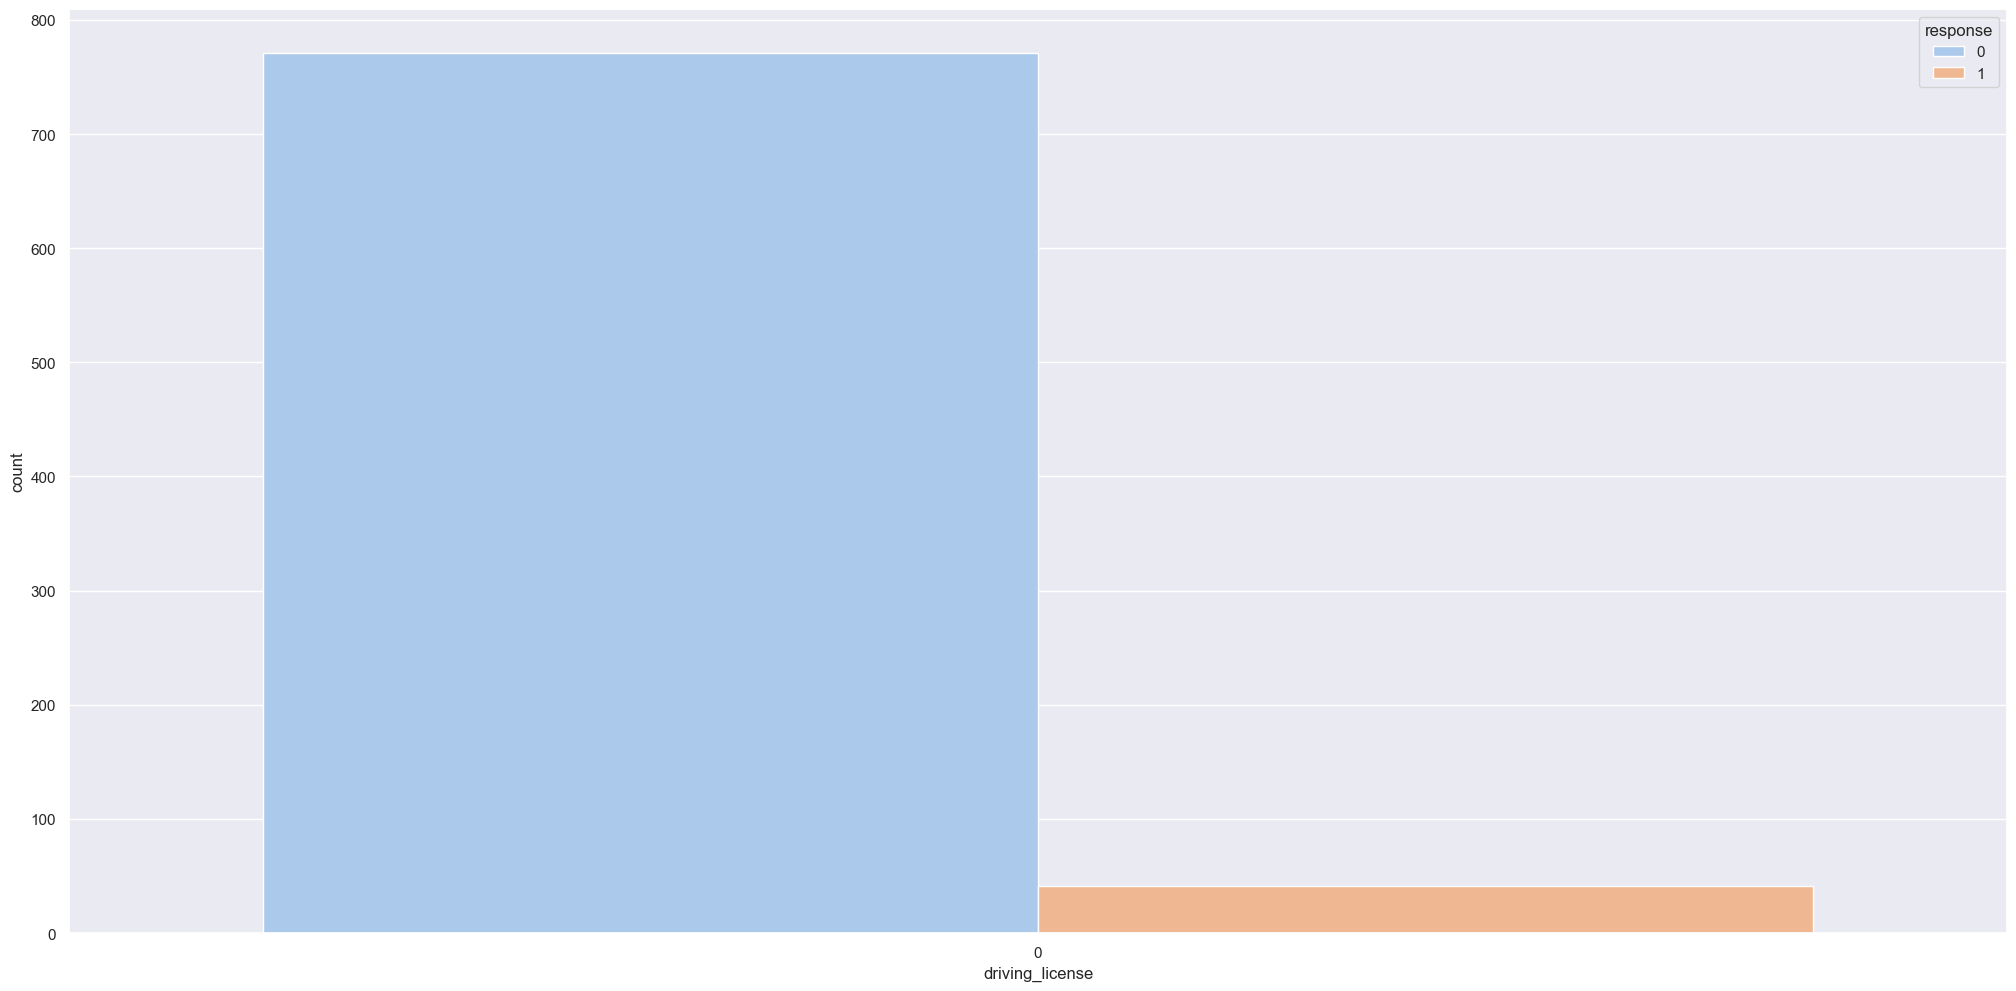

In [63]:
# Customers without driver's license
aux1 = df4.loc[df4['driving_license']==0]
sns.countplot(data = aux1, x = 'driving_license', hue = 'response',palette = 'pastel');

In [64]:
aux1 = df4.loc[(df4['driving_license']==0) & (df4['response']==1)]
aux2 = df4.loc[df4['driving_license']==0]
print('percentual de clientes sem licença e com interesse: {} %'.format(percentage_pandas(aux1,aux2 ) ) )

percentual de clientes sem licença e com interesse: 5.0492610837438425 %


### Hypothes 3. Clientes que possuem habilitação tem mais interesse em contratar o seguro veicular
Hypothes 3. True

### Age

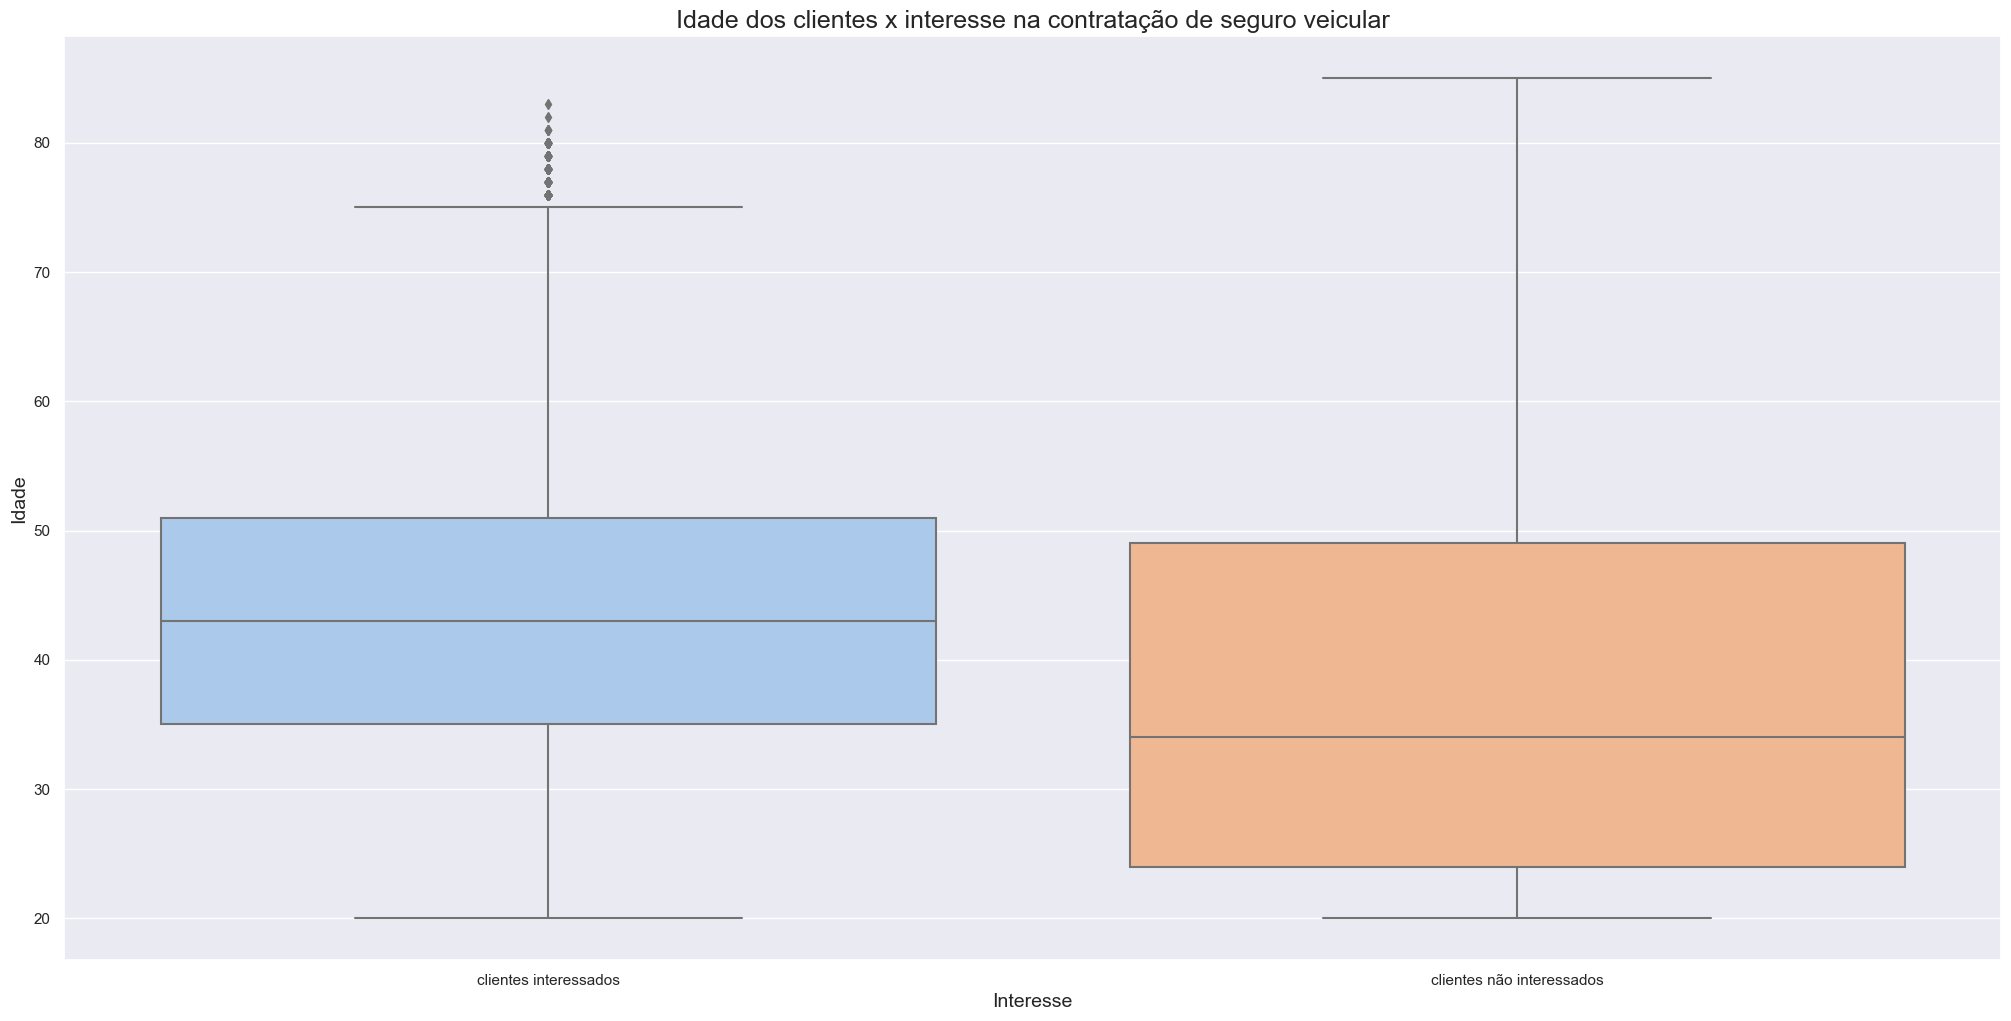

In [65]:
aux1 = df4.copy()
aux1['response'] = aux1.apply(lambda x: 'clientes não interessados' if (x['response']==0) else 'clientes interessados',axis =1)
aux1['response'].unique()

boxplot = sns.boxplot( x='response', y='age', data=aux1,palette = 'pastel' );
boxplot.axes.set_title("Idade dos clientes x interesse na contratação de seguro veicular", fontsize=18)
boxplot.set_xlabel("Interesse", fontsize=14)
boxplot.set_ylabel("Idade", fontsize=14)
plt.show()


* **Pessoas com interesse na contratação do seguro veícular possuem mediana de idade acima de 40 anos.**

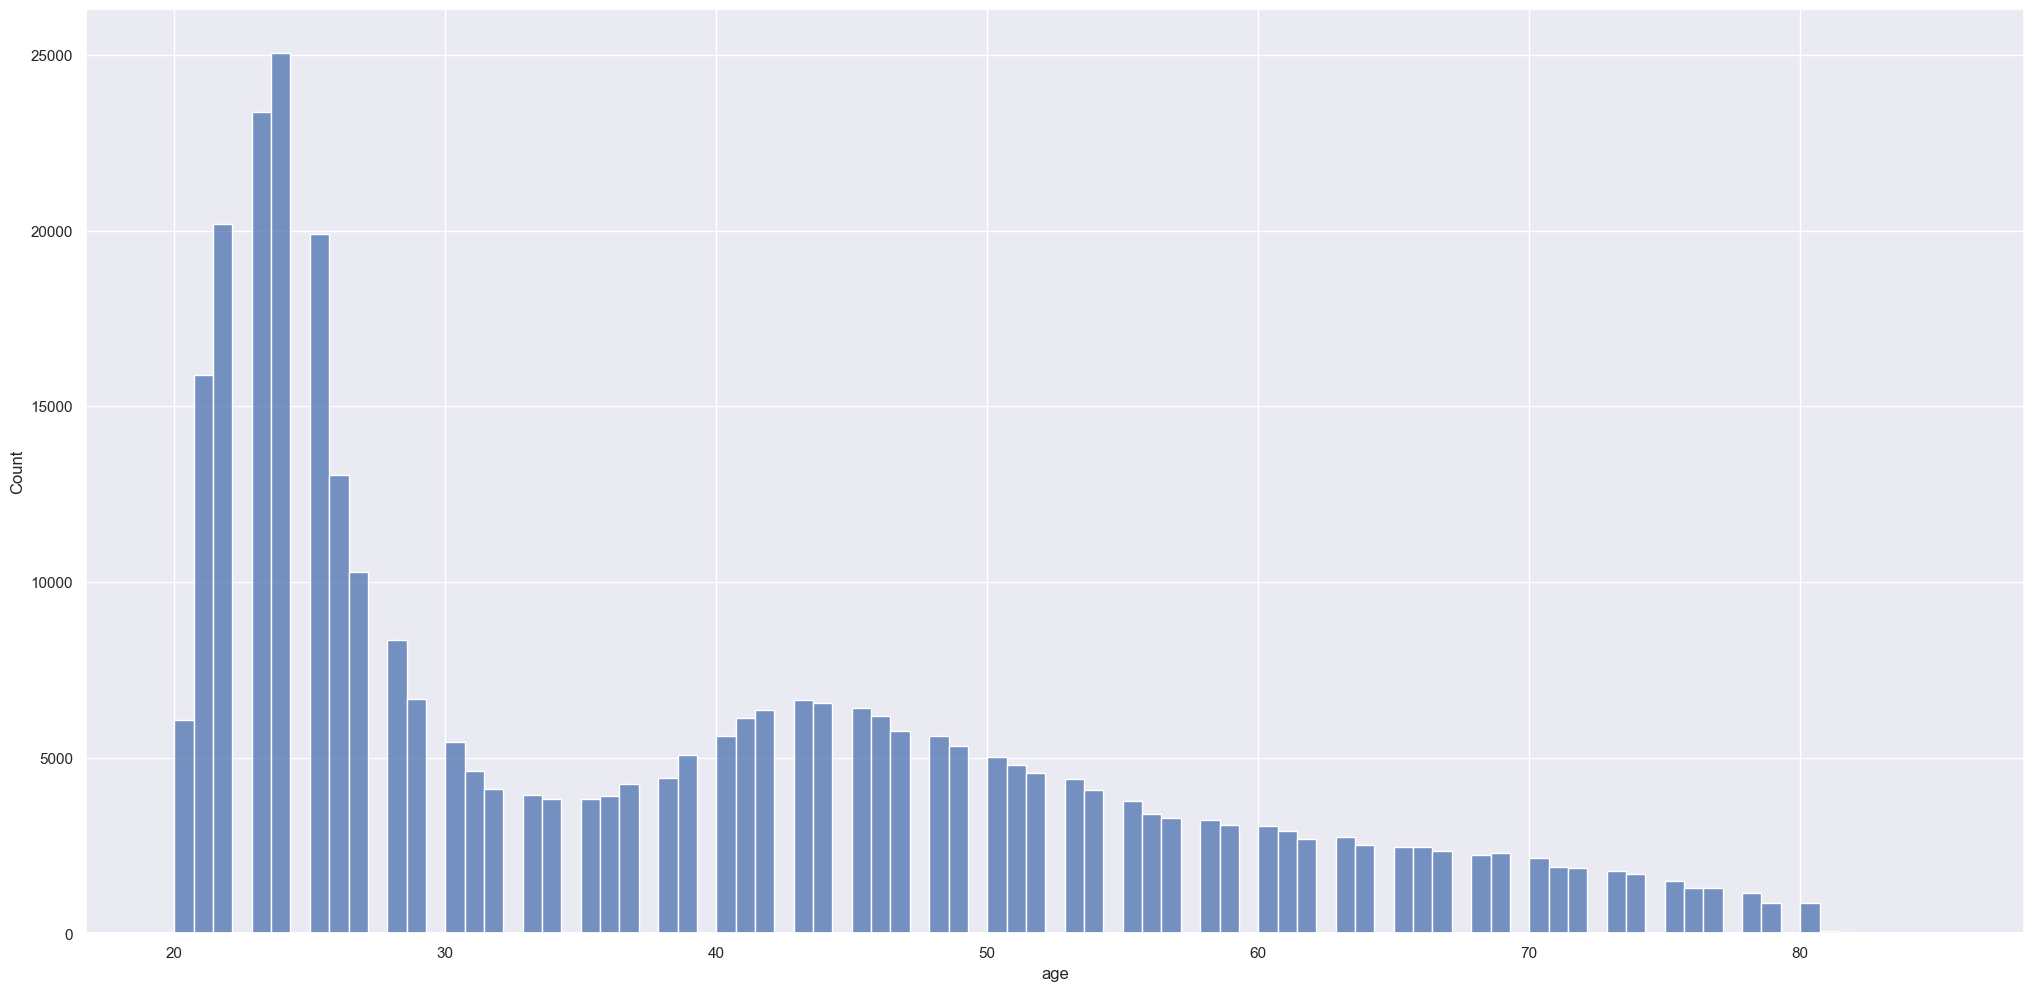

In [66]:
# olhar comportamento distribuicao para pessoas sem interesse
aux1 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux1 );

### Hypotheses 4. Clientes acima de 40 anos tem mais interesse em contratar o seguro veicular
Hypothes True

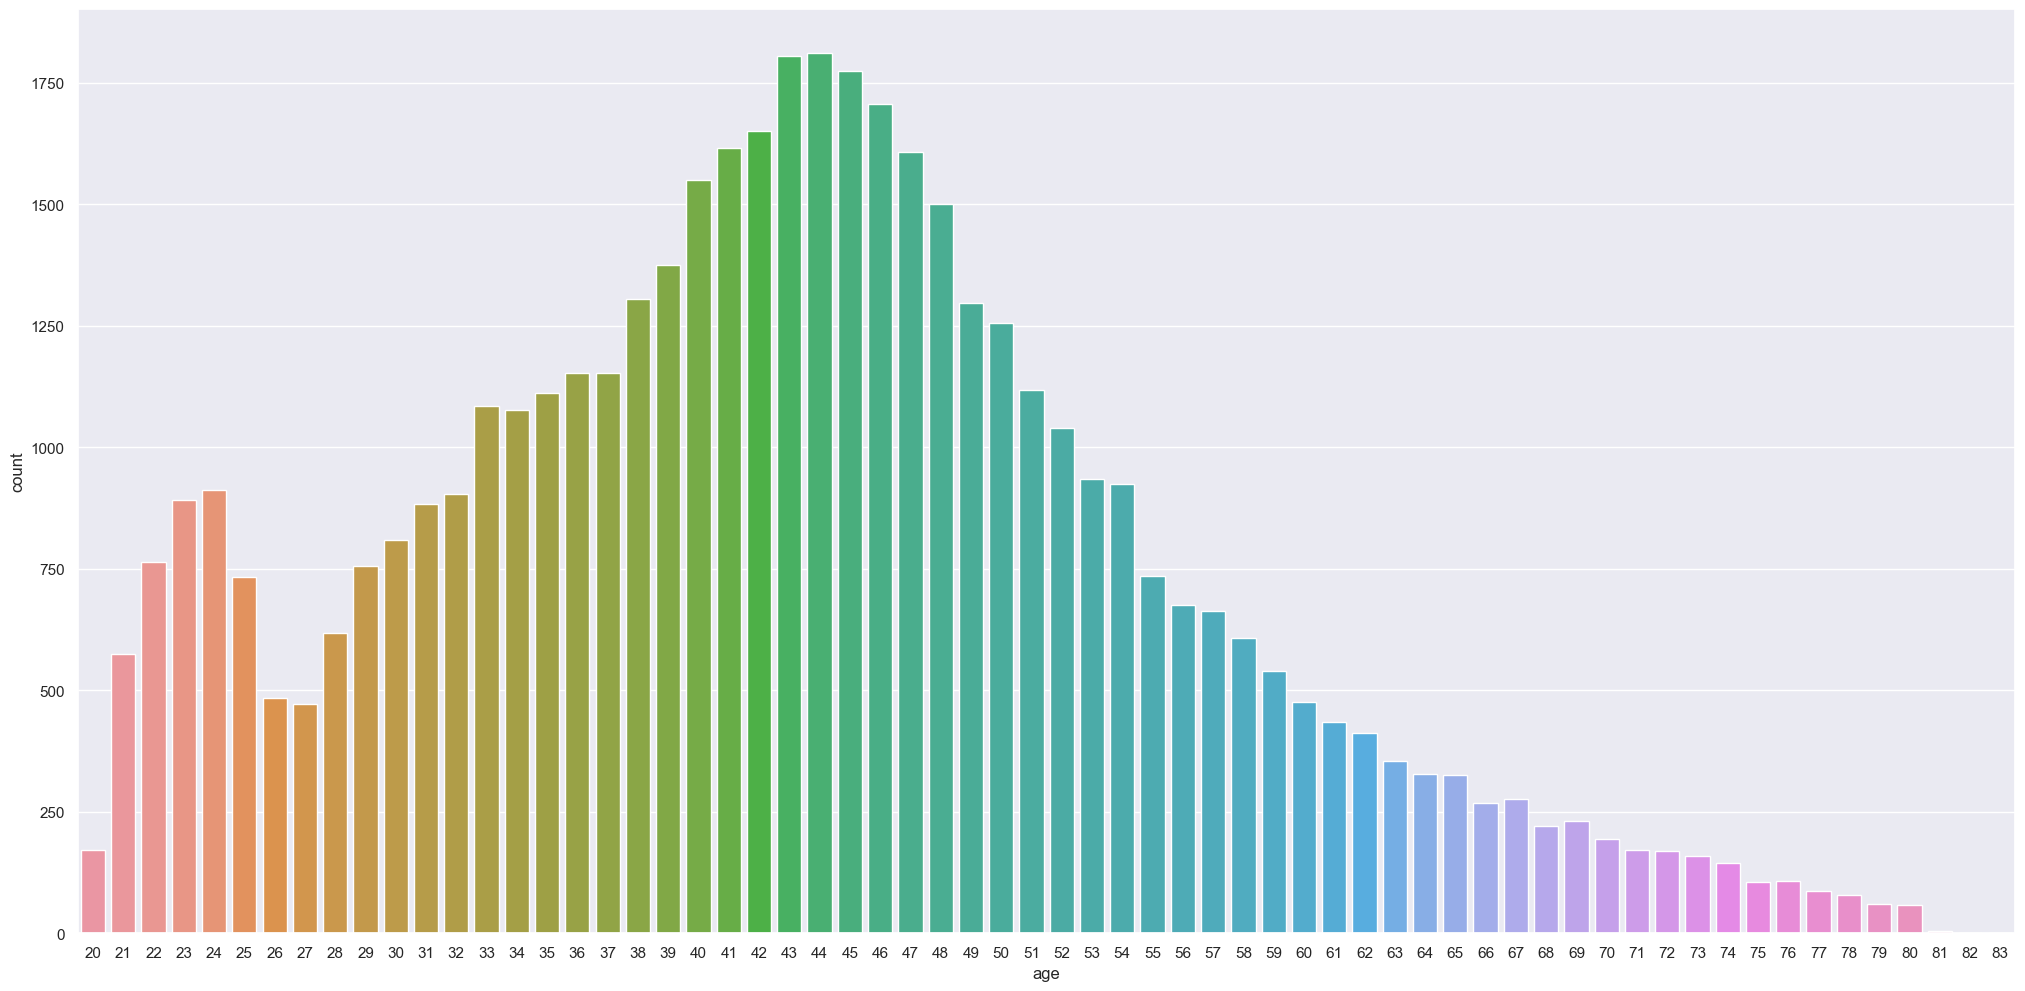

In [67]:
# olhar comportamento distribuicao para pessoas com interesse
aux1 = df4.loc[df4['response'] == 1]
sns.countplot(data = aux1, x = 'age');

In [68]:
# above 40 years
df4.loc[(df4['response']==1)&(df4['age']>=40)].shape[0]

29480

In [69]:
# under 40 years 
df4.loc[(df4['response']==1)&(df4['age']<40)].shape[0]

17230

* **29480 clientes com idade acima de 40 anos que responderam que tem interesse na contração de seguro veícular**
* **17230 clientes com idade abaixo de 40 anos que responderam que tem interesse na contração de seguro veícular**

### previously_insured

In [70]:
aux1 = df4[['previously_insured','response']].copy()
aux1['previously_insured'] = aux1['previously_insured'].apply( lambda x: 'com seguro' if x == 1 else 'sem seguro')
aux1['response'] = aux1['response'].apply( lambda x: 'Tem interesse no seguro veicular' if x == 1 else 'Não tem interesse no seguro veicular')

aux1['previously_insured'].value_counts()

sem seguro    206481
com seguro    174628
Name: previously_insured, dtype: int64

In [71]:
pd.crosstab( aux1['previously_insured'], aux1['response'] )

response,Não tem interesse no seguro veicular,Tem interesse no seguro veicular
previously_insured,,
com seguro,174470,158
sem seguro,159929,46552


In [72]:
#'previously_insured'
pd.crosstab( aux1['previously_insured'], aux1['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,Não tem interesse no seguro veicular,Tem interesse no seguro veicular
previously_insured,,
com seguro,1.00,0.00
sem seguro,0.77,0.23


### Hypotheses 5. Clientes que já possuem seguro veicular não tem interesse em contratar seguros veicular
Hypotheses 5. True

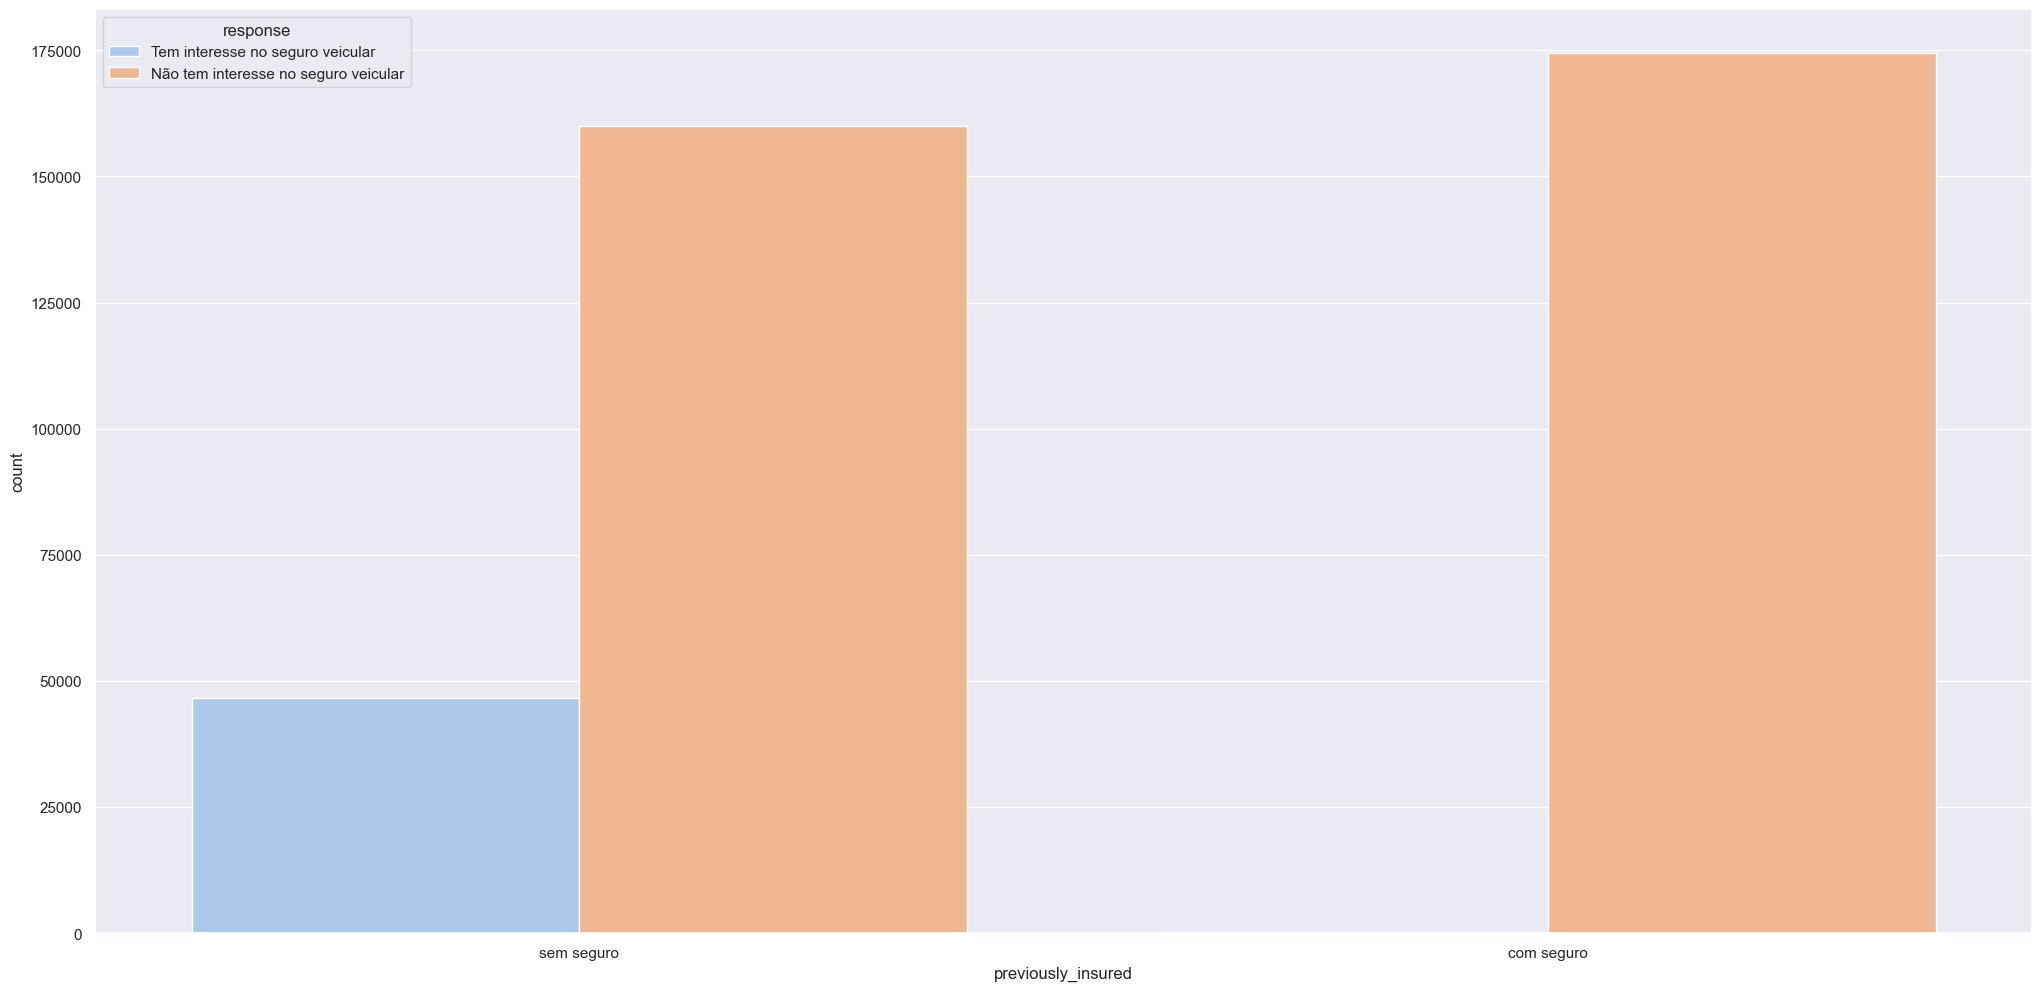

In [73]:
sns.countplot( data = aux1, x = 'previously_insured', hue = 'response', palette = 'pastel' );

* **99.9% dos clientes que já possuem seguro não tem interesse na contratação do seguros veícular.**

### vintage

* **Number of Days, Customer has been associated with the company**

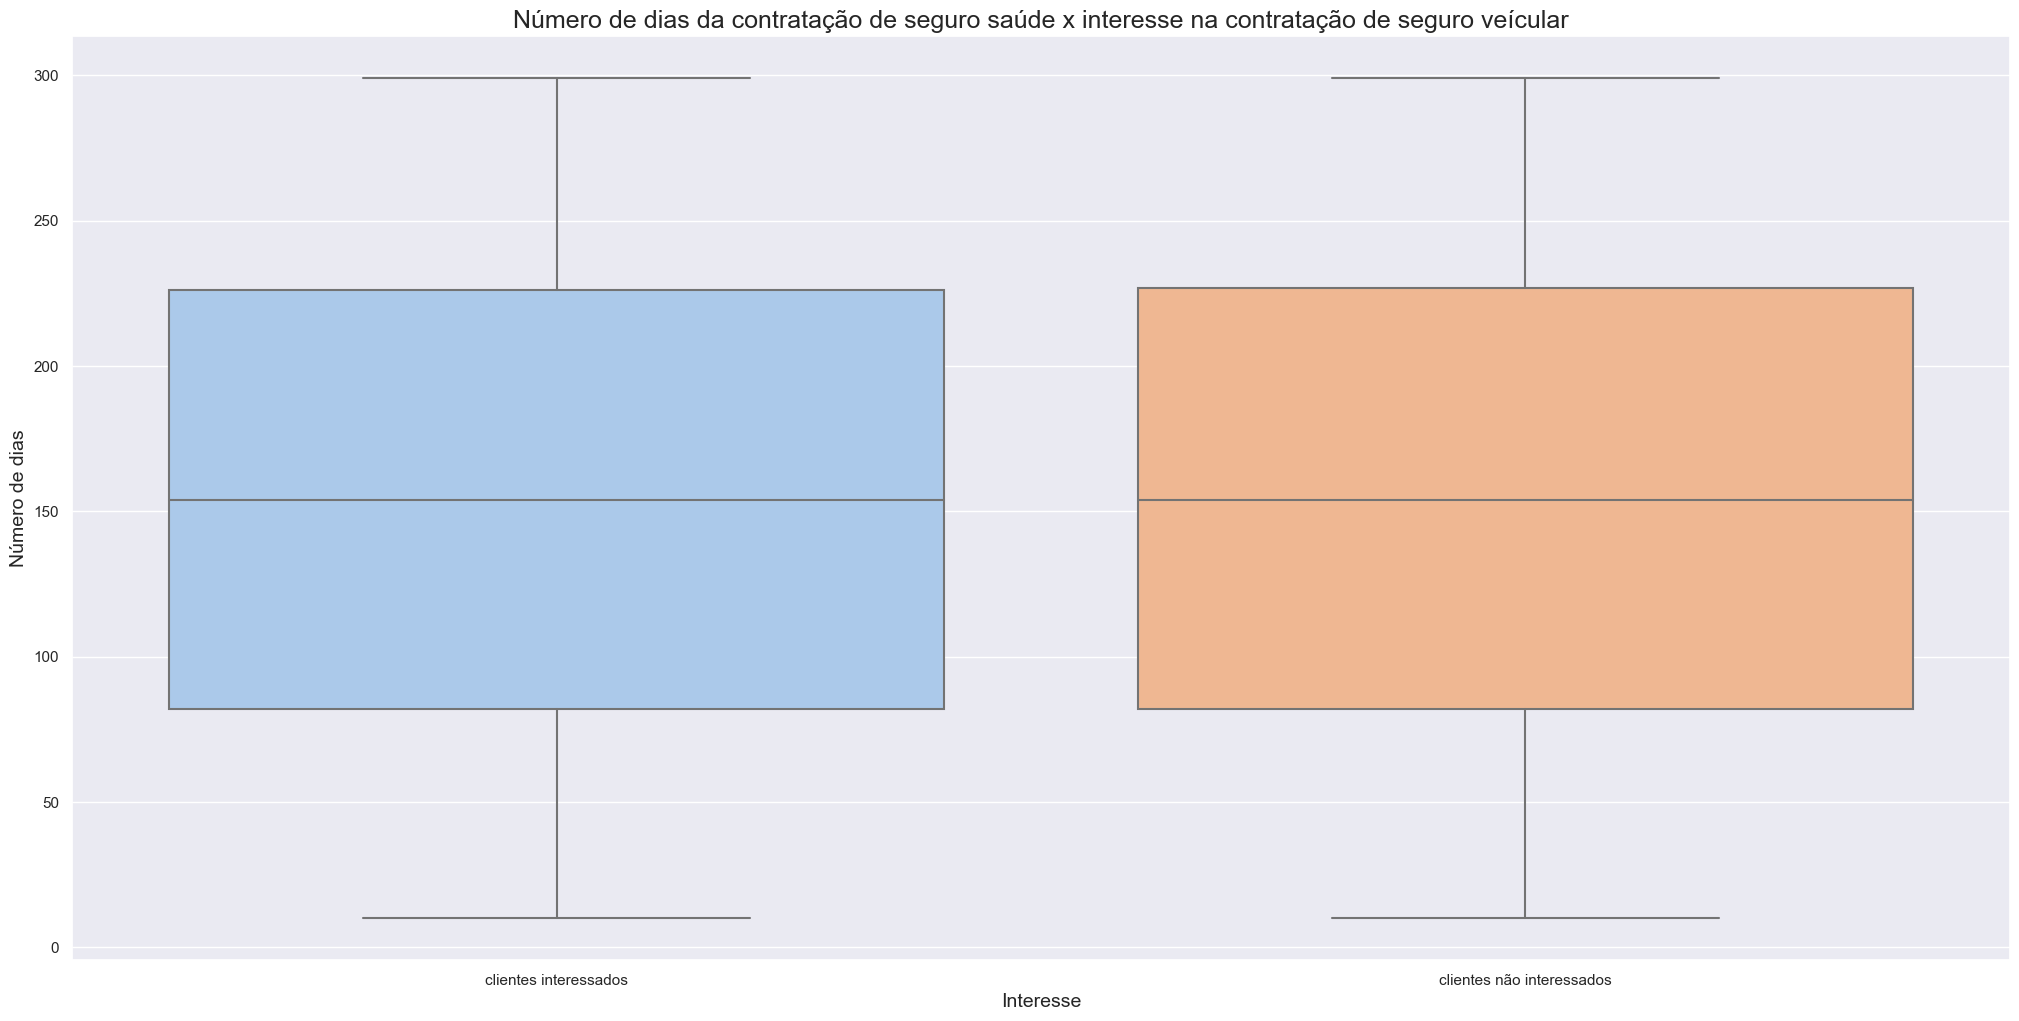

In [74]:
aux1 = df4.copy()
aux1['response'] = aux1.apply(lambda x: 'clientes não interessados' if (x['response']==0) else 'clientes interessados',axis =1)
aux1['response'].unique()

boxplot = sns.boxplot( x='response', y='vintage', data=aux1,palette = 'pastel' );
boxplot.axes.set_title("Número de dias da contratação de seguro saúde x interesse na contratação de seguro veícular", fontsize=18)
boxplot.set_xlabel("Interesse", fontsize=14)
boxplot.set_ylabel("Número de dias", fontsize=14)
plt.show()

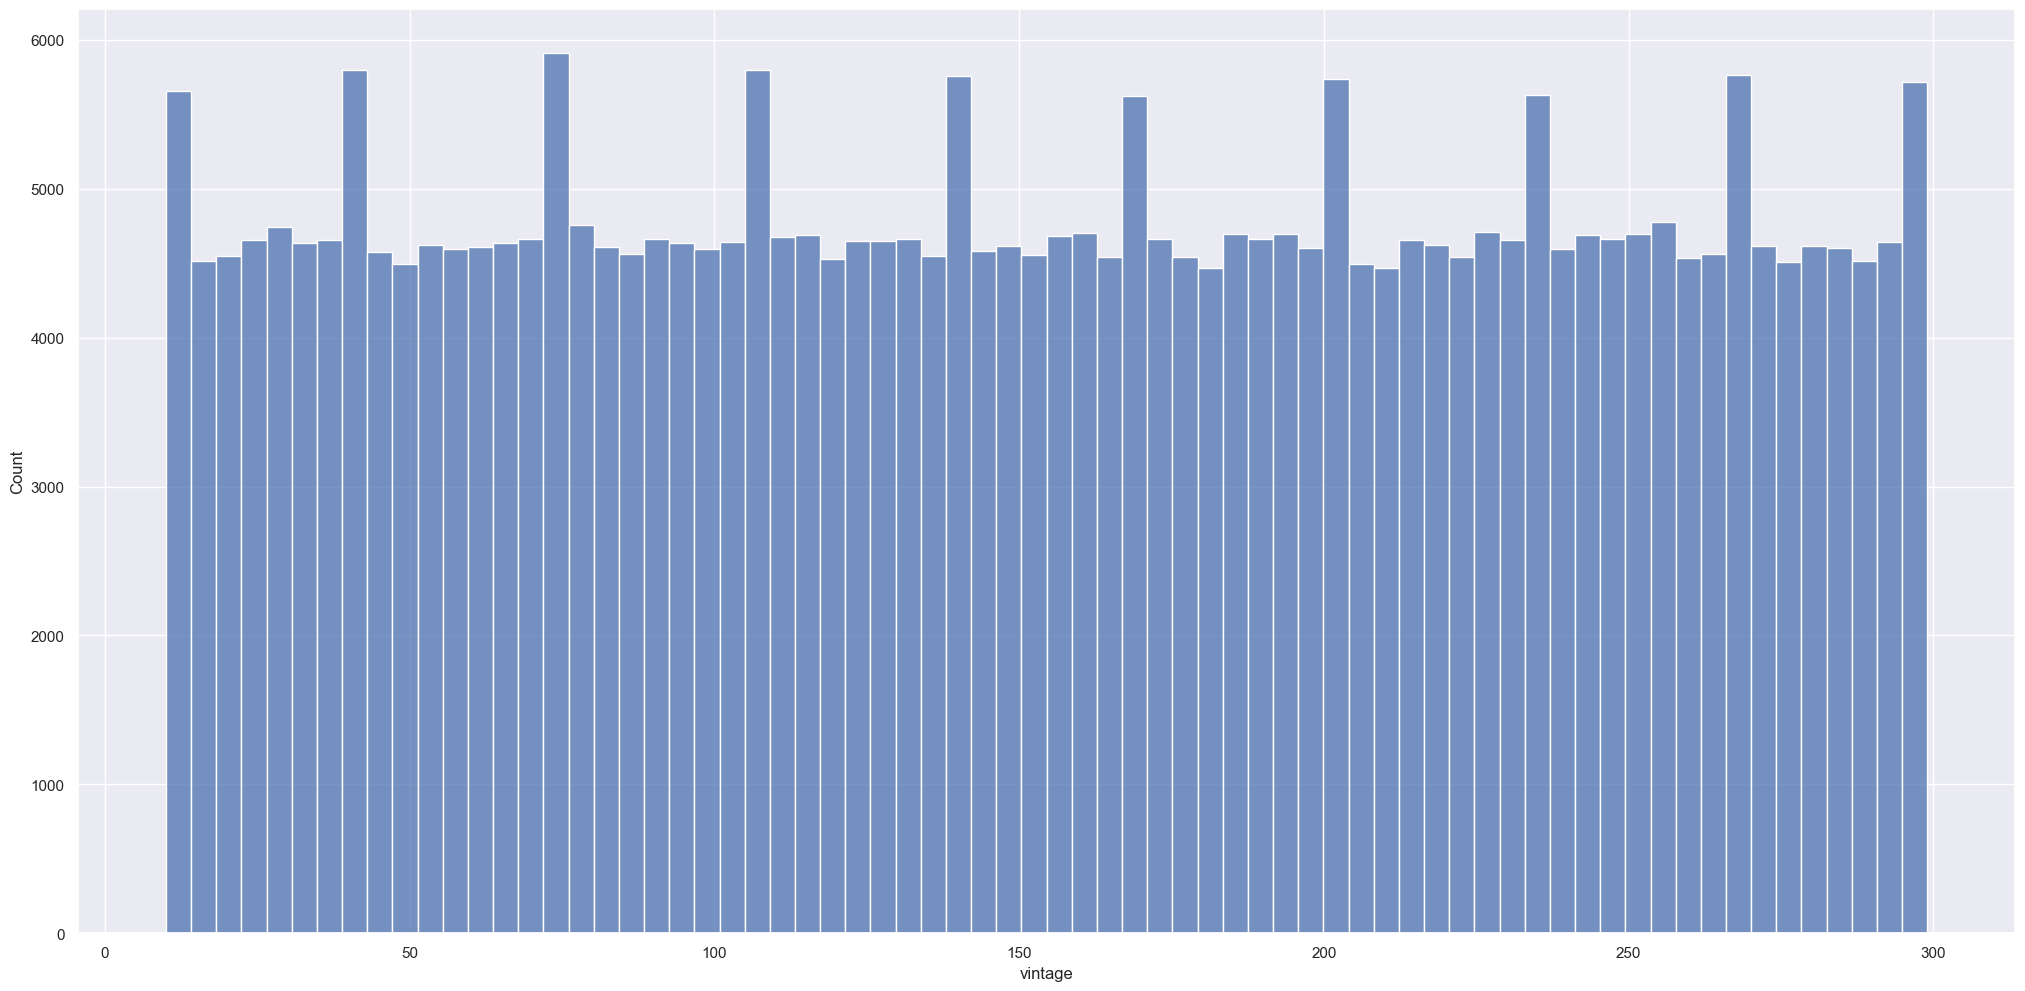

In [75]:
aux1 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux1 );

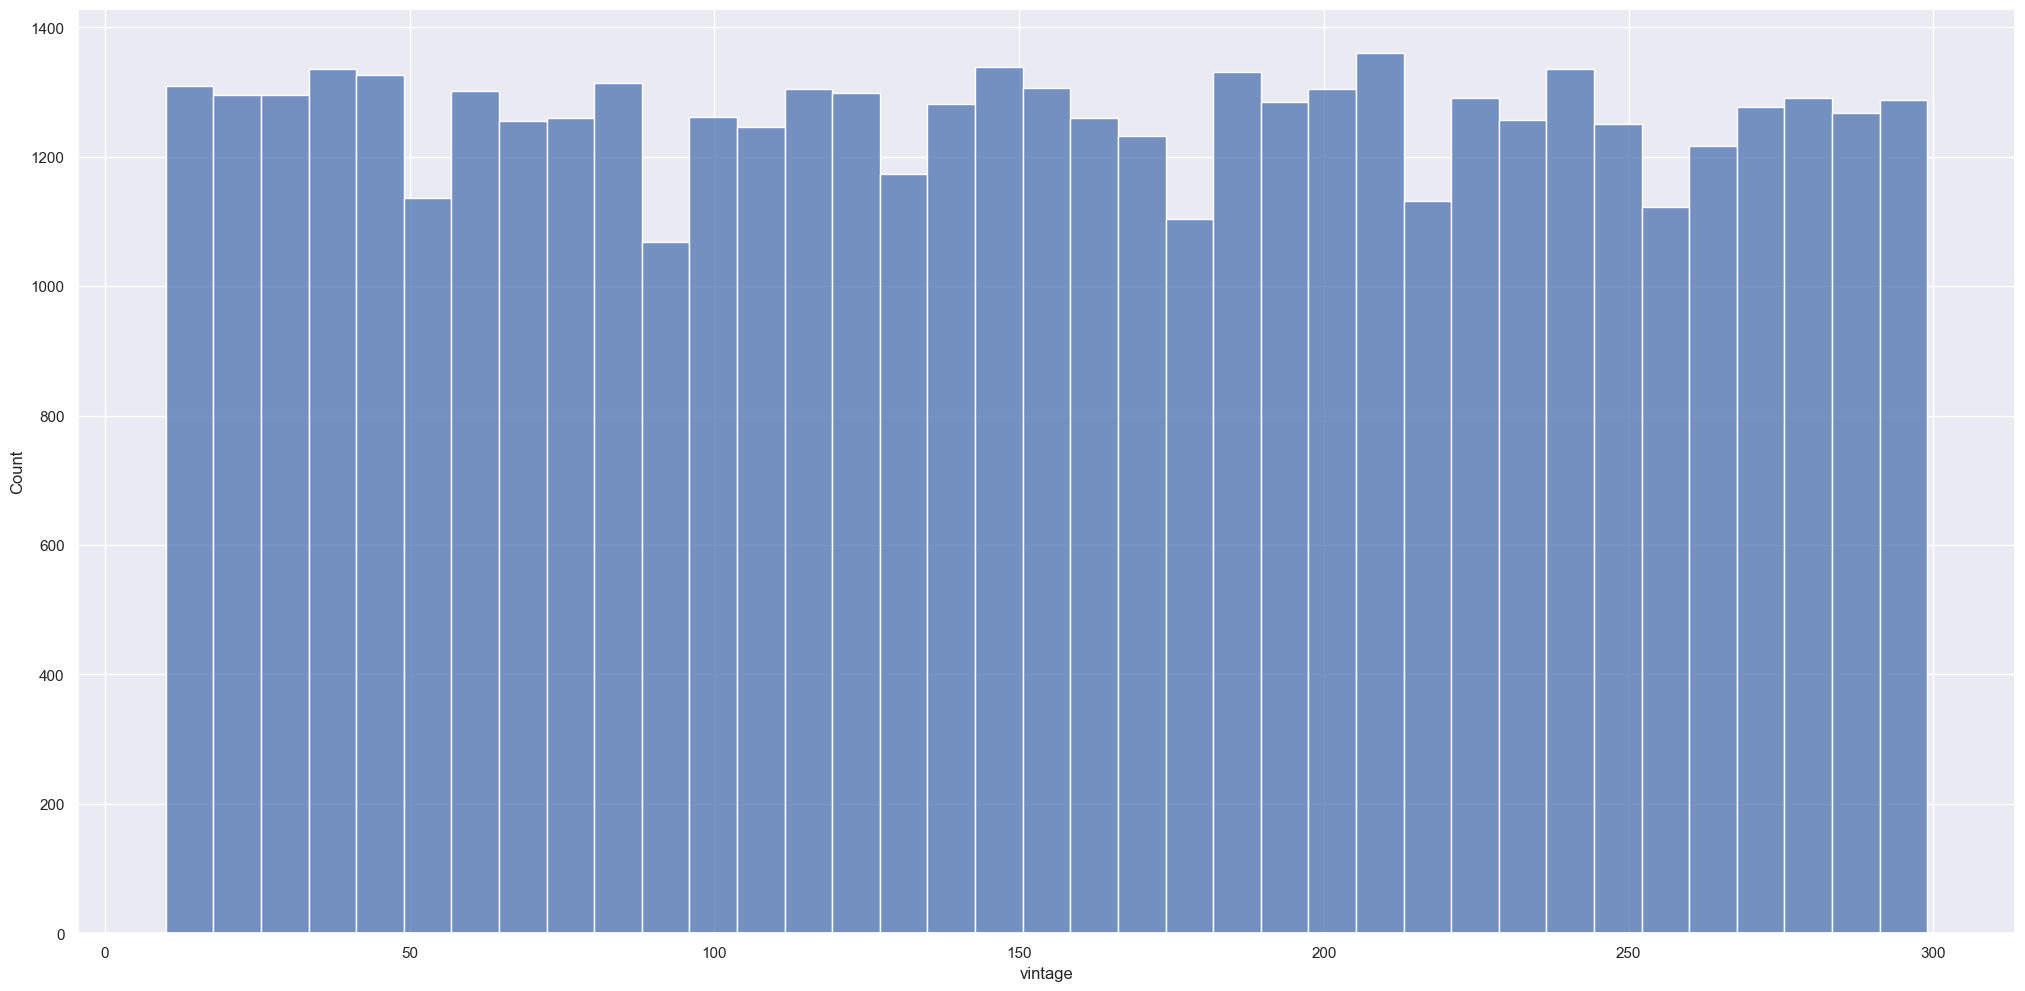

In [76]:
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux00 );

* **Não há relação entre o número de dias e o interesse da contratação do seguro.**

### Hypotheses 6. Clientes de seguro saúde mais antigos tem mais interesse em contratar o seguro veicular
Hypothes 6 False

### policy_sales_channel

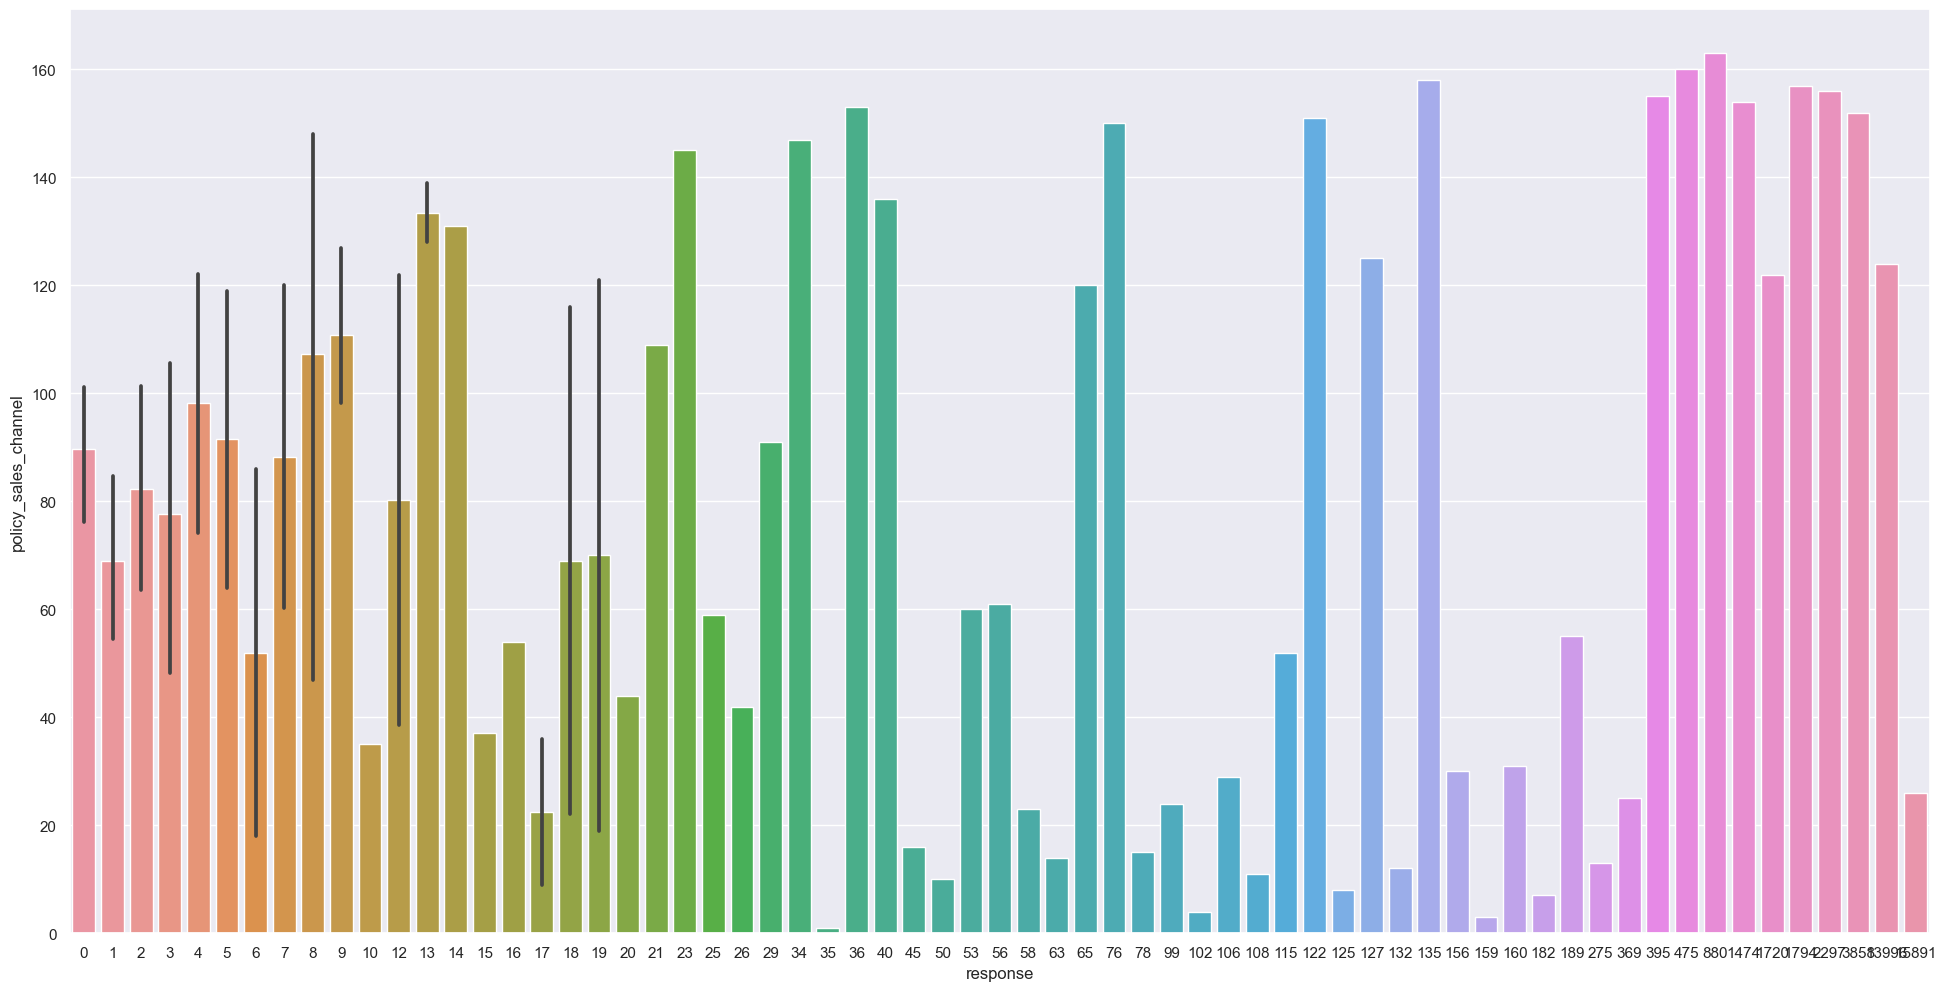

In [77]:
#'policy_sales_channel interested customers 
plt.figure( figsize=(24, 12 ))
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

### vehicle_age

In [78]:
df4['vehicle_age'].value_counts()

between_1_2_year    200316
below_1_year        164786
over_2_years         16007
Name: vehicle_age, dtype: int64

In [79]:
#'vehicle_age'
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.43
1,below_1_year,0,0.41
2,between_1_2_year,1,0.09
3,over_2_years,0,0.03
4,below_1_year,1,0.02
5,over_2_years,1,0.01


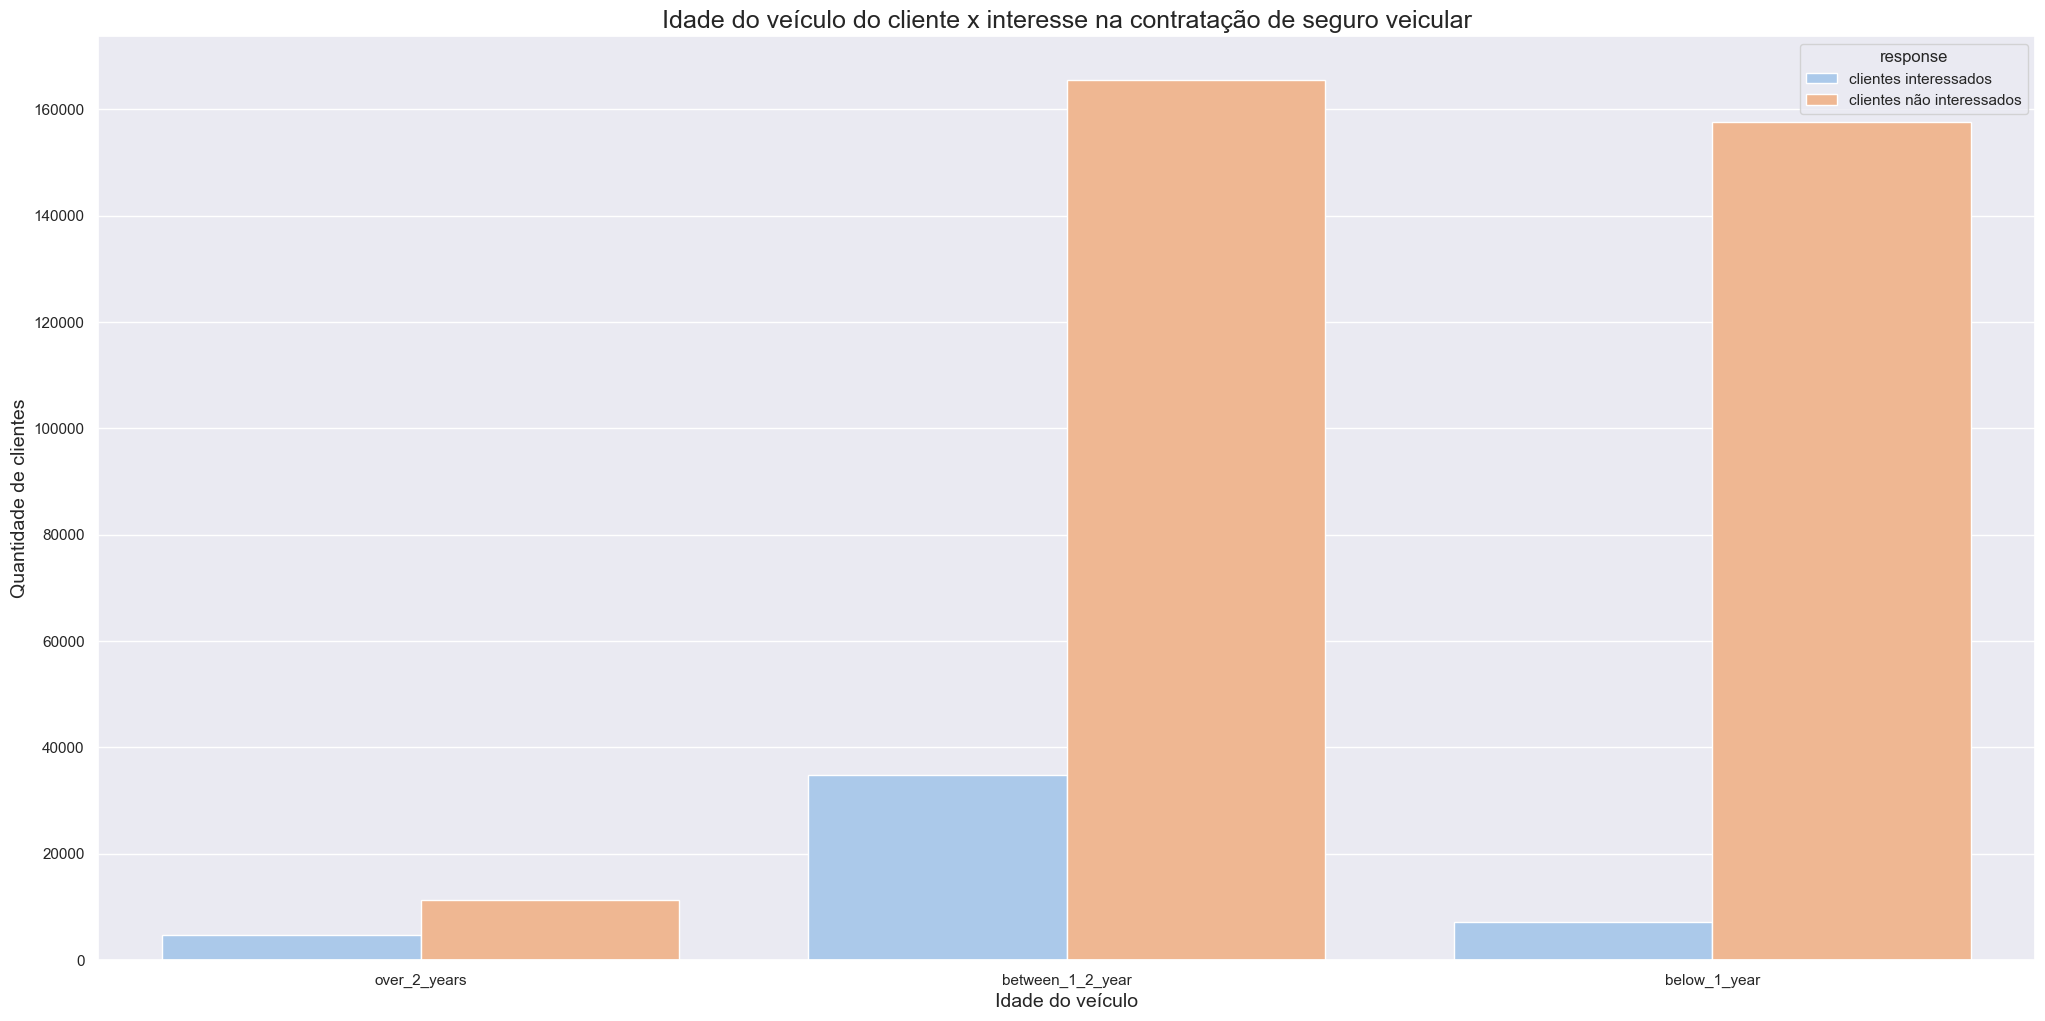

In [80]:
aux1 = df4.copy()
aux1['response'] = aux1.apply(lambda x: 'clientes não interessados' if (x['response']==0) else 'clientes interessados',axis =1)
aux1['response'].unique()

countplot = sns.countplot(  x='vehicle_age', hue = 'response',data=aux1, palette = 'pastel' );
countplot.axes.set_title("Idade do veículo do cliente x interesse na contratação de seguro veicular", fontsize=18)
countplot.set_xlabel("Idade do veículo", fontsize=14)
countplot.set_ylabel("Quantidade de clientes", fontsize=14)

plt.show()

* **29% dos clientes que possuem veículos com idade acima de 2 anos tem interesse na contração de seguro veícular  (1% do total de clientes)**
* **17% dos clientes que possuem veículos com idade entre 1 e 2 anos tem interesse na contração de seguro veícular (9% do total de clientes)**
* **4 % dos clientes que possuem veículos com idade abaixo de 1 ano tem interesse na contração de seguro veícular (2% do total de clientes)**

### region_code

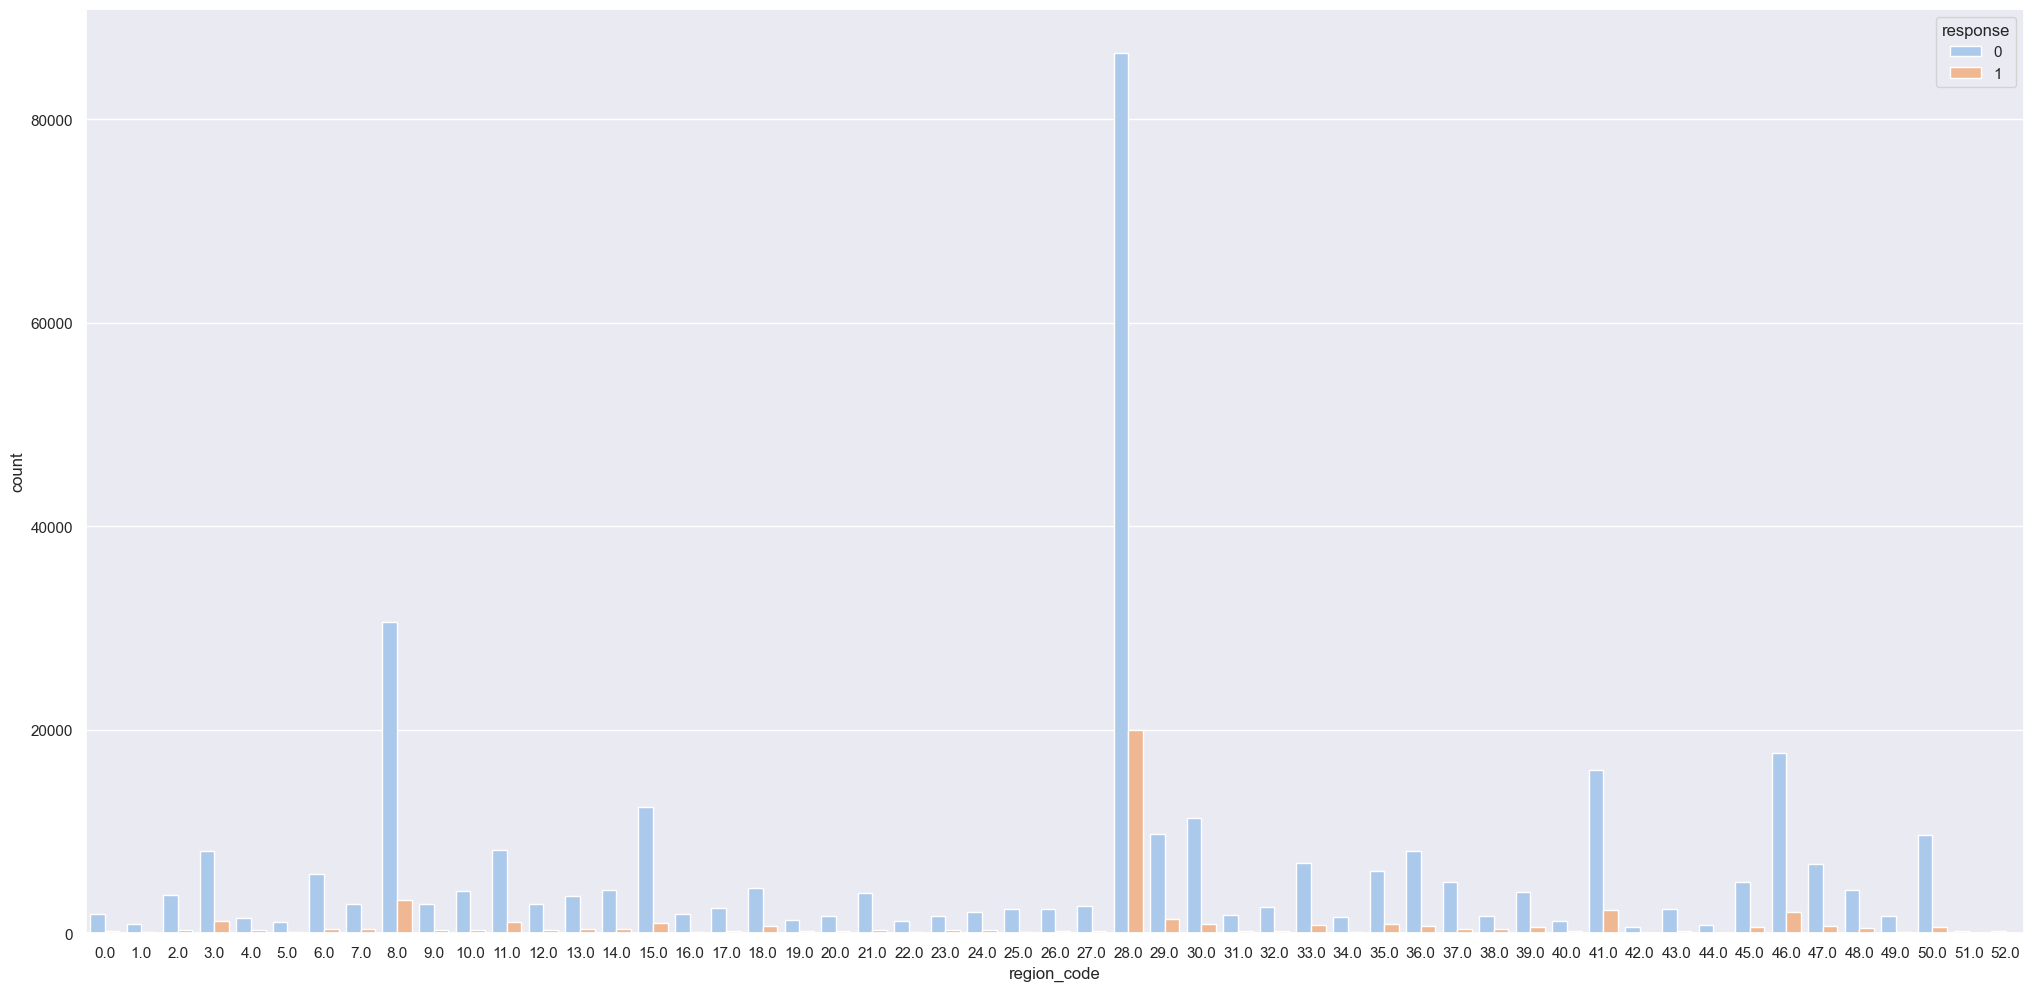

In [81]:
sns.countplot(data = df4, x = 'region_code', hue = 'response', palette = 'pastel');

* **A maioria dos clientes que tem interesse na contração de seguros são das regiões 28, 8, 46 e 41.**

In [82]:
aux1 = df4.copy()
aux1['response'] = aux1.apply(lambda x: 'clientes não interessados' if (x['response']==0) else 'clientes interessados',axis =1)
aux1['region_code'] = aux1['region_code'].astype(int)

aux2 = ( aux1[['region_code', 'response']].groupby(['region_code', 'response'])
                                          .agg(quantidade=('region_code','count'),
                                               percentual=('region_code','describe'))).reset_index()

aux3 = aux1[['region_code', 'response']].groupby('region_code').count().reset_index()
aux4 = aux3.to_dict()
mapa = aux4['response']

aux2['total'] = aux2['region_code'].map(mapa)

aux2['percentual'] = aux2.apply(lambda x: (x['percentual']/x['total'])*100, axis = 1 )
aux2.head(12)

,region_code,response,quantidade,percentual,total
0,0,clientes interessados,174,8.61,2021
1,0,clientes não interessados,1847,91.39,2021
2,1,clientes interessados,109,10.81,1008
3,1,clientes não interessados,899,89.19,1008
4,2,clientes interessados,287,7.11,4038
5,2,clientes não interessados,3751,92.89,4038
6,3,clientes interessados,1181,12.77,9251
7,3,clientes não interessados,8070,87.23,9251
8,4,clientes interessados,285,15.82,1801
9,4,clientes não interessados,1516,84.18,1801


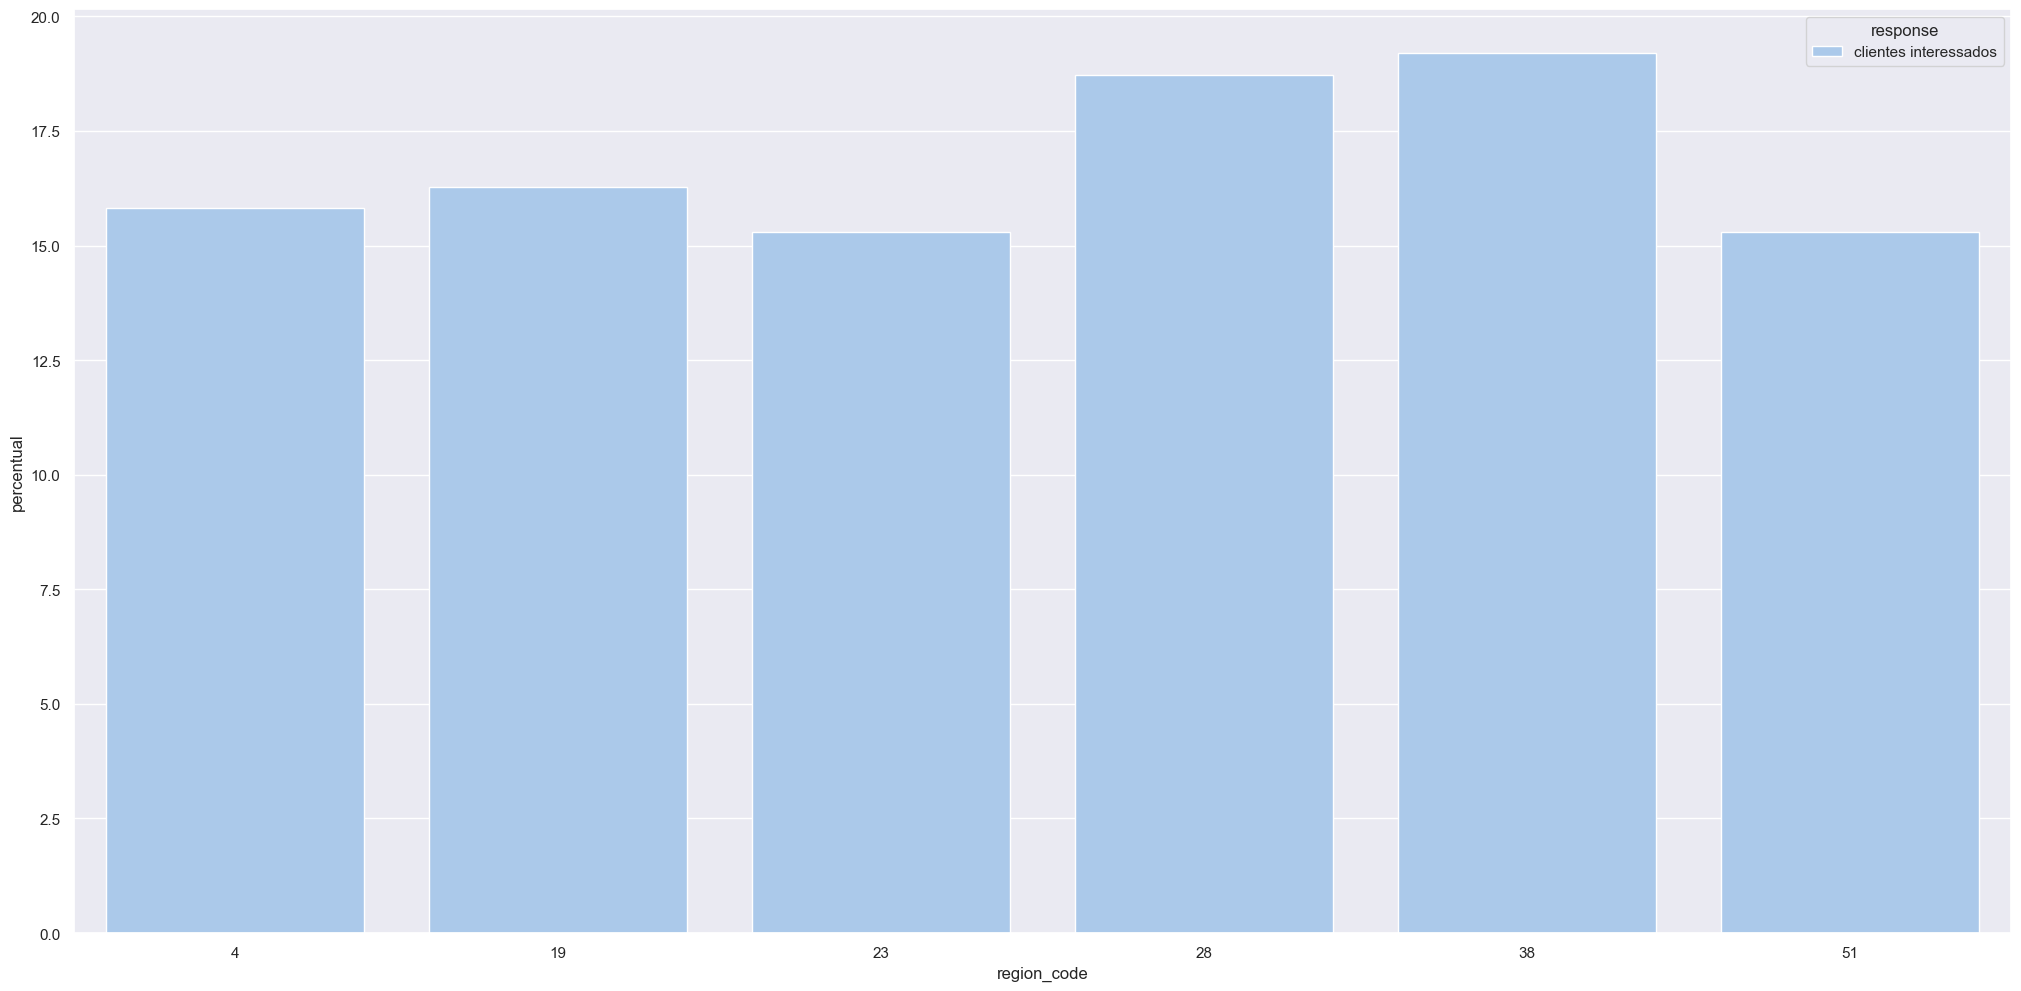

In [83]:
aux5 = aux2.loc[(aux2['response']=='clientes interessados')&(aux2['percentual']>=15)].copy()
sns.barplot(  x='region_code', y = 'percentual', hue = 'response',data=aux5, palette = 'pastel' );

### annual_premium

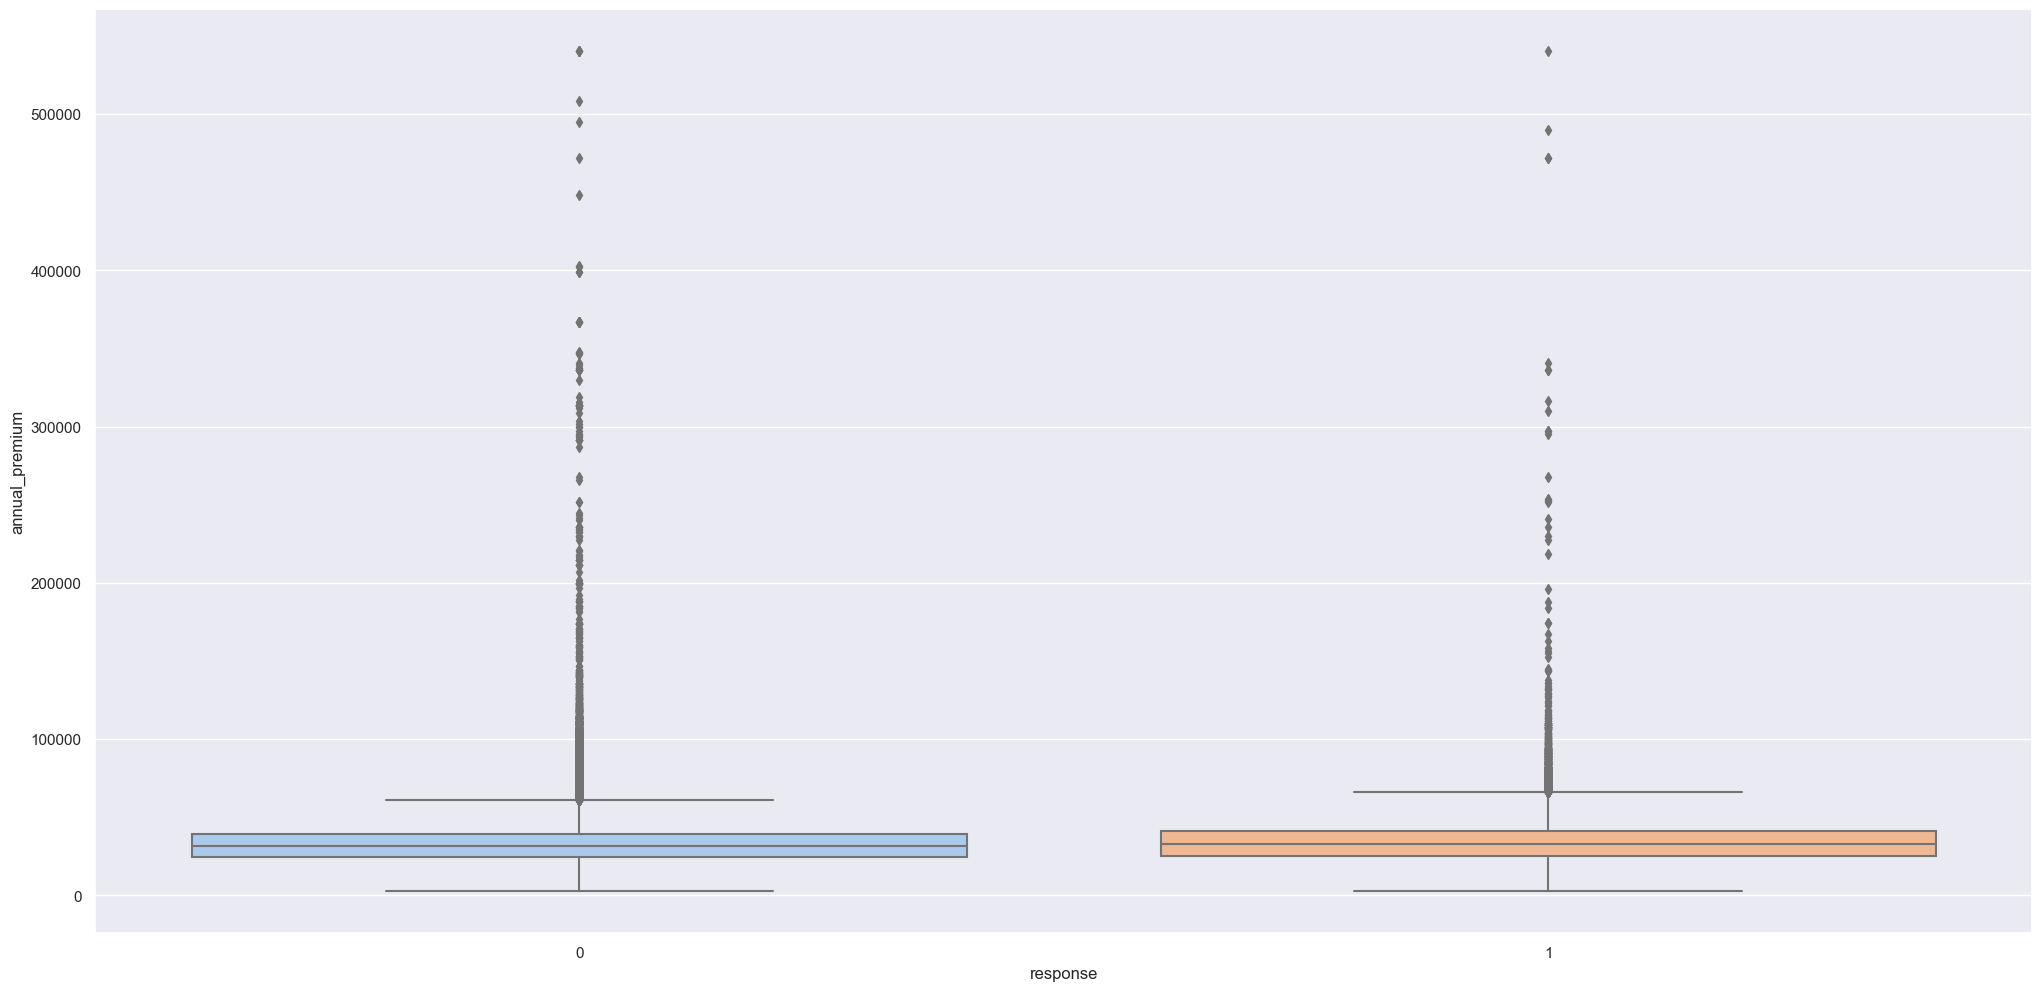

In [84]:
#'annual_premium'
sns.boxplot( x='response', y='annual_premium', data=df4, palette = 'pastel' );

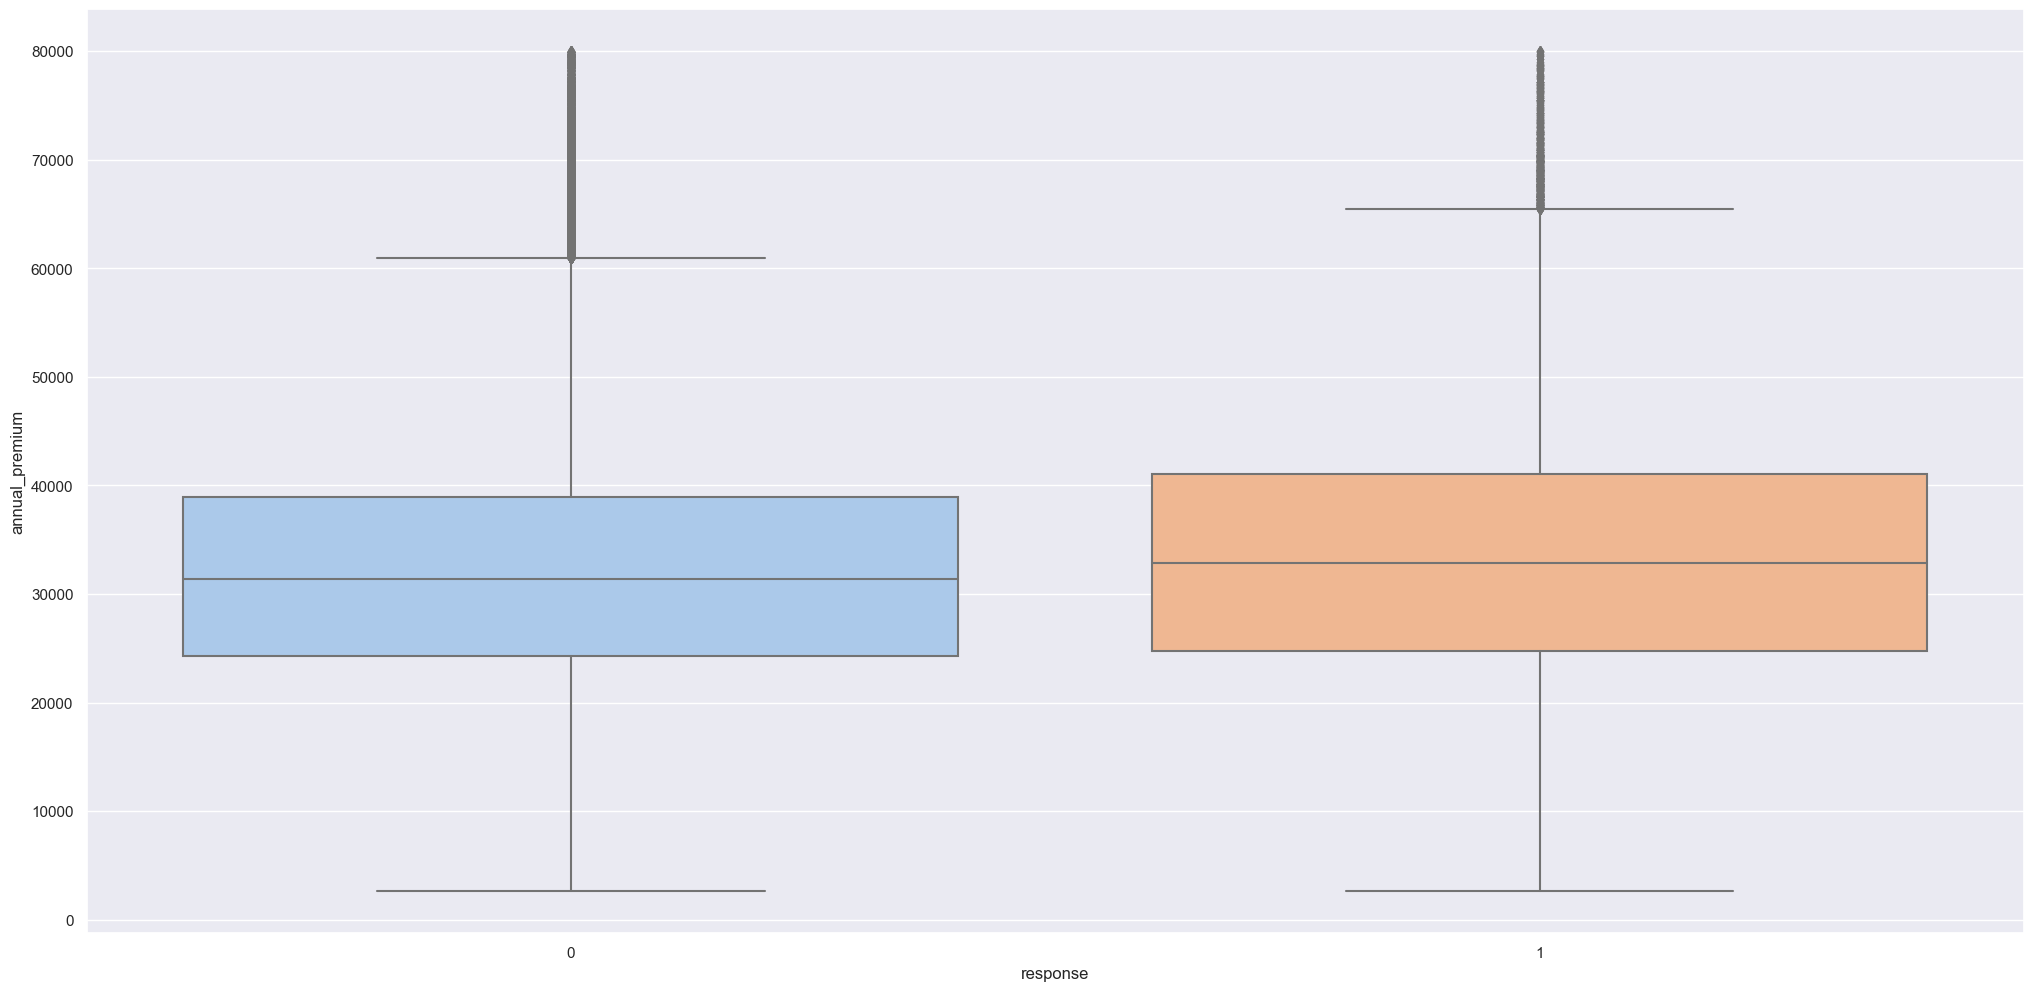

In [85]:
#'annual_premium'
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux, palette = 'pastel' );

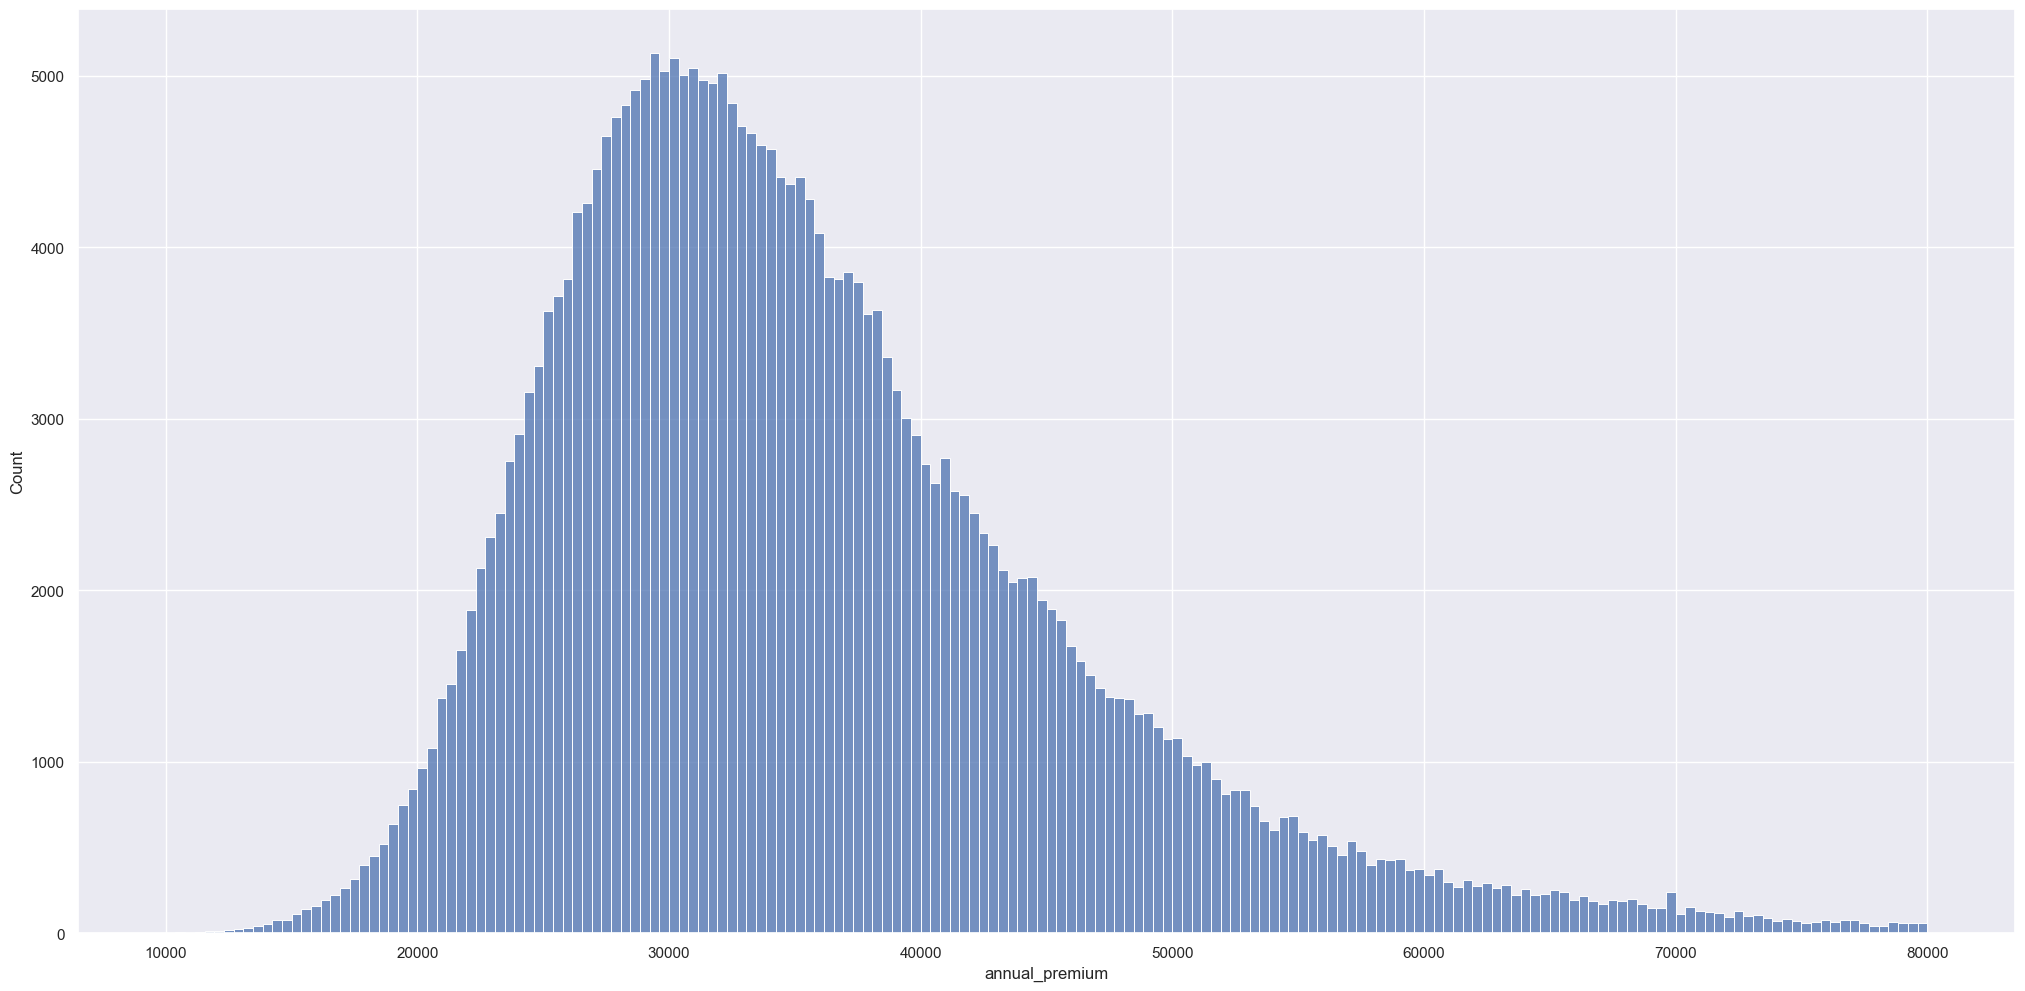

In [86]:
aux = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 80000 )]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( aux00 );

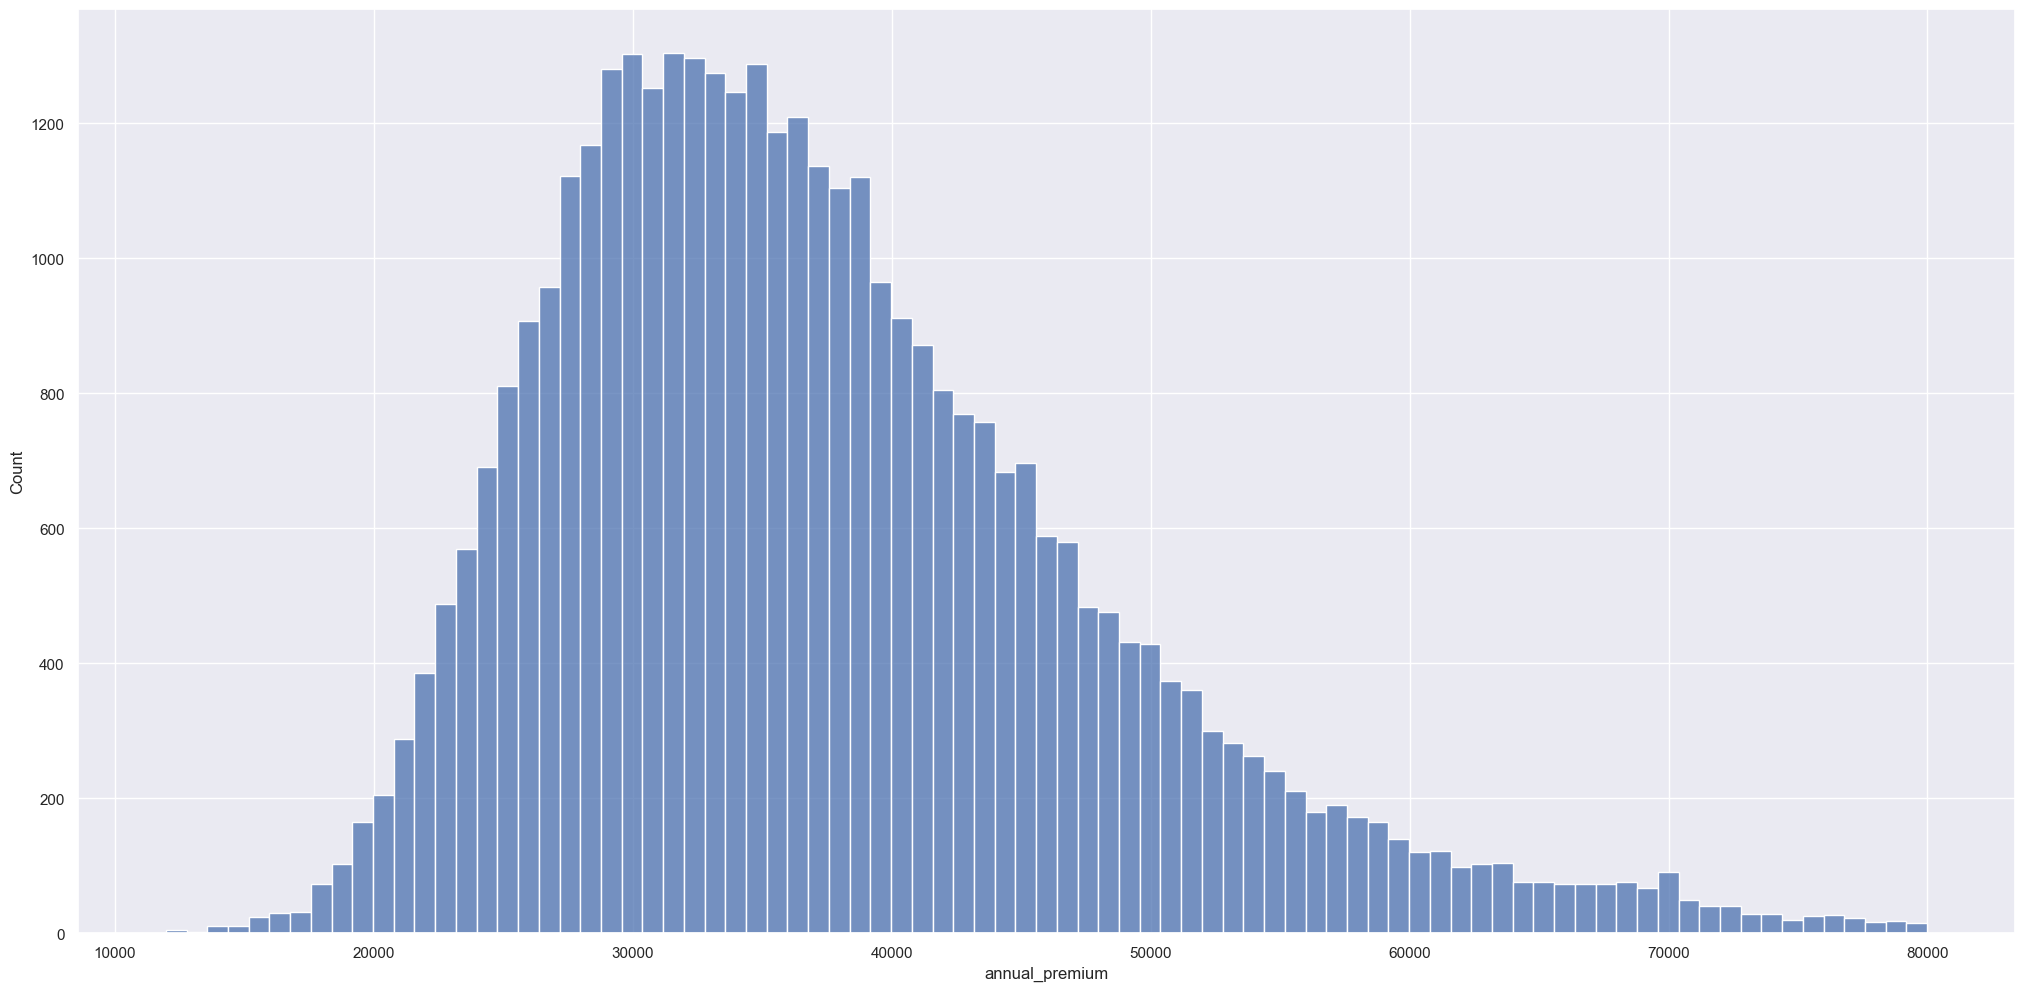

In [87]:
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

In [88]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [89]:
df4.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage            int64
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [90]:
cols = ['id', 'gender', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 
       'vintage', 'response']

num_attributes = df4.drop(cols, axis=1)

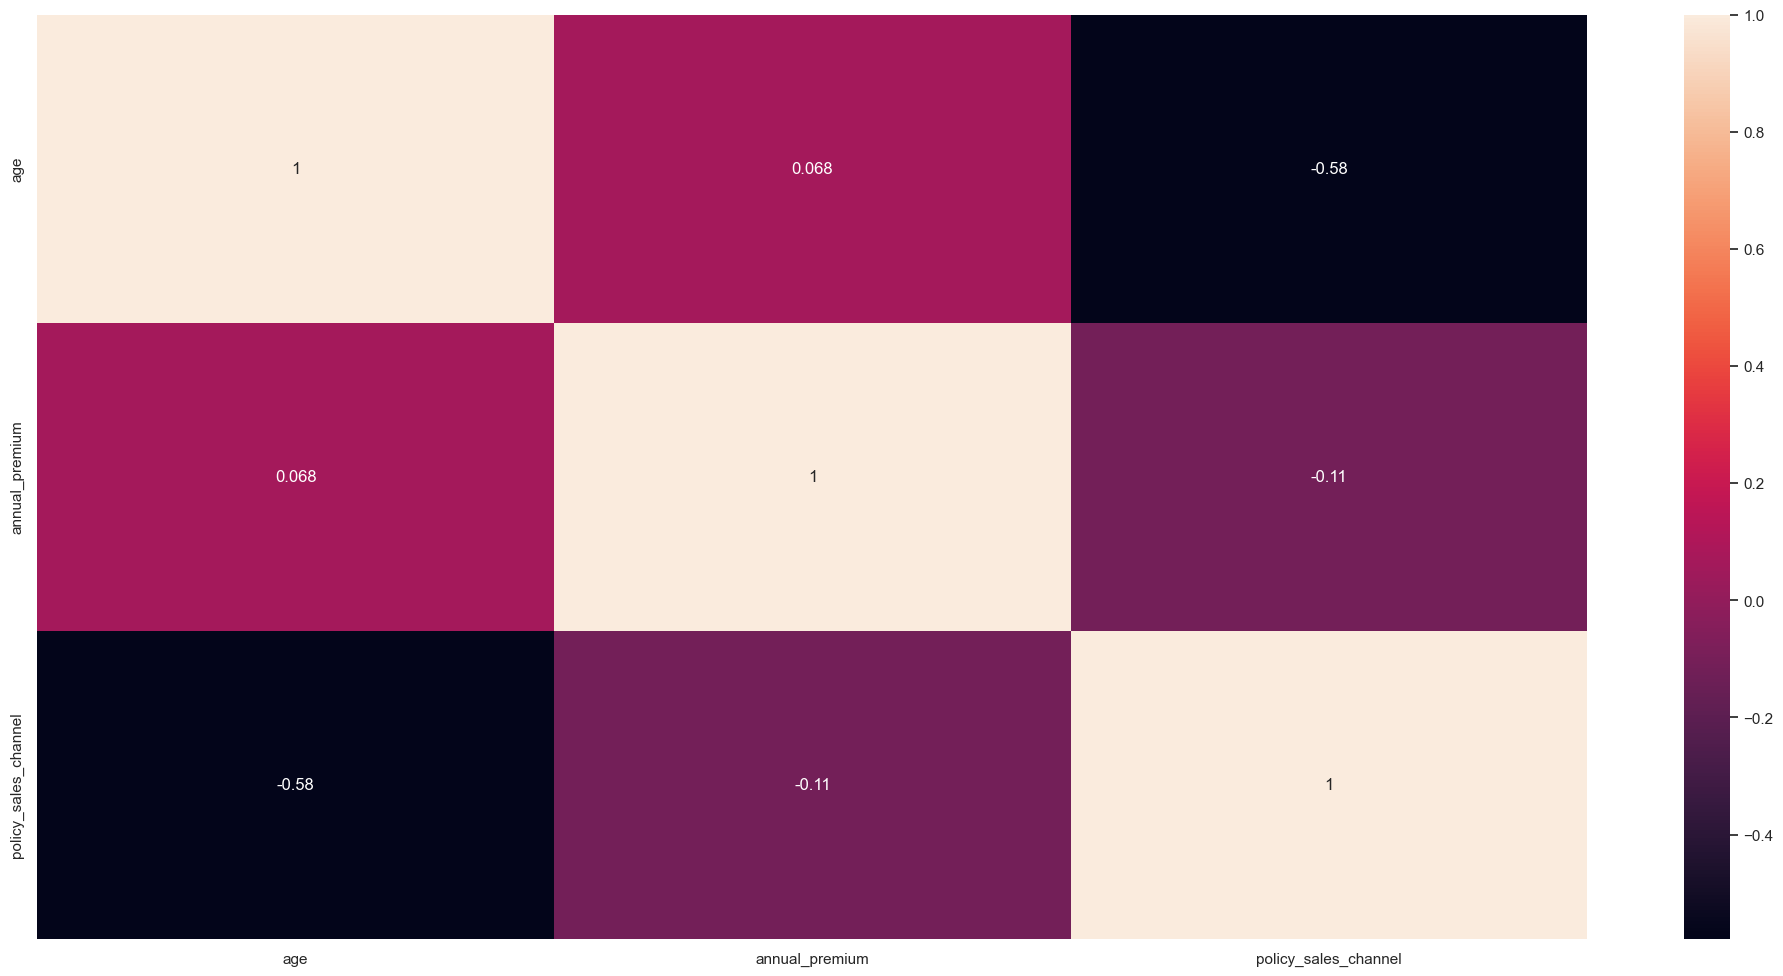

In [91]:
correlation = num_attributes.corr(method = 'pearson' )
sns.heatmap( correlation, annot = True);

### 4.3.2 Categorical Attributes

In [92]:
cat_attributes = df4[['gender', 'driving_license', 'region_code','previously_insured', 'vehicle_age', 'vehicle_damage', 
                      'policy_sales_channel', 'vintage', 'response']].copy()

In [93]:
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( cat_attributes[ ref ], cat_attributes[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

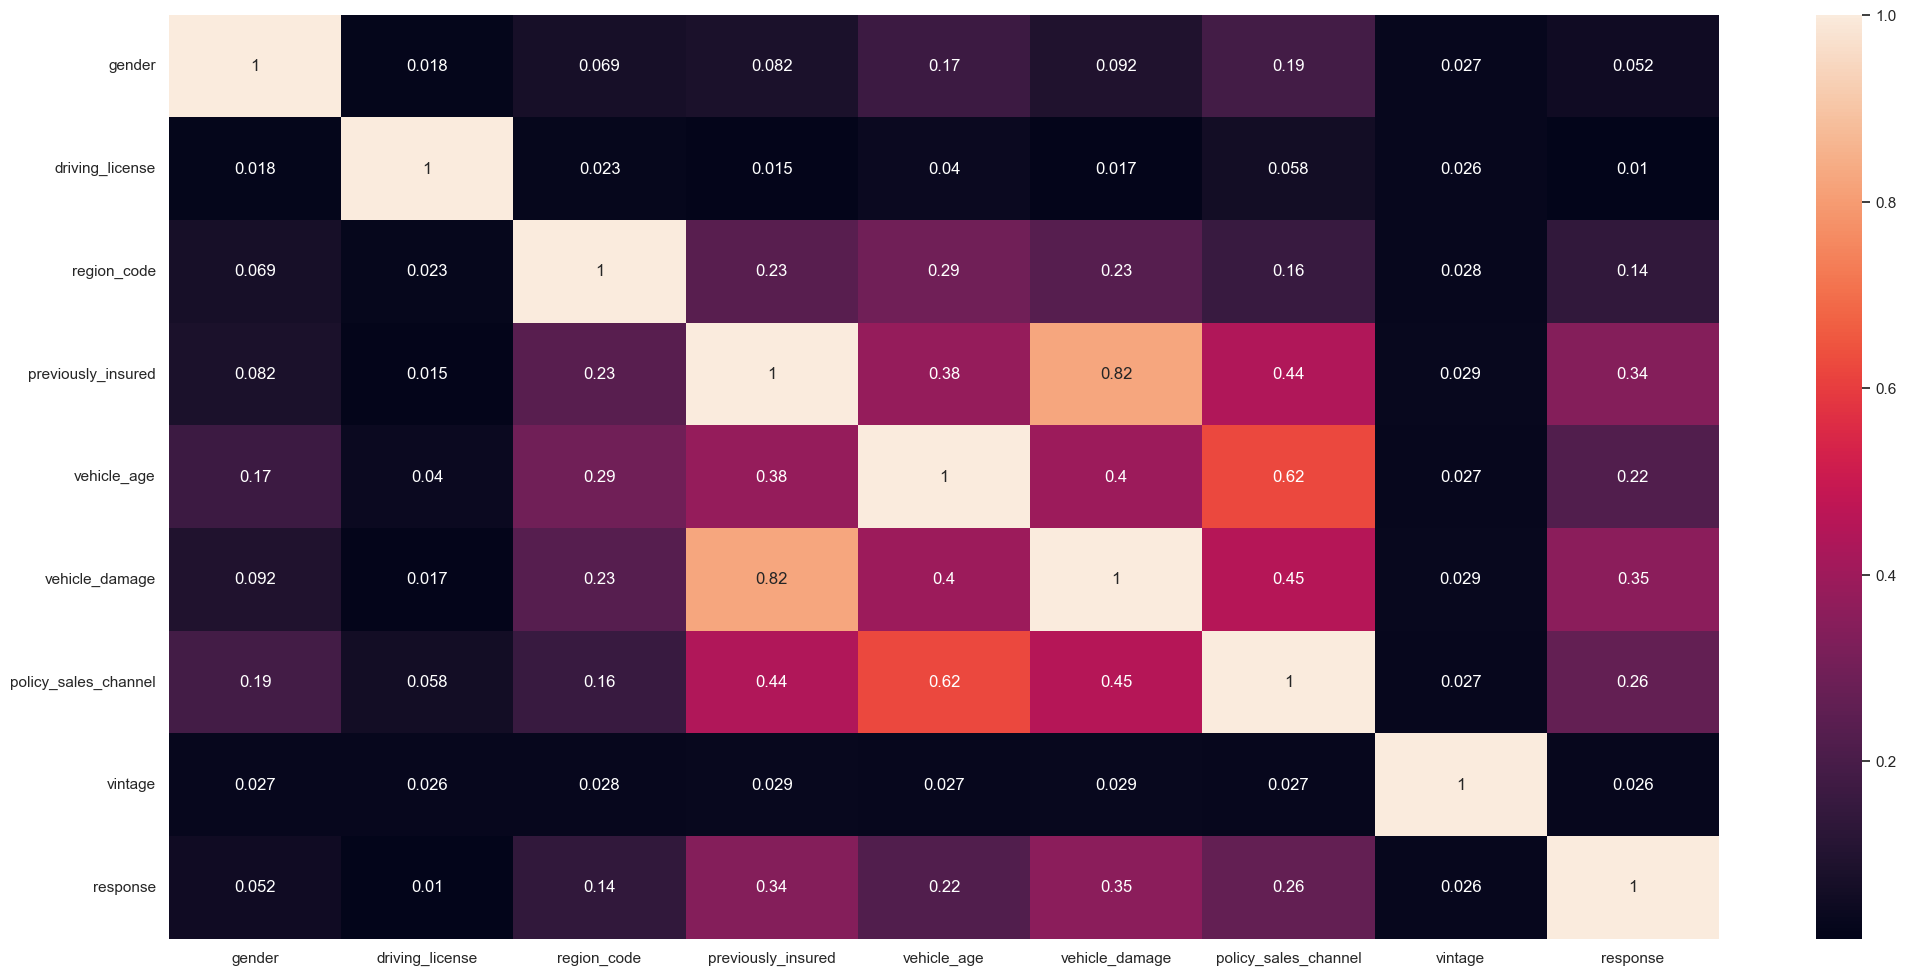

In [94]:
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True );

# 5.0. Data Preparation

In [95]:
df5 = df4.copy()

## 5.0.1 Split dataframe into training and test dataset

In [96]:
# split original dataset into train and not_to_train dataset
df_not_test, df_test = ms.train_test_split( df5, test_size = 0.10, random_state = 42 )

# split df_not_test into cross-validation and test dataset
df_validation, df_train = ms.train_test_split( df_not_test, test_size = 0.78, random_state = 10 )

In [97]:
print( 
f'''Dataset do Hackthon:
{round( (df_train.shape[0] / df5.shape[0]) * 100, 0) }% dataset de treino com {round( (df_train.shape[0]))} clientes, 
{round( (df_validation.shape[0] / df5.shape[0]) * 100, 0)}% dataset de validacao com  {round( (df_validation.shape[0]))} clientes,
{round( (df_test.shape[0] / df5.shape[0]) * 100, 0)}% dataset de teste com {round( (df_test.shape[0]))} clientes'''
)

Dataset do Hackthon:
70.0% dataset de treino com 267539 clientes, 
20.0% dataset de validacao com  75459 clientes,
10.0% dataset de teste com 38111 clientes


In [98]:
# split train dataset into x and y
y_train = df_train[ 'response' ]
x_train = df_train.drop( 'response', axis = 1 )

# split cross-validation dataset into x and y
y_validation = df_validation[ 'response' ]
x_validation = df_validation.drop( 'response', axis = 1 )

# split test dataset into x and y
y_test = df_test[ 'response' ]
x_test = df_test.drop( 'response', axis = 1 )

In [99]:
# # split train d
# y_train.to_csv('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/y_train.csv')
# x_train.to_csv('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_train.csv')
# # split cross-v
# y_validation.to_csv('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/y_validation.csv') 
# x_validation.to_csv('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_validation.csv') 
# # split test da
# y_test.to_csv('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/y_test.csv') 
# x_test.to_csv('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test.csv') 

## 5.0.2 Instanciate

In [100]:
# Instanciate

# Standardization
stds = pp.StandardScaler()

# Rescaling
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

## 5.1 Training Dataset

In [101]:
df5 = pd.concat( [x_train, y_train], axis=1 )

In [102]:
df5.shape

(267539, 12)

In [103]:
df5.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

### 5.1.1 Standardization

In [104]:
# annual_premium
df5['annual_premium'] = stds.fit_transform( df5[['annual_premium']].values )
#pickle.dump(stds, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/annual_premium.pkl','wb') )

### 5.1.2 Rescaling

In [105]:
# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
#pickle.dump(mms_age, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/age.pkl','wb') )
# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
#pickle.dump(mms_vintage, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/vintage.pkl','wb') )

### 5.1.3 Encoding

In [106]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
#pickle.dump(target_encode_gender, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/target_encode_gender.pkl','wb') )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
#pickle.dump(target_encode_region_code, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/target_encode_region_code.pkl','wb') )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
#pickle.dump(fe_policy_sales_channel, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/fe_policy_sales_channel.pkl','wb') )

/tmp/ipykernel_34917/1970515007.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )


## 5.2 Validation Dataset

In [107]:
x_validation = pd.concat( [x_validation, y_validation], axis=1 )

In [108]:
x_validation.shape

(75459, 12)

In [109]:
x_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
61789,61790,Female,27,1,28.00,0,between_1_2_year,1,43332.00,124.00,216,1
340575,340576,Female,21,1,32.00,0,below_1_year,1,22547.00,152.00,187,0
15642,15643,Female,24,1,45.00,1,below_1_year,0,17536.00,152.00,17,0
308108,308109,Female,68,1,28.00,1,between_1_2_year,0,26757.00,124.00,65,0
193925,193926,Male,21,1,46.00,1,below_1_year,0,39252.00,160.00,82,0


### 5.2.1 Standardization

In [110]:
# annual_premium
x_validation['annual_premium'] = stds.fit_transform( x_validation[['annual_premium']].values )
#pickle.dump(stds, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_validation_annual_premium.pkl','wb') )

### 5.2.2 Rescaling

In [111]:
# Age
x_validation['age'] = mms_age.fit_transform( x_validation[['age']].values )
#pickle.dump(mms_age, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_validation_age.pkl','wb') )

# vintage
x_validation['vintage'] = mms_vintage.fit_transform( x_validation[['vintage']].values )
#pickle.dump(mms_vintage, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_validation_vintage.pkl','wb') )

### 5.2.3 Encoding

In [112]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = x_validation.groupby( 'gender' )['response'].mean()
x_validation.loc[:, 'gender'] = x_validation['gender'].map( target_encode_gender )
#pickle.dump(target_encode_gender, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_validation_target_encode_gender.pkl','wb') )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = x_validation.groupby( 'region_code' )['response'].mean()
x_validation.loc[:, 'region_code'] = x_validation['region_code'].map( target_encode_region_code )
#pickle.dump(target_encode_region_code, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_validation_target_encode_region_code.pkl','wb') )

# vehicle_age - One Hot Encoding / Frequency Encoding
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = x_validation.groupby( 'policy_sales_channel' ).size() / len( x_validation ) 
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )
#pickle.dump(fe_policy_sales_channel, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_validation_fe_policy_sales_channel.pkl','wb') )

/tmp/ipykernel_34917/3397163865.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_validation.loc[:, 'gender'] = x_validation['gender'].map( target_encode_gender )


In [113]:
x_validation = x_validation.drop(['response'], axis = 1)
x_validation.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'vehicle_age_below_1_year',
       'vehicle_age_between_1_2_year', 'vehicle_age_over_2_years'],
      dtype='object')

## 5.3  Test Dataset

In [114]:
x_test.shape

(38111, 11)

In [115]:
y_test.shape

(38111,)

In [116]:
x_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
200222,200223,Female,21,1,3.00,1,below_1_year,0,20408.00,160.00,72
49766,49767,Male,55,1,15.00,0,between_1_2_year,1,37498.00,26.00,102
172201,172202,Female,41,1,3.00,0,between_1_2_year,1,2630.00,26.00,90
160713,160714,Female,26,1,11.00,0,below_1_year,0,2630.00,151.00,268
53272,53273,Male,51,1,40.00,0,between_1_2_year,1,34006.00,124.00,265


In [117]:
y_test.head()

200222    0
49766     0
172201    0
160713    0
53272     0
Name: response, dtype: int64

### 5.3.1 Standardization

In [118]:
# annual_premium
x_test['annual_premium'] = stds.fit_transform(x_test[['annual_premium']].values )
#pickle.dump(stds, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_annual_premium.pkl','wb') )

In [119]:
x_test['annual_premium'].head()

200222   -0.58
49766     0.41
172201   -1.61
160713   -1.61
53272     0.20
Name: annual_premium, dtype: float64

In [120]:
x_test[['annual_premium']].values

array([[-0.58113314],
       [ 0.40618292],
       [-1.60819604],
       ...,
       [-1.60819604],
       [-1.60819604],
       [ 1.72487668]])

### 5.3.2 Rescaling

In [121]:
# Age
x_test['age'] = mms_age.fit_transform(x_test[['age']].values )
#pickle.dump(mms_age, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_age.pkl','wb') )
# vintage
x_test['vintage'] = mms_vintage.fit_transform( x_test[['vintage']].values )
#pickle.dump(mms_vintage, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_vintage.pkl','wb') )

### 5.3.3 Encoding

In [122]:
# gender - One Hot Encoding / Target Encoding
x_test.loc[:, 'gender'] =  x_test.loc[:, 'gender'].map( target_encode_gender )
#pickle.dump(target_encode_gender, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_target_encode_gender.pkl','wb') )

# region_code - Target Encoding / Frequency Encoding
x_test.loc[:, 'region_code'] = x_test.loc[:, 'region_code'].map( target_encode_region_code )
#pickle.dump(target_encode_region_code, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_target_encode_region_code.pkl','wb') )

# vehicle_age - One Hot Encoding / Frequency Encoding
x_test = pd.get_dummies( x_test, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = x_test.groupby( 'policy_sales_channel' ).size() / len( x_test ) 
x_test.loc[:, 'policy_sales_channel'] = x_test['policy_sales_channel'].map( fe_policy_sales_channel )
#pickle.dump(fe_policy_sales_channel, open('/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_fe_policy_sales_channel.pkl','wb') )

/tmp/ipykernel_34917/460496901.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_test.loc[:, 'gender'] =  x_test.loc[:, 'gender'].map( target_encode_gender )


# 6.0. Feature Selection

## 6.1. Features Importancia

In [123]:
# model definition
# forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage        0.27
0                annual_premium        0.24
0                           age        0.17
0                   region_code        0.11
0                vehicle_damage        0.07
0          policy_sales_channel        0.06
0            previously_insured        0.06
0      vehicle_age_below_1_year        0.01
0  vehicle_age_between_1_2_year        0.01
0                        gender        0.01
0      vehicle_age_over_2_years        0.00
0               driving_license        0.00


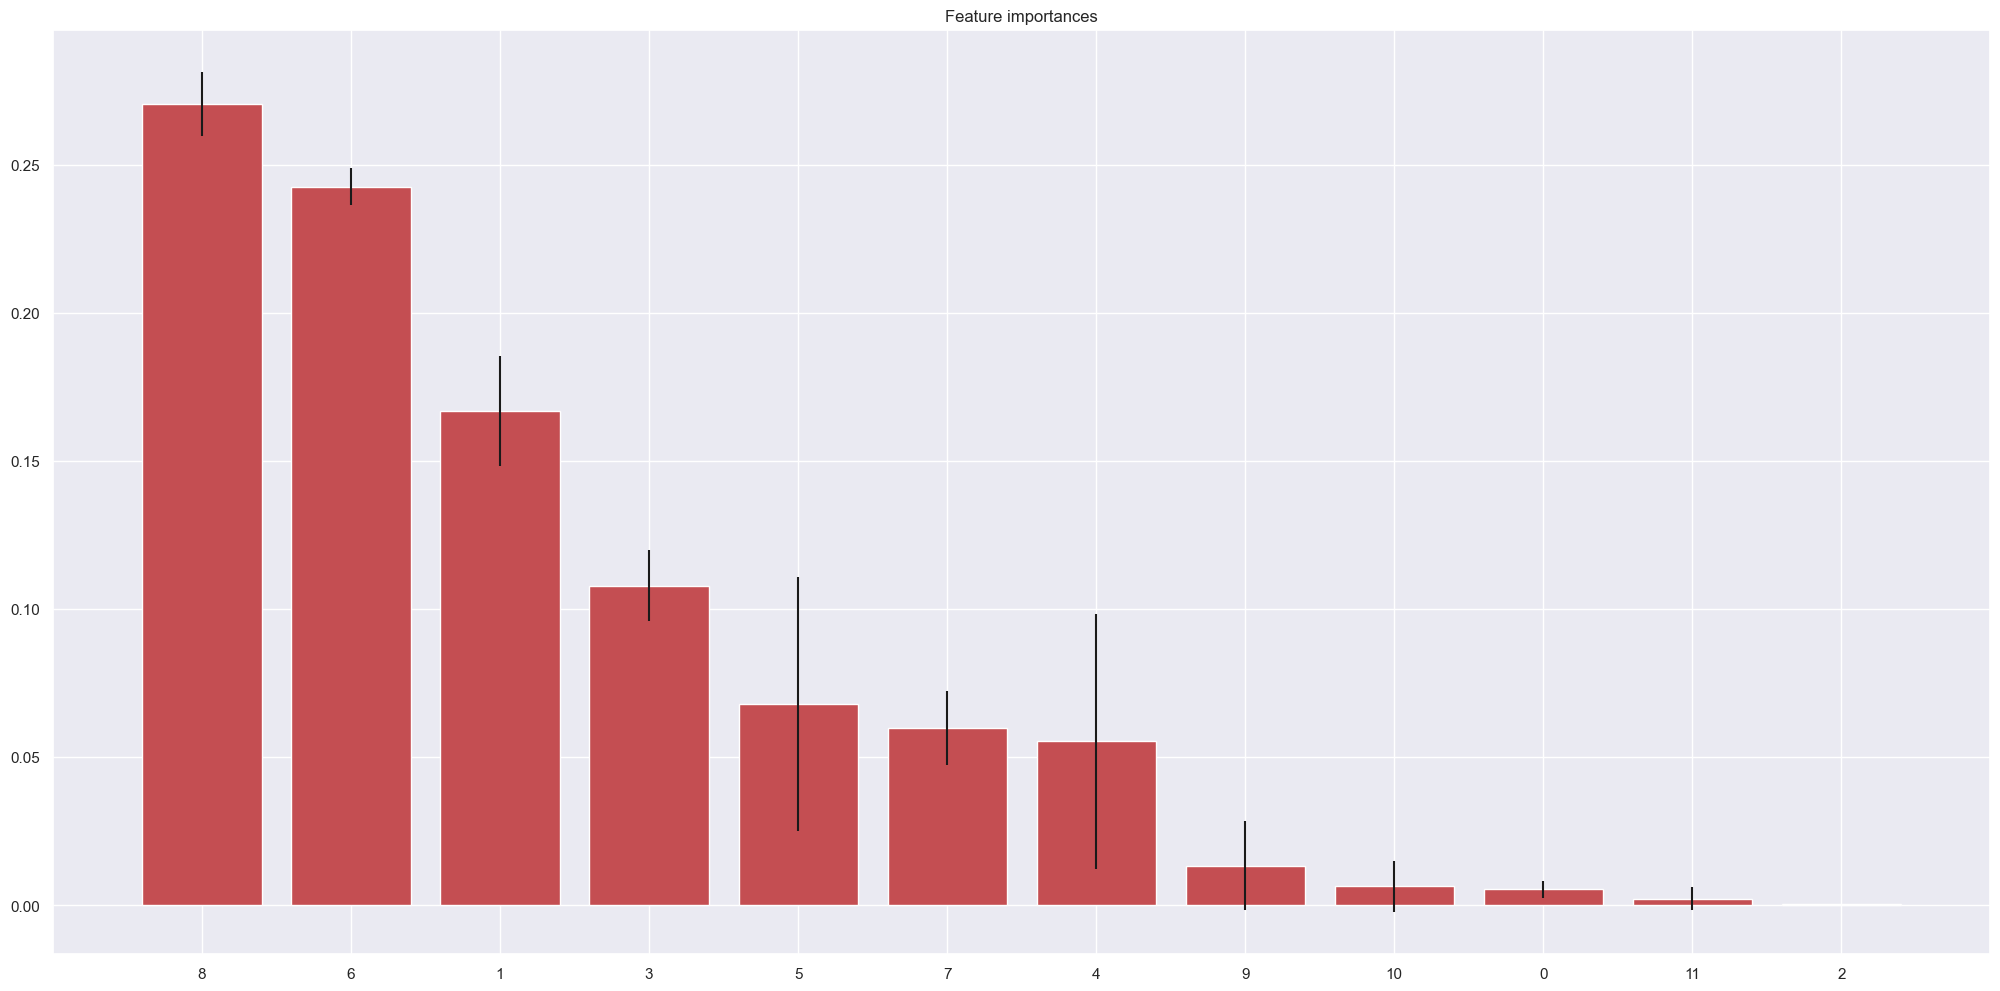

In [124]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [125]:
# df5.to_csv('/home/deivison/Documentos/projetos/pa_04/pickle/version_2/df5.csv')
# y_train.to_csv('/home/deivison/Documentos/projetos/pa_04/pickle/version_2/y_train.csv') 
# x_validation.to_csv('/home/deivison/Documentos/projetos/pa_04/pickle/version_2/x_validation.csv')
# y_validation.to_csv('/home/deivison/Documentos/projetos/pa_04/pickle/version_2/y_validation.csv')

# 7.0. Machine Learning